In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from yacs.config import CfgNode as CN
import os
from PIL import Image 
import torch
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from cityscapesscripts.helpers.labels import trainId2label as t2l
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from einops import rearrange
import shutil
import time
import tqdm
from csv import reader
from functools import reduce
import torchvision
import torch._utils
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import numpy as np
import math
from torchvision import models
import progressbar
from time import sleep
from pathlib import Path
import csv
import itertools
import random
import gc
import statistics
import pandas as pd
import logging
import functools
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
ROOT_DIR = '/home/sourajit/DeepLearningProjects/data/cityscapes'
VAL_PRED_LOCATION = '/home/sourajit/DeepLearningProjects/Research_2.0/Semantic_Segmentation/Cityscapes_Experiments/Trial_005/'
TEST_PRED_LOCATION = '/home/sourajit/DeepLearningProjects/Research_2.0/Semantic_Segmentation/Cityscapes_Experiments/Trial_005/'
MODEL_PATH = '/home/sourajit/DeepLearningProjects/Research_2.0/Semantic_Segmentation/Cityscapes_Experiments/Trial_005/model.pth'
TRAIN_LOSS_DIR = '/home/sourajit/DeepLearningProjects/Research_2.0/Semantic_Segmentation/Cityscapes_Experiments/Trial_005/Training_Loss_log.csv'
TRAIN_meanIOU_DIR = '/home/sourajit/DeepLearningProjects/Research_2.0/Semantic_Segmentation/Cityscapes_Experiments/Trial_005/Training_meanIOU_log.csv'
TRAIN_LR_DIR = '/home/sourajit/DeepLearningProjects/Research_2.0/Semantic_Segmentation/Cityscapes_Experiments/Trial_005/Training_LR_log.csv'
TRAIN_MODEL_UPDATE_DIR = '/home/sourajit/DeepLearningProjects/Research_2.0/Semantic_Segmentation/Cityscapes_Experiments/Trial_005/Training_model_update_log.csv'
Global_Epoch_Counter_DIR = '/home/sourajit/DeepLearningProjects/Research_2.0/Semantic_Segmentation/Cityscapes_Experiments/Trial_005/Global_Epoch_Counter.csv'
TRAIN_LOSS = []
TRAIN_mIOU = []
TRAIN_LR = []
TRAIN_MODEL_UPDATE = []
TRAIN_MODEL_UPDATE_DIR
BEST_mIOU = 0
IMG_HEIGHT = 512  
IMG_WIDTH = 1024
ORIGINAL_IMG_HEIGHT = 1024  
ORIGINAL_IMG_WIDTH = 2048
BATCH_SIZE = 8
LEARNING_RATE = 0.0005
EPOCHS = 10
GLOBAL_EPOCH_COUNTER = 0
MAX_ITER = 3000000
NUM_WORKERS = 8
NUM_CLASSES = 19
ignore_label = 255
BatchNorm2d = nn.BatchNorm2d
BN_MOMENTUM = 0.01
ALIGN_CORNERS = True
logger = logging.getLogger(__name__)
device_rtx3090 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_rtx3070 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [3]:
BatchNorm2d = nn.BatchNorm2d
BN_MOMENTUM = 0.01
ALIGN_CORNERS = True
logger = logging.getLogger(__name__)

In [4]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [6]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion,
                               momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [7]:
class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=True)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            logger.error(error_msg)
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(num_channels[branch_index] * block.expansion,
                            momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        BatchNorm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3, 
                                            momentum=BN_MOMENTUM)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM),
                                nn.ReLU(inplace=True)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                elif j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.interpolate(
                        self.fuse_layers[i][j](x[j]),
                        size=[height_output, width_output],
                        mode='bilinear')
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


In [8]:
blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}

In [9]:
HIGH_RESOLUTION_NET = CN()
HIGH_RESOLUTION_NET.PRETRAINED_LAYERS = ['*']
HIGH_RESOLUTION_NET.STEM_INPLANES = 64
HIGH_RESOLUTION_NET.FINAL_CONV_KERNEL = 1
HIGH_RESOLUTION_NET.WITH_HEAD = True

HIGH_RESOLUTION_NET.STAGE1 = CN()
HIGH_RESOLUTION_NET.STAGE1.NUM_MODULES = 1
HIGH_RESOLUTION_NET.STAGE1.NUM_BRANCHES = 1
HIGH_RESOLUTION_NET.STAGE1.NUM_BLOCKS = [4]
HIGH_RESOLUTION_NET.STAGE1.NUM_CHANNELS = [64]
HIGH_RESOLUTION_NET.STAGE1.BLOCK = 'BOTTLENECK'
HIGH_RESOLUTION_NET.STAGE1.FUSE_METHOD = 'SUM'

HIGH_RESOLUTION_NET.STAGE2 = CN()
HIGH_RESOLUTION_NET.STAGE2.NUM_MODULES = 1
HIGH_RESOLUTION_NET.STAGE2.NUM_BRANCHES = 2
HIGH_RESOLUTION_NET.STAGE2.NUM_BLOCKS = [4, 4]
HIGH_RESOLUTION_NET.STAGE2.NUM_CHANNELS = [48, 96]
HIGH_RESOLUTION_NET.STAGE2.BLOCK = 'BASIC'
HIGH_RESOLUTION_NET.STAGE2.FUSE_METHOD = 'SUM'

HIGH_RESOLUTION_NET.STAGE3 = CN()
HIGH_RESOLUTION_NET.STAGE3.NUM_MODULES = 4
HIGH_RESOLUTION_NET.STAGE3.NUM_BRANCHES = 3
HIGH_RESOLUTION_NET.STAGE3.NUM_BLOCKS = [4, 4, 4]
HIGH_RESOLUTION_NET.STAGE3.NUM_CHANNELS = [48, 96, 192]
HIGH_RESOLUTION_NET.STAGE3.BLOCK = 'BASIC'
HIGH_RESOLUTION_NET.STAGE3.FUSE_METHOD = 'SUM'

HIGH_RESOLUTION_NET.STAGE4 = CN()
HIGH_RESOLUTION_NET.STAGE4.NUM_MODULES = 3
HIGH_RESOLUTION_NET.STAGE4.NUM_BRANCHES = 4
HIGH_RESOLUTION_NET.STAGE4.NUM_BLOCKS = [4, 4, 4, 4]
HIGH_RESOLUTION_NET.STAGE4.NUM_CHANNELS = [48, 96, 192, 384]
HIGH_RESOLUTION_NET.STAGE4.BLOCK = 'BASIC'
HIGH_RESOLUTION_NET.STAGE4.FUSE_METHOD = 'SUM'

DATASET = CN()
DATASET.ROOT = ''
DATASET.DATASET = 'cityscapes'
DATASET.NUM_CLASSES = 19
DATASET.TRAIN_SET = 'list/cityscapes/train.lst'
DATASET.EXTRA_TRAIN_SET = ''
DATASET.TEST_SET = 'list/cityscapes/val.lst'

MODEL = CN()
MODEL.NAME = 'seg_hrnet'
MODEL.PRETRAINED = '/home/sourajit/DeepLearningProjects/Research_2.0/hrnet_cs_8090_torch11.pth'
MODEL.ALIGN_CORNERS = True
MODEL.NUM_OUTPUTS = 1
MODEL.EXTRA = CN(new_allowed=True)

In [10]:
class HighResolutionNetv1(nn.Module):

    def __init__(self, model_config=None, dataset_config=None):
        model_config = model_config
        dataset_config = dataset_config
        super(HighResolutionNetv1, self).__init__()

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        
        self.stage1_cfg = model_config['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = model_config['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = model_config['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = model_config['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)
        
        last_inp_channels = np.int(np.sum(pre_stage_channels))
        self.before_last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=model_config.FINAL_CONV_KERNEL,
                stride=1,
                padding=1 if model_config.FINAL_CONV_KERNEL == 3 else 0)
        )
        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=dataset_config.NUM_CLASSES,
                kernel_size=model_config.FINAL_CONV_KERNEL,
                stride=1,
                padding=1 if model_config.FINAL_CONV_KERNEL == 3 else 0)
        )

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        out_h, out_w = x.size(2), x.size(3)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        #print ("After first few: ", x.shape)
        x = self.layer1(x)
        #print ("After stage 1: ", x.shape)
        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)
        #for idx in range(len(y_list)):
            #print ("After stage 2: ", y_list[idx].shape)
        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)
        #for idx in range(len(y_list)):
            #print ("After stage 3: ", y_list[idx].shape)
        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)
        #for idx in range(len(x)):
            #print ("After stage 4: ", x[idx].shape)
        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        #print ("..........", x0_h, x0_w)
        x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear',
                        align_corners=ALIGN_CORNERS)
        #print ("After upsample1: ", x1.shape)
        x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear',
                        align_corners=ALIGN_CORNERS)
        #print ("After upsample2: ", x2.shape)
        x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear',
                        align_corners=ALIGN_CORNERS)
        #print ("After upsample3: ", x3.shape)
        x = torch.cat([x[0], x1, x2, x3], 1)
        #print ("After cat: ", x.shape)
        x = self.before_last_layer(x)
        #print ("After last layer 1: ", x.shape)
        x = F.interpolate(x, size=(2*x.size(2), 2*x.size(3)), mode='bilinear', align_corners=ALIGN_CORNERS)
        x = self.before_last_layer(x)
        #print ("After last layer 2: ", x.shape)
        x = F.interpolate(x, size=(2*x.size(2), 2*x.size(3)), mode='bilinear', align_corners=ALIGN_CORNERS)
        x = self.last_layer(x)
        #print ("After the very last layer: ", x.shape)
        return x

    def init_weights(self, pretrained='',):
        logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if os.path.isfile(pretrained):
            pretrained_dict = torch.load(pretrained)
            #print (len(pretrained_dict))
            logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
            #for k, _ in pretrained_dict.items():
            #    logger.info(
            #        '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)

In [11]:
class HighResolutionNet(nn.Module):

    def __init__(self, model_config=None, dataset_config=None):
        model_config = model_config
        dataset_config = dataset_config
        super(HighResolutionNet, self).__init__()

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        
        self.stage1_cfg = model_config['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = model_config['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = model_config['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = model_config['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)
        
        last_inp_channels = np.int(np.sum(pre_stage_channels))
        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=dataset_config.NUM_CLASSES,
                kernel_size=model_config.FINAL_CONV_KERNEL,
                stride=1,
                padding=1 if model_config.FINAL_CONV_KERNEL == 3 else 0)
        )

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        out_h, out_w = x.size(2), x.size(3)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        #print ("After first few: ", x.shape)
        x = self.layer1(x)
        #print ("After stage 1: ", x.shape)
        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)
        #for idx in range(len(y_list)):
            #print ("After stage 2: ", y_list[idx].shape)
        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)
        #for idx in range(len(y_list)):
            #print ("After stage 3: ", y_list[idx].shape)
        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)
        #for idx in range(len(x)):
            #print ("After stage 4: ", x[idx].shape)
        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        #print ("..........", x0_h, x0_w)
        x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear',
                        align_corners=ALIGN_CORNERS)
        #print ("After upsample1: ", x1.shape)
        x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear',
                        align_corners=ALIGN_CORNERS)
        #print ("After upsample2: ", x2.shape)
        x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear',
                        align_corners=ALIGN_CORNERS)
        #print ("After upsample3: ", x3.shape)
        x = torch.cat([x[0], x1, x2, x3], 1)
        #print ("After cat: ", x.shape)
        x = self.last_layer(x)
        #print ("After the very last layer: ", x.shape)
        #x = F.interpolate(x, size=(out_h, out_w), mode='bilinear', align_corners=ALIGN_CORNERS)
        #print ("After final upsampling: ", x.shape)
        return x

    def init_weights(self, pretrained='',):
        logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if os.path.isfile(pretrained):
            pretrained_dict = torch.load(pretrained)
            #print (len(pretrained_dict))
            logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
            #for k, _ in pretrained_dict.items():
            #    logger.info(
            #        '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)

In [12]:
def count_num_param(model):
    return sum(p.numel() for p in model.parameters())

In [13]:
def print_param(num_param):
    num_param = str(num_param)
    ret = []
    length = len(num_param)
    for i in range(length):
        idx = i+1
        if (idx>1 and (idx-1)%3==0):
            ret.append(',')
        ret.append(num_param[length-idx])
    ret.reverse()
    ret = ''.join(ret)
    temp_a = '## Number of parameters: ' + ret  + ' ##'
    temp_b = '#' * len(temp_a)
    columns = shutil.get_terminal_size().columns
    print (f'{temp_b}'.center(columns))
    print (f'{temp_a}'.center(columns))
    print (f'{temp_b}'.center(columns))

In [14]:
def checker(filename):
    filename = str(filename)
    data_type = None
    if (filename == 'None'):
        data_type = 'Train Set'
    elif (filename.startswith("['/frankfurt") or
         filename.startswith("['/lindau") or
         filename.startswith("['/munster")):
        data_type = 'Val Set'
    else:
        data_type = 'Test Set'
    return data_type

In [15]:
def print_msg1(data_type, elapsed):
    empty = '     '
    msg = empty+'>>>  IOU evaluated on '+ data_type + ' in ' + f'{elapsed:5.5f}' + ' seconds'+empty
    print ('='*len(msg))
    print (msg)
    print ('='*len(msg))
    return

In [16]:
def print_msg2(data_type, elapsed):
    empty = '     '
    msg = empty+'>>>  Predictions saved & IOU evaluated on '+ data_type + ' in ' + f'{elapsed:5.5f}' + ' seconds'+empty
    print ('='*len(msg))
    print (msg)
    print ('='*len(msg))
    return

In [17]:
def print_msg3(data_type, elapsed):
    empty = '     '
    msg = empty+'>>>  Predictions saved on '+ data_type + ' in ' + f'{elapsed:5.5f}' + ' seconds'+empty
    print ('='*len(msg))
    print (msg)
    print ('='*len(msg))
    return

In [18]:
def plot_training_performance():
    TRAIN_LOSS_CSV = pd.read_csv(TRAIN_LOSS_DIR)
    TRAIN_LR_CSV = pd.read_csv(TRAIN_LR_DIR)
    TRAIN_meanIOU_CSV = pd.read_csv(TRAIN_meanIOU_DIR)
    TRAIN_MODEL_UPDATE_CSV = pd.read_csv(TRAIN_MODEL_UPDATE_DIR)
    vis_train_loss_iter = []
    vis_train_loss_epoch_temp = []
    vis_train_loss_epoch = []
    vis_train_lr_iter = []
    vis_train_miou_epoch = []
    vis_train_model_update_epoch = []
    num_epochs = len(TRAIN_meanIOU_CSV)+1
    num_iterations = len(TRAIN_LOSS_CSV)+1
    num_batches = int(num_iterations/num_epochs)
    cnt = 0
    temp_sum = 0
    with open(TRAIN_LOSS_DIR, 'r')as read_obj:
        csv_reader = reader(read_obj)
        for current_loss in csv_reader:
            cnt += 1
            vis_train_loss_iter.append(float(current_loss[0]))
            temp_sum += float(current_loss[0])
            if (cnt % num_batches == 0):
                vis_train_loss_epoch_temp.append(temp_sum/num_batches)
                temp_sum = 0
    for epc in range(num_epochs):
        for btch in range(num_batches):
            vis_train_loss_epoch.append(vis_train_loss_epoch_temp[epc])
    with open(TRAIN_LR_DIR, 'r')as read_obj:
        csv_reader = reader(read_obj)
        for current_lr in csv_reader:
            vis_train_lr_iter.append(float(current_lr[0]))
    with open(TRAIN_meanIOU_DIR, 'r')as read_obj:
        csv_reader = reader(read_obj)
        for current_miou in csv_reader:
            for btch in range(num_batches):
                vis_train_miou_epoch.append(float(current_miou[0])/100.0)
    with open(TRAIN_MODEL_UPDATE_DIR, 'r')as read_obj:
        csv_reader = reader(read_obj)
        for current_model_update in csv_reader:
            for btch in range(num_batches):
                vis_train_model_update_epoch.append(float(current_model_update[0]))
    fig, axs = plt.subplots(1, figsize=(20, 12))
    axs.plot([x for x in range(num_iterations)], vis_train_loss_iter)
    axs.plot([x for x in range(num_iterations)], vis_train_loss_epoch)
    axs.plot([x for x in range(num_iterations)], vis_train_lr_iter)
    axs.plot([x for x in range(num_iterations)], vis_train_miou_epoch)
    axs.plot([x for x in range(num_iterations)], vis_train_model_update_epoch)
    axs.set_xlabel('Training Iterations')
    axs.set_ylabel('Training Loss, Learning Rate, mIOU, Model Update Status')
    axs.legend(['Iteration Loss', 'Epoch Loss', 'Epoch Learning Rate', 'Epoch mIOU', 
                'Model Update'],loc='best')
    fig.suptitle('Outlining Training Loss')

In [19]:
def save_as_images(tensor_pred, folder, image_name):
    tensor_pred = transforms.ToPILImage()(255*tensor_pred[0].type(torch.FloatTensor))
    filename = f"{folder}/{image_name}.png"
    tensor_pred.save(filename)

In [20]:
def Average(lst):
    return reduce(lambda a, b: a + b, lst) / len(lst)

In [21]:
color_mapping_before_conversion = {
     0 : (  0,  0,  0),
     1 : (  0,  0,  0),
     2 : (  0,  0,  0),
     3 : (  0,  0,  0),
     4 : (  0,  0,  0),
     5 : (111, 74,  0),
     6 : ( 81,  0, 81),
     7 : (128, 64,128),
     8 : (244, 35,232),
     9 : (250,170,160),
    10 : (230,150,140),
    11 : ( 70, 70, 70),
    12 : (102,102,156),
    13 : (190,153,153),
    14 : (180,165,180),
    15 : (150,100,100),
    16 : (150,120, 90),
    17 : (153,153,153),
    18 : (153,153,153),
    19 : (250,170, 30),
    20 : (220,220,  0),
    21 : (107,142, 35),
    22 : (152,251,152),
    23 : ( 70,130,180),
    24 : (220, 20, 60),
    25 : (255,  0,  0),
    26 : (  0,  0,142),
    27 : (  0,  0, 70),
    28 : (  0, 60,100),
    29 : (  0,  0, 90),
    30 : (  0,  0,110),
    31 : (  0, 80,100),
    32 : (  0,  0,230),
    33 : (119, 11, 32),
    -1 : (  0,  0,142)
}

In [22]:
color_mapping_after_conversion = {
     255 : (  0,  0,  0),
     0 : (128, 64,128),
     1 : (244, 35,232),
     2 : ( 70, 70, 70),
     3 : (102,102,156),
     4 : (190,153,153),
     5 : (153,153,153),
     6 : (250,170, 30),
     7 : (220,220,  0),
     8 : (107,142, 35),
     9 : (152,251,152),
    10 : ( 70,130,180),
    11 : (220, 20, 60),
    12 : (255,  0,  0),
    13 : (  0,  0,142),
    14 : (  0,  0, 70),
    15 : (  0, 60,100),
    16 : (  0, 80,100),
    17 : (  0,  0,230),
    18 : (119, 11, 32)
}

In [23]:
id2class_after_conversion = {
     255 : "unlabeled",
     0 : "road",
     1 : "sidewalk",
     2 : "building",
     3 : "wall",
     4 : "fence",
     5 : "pole",
     6 : "traffic light",
     7 : "traffic sign",
     8 : "vegetation",
     9 : "terrain",
    10 : "sky",
    11 : "preson",
    12 : "rider",
    13 : "car",
    14 : "truck",
    15 : "bus",
    16 : "train",
    17 : "motorcycle",
    18 : "bicycle"
}

In [24]:
def label2color(label, color_array):
    temp = label.clone()
    label1 = label.clone()
    label2 = label.clone()
    label3 = label.clone()
    #print (label.dtype, temp.dtype, label1.dtype, label2.dtype, label3.dtype)
    for k, v in color_array.items():
        label1[temp == k] = v[0]
        label2[temp == k] = v[1]
        label3[temp == k] = v[2]
    #print (label1.shape, label2.shape, label3.shape)
    label1 = rearrange(label1, 'd0 d1 d2 -> d0 1 d1 d2')
    label2 = rearrange(label2, 'd0 d1 d2 -> d0 1 d1 d2')
    label3 = rearrange(label3, 'd0 d1 d2 -> d0 1 d1 d2')
    #print (label1.shape, label2.shape, label3.shape)
    ret = torch.stack((label1, label2, label3), 1)
    ret = rearrange(ret, 'd0 d1 d2 d3 d4-> d0 (d1 d2) d3 d4')
    return ret

In [25]:
label_mapping = {-1: 255, 0: 255, 
                  1: 255, 2: 255, 
                  3: 255, 4: 255, 
                  5: 255, 6: 255, 
                  7: 0, 8: 1, 9: 255, 
                  10: 255, 11: 2, 12: 3, 
                  13: 4, 14: 255, 15: 255, 
                  16: 255, 17: 5, 18: 255, 
                  19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11,
                  25: 12, 26: 13, 27: 14, 28: 15, 
                  29: 255, 30: 255, 
                  31: 16, 32: 17, 33: 18}
class_weights = torch.tensor([0.8373, 0.918, 0.866, 1.0345, 
                              1.0166, 0.9969, 0.9754, 1.0489,
                              0.8786, 1.0023, 0.9539, 0.9843, 
                              1.1116, 0.9037, 1.0865, 1.0955, 
                              1.0865, 1.1529, 1.0507],
                             dtype=torch.float32,
                             device=device_rtx3090)

In [26]:
def refine_label(label):
    label[label < -1] = 0
    label[label > 33] = 0
    return label

In [27]:
def convert_label(label, inverse=False):
    #temp = label.clone()
    if inverse:
        for v, k in label_mapping.items():
            label[label == k] = v
    else:
        for k, v in label_mapping.items():
            label[label == k] = v
        label[label < 0] = 255
        label[label > 18] = 255
    return label

In [28]:
def refine_label_after_loader(label):
    label[label < 0] = 255
    label[label > 18] = 255
    return label

In [29]:
class CityscapesDataset(Dataset):
    def __init__(self, split, root_dir, relabelled=True, target_type='semantic', mode='fine', transform=None, eval=False):
        self.transform = transform
        if mode == 'fine':
            self.mode = 'gtFine'
        elif mode == 'coarse':
            self.mode = 'gtCoarse'
        self.split = split
        self.yLabel_list = []
        self.XImg_list = []
        self.eval = eval 
        self.label_path = os.path.join(os.getcwd(), root_dir+'/'+self.mode+'/'+self.split)
        self.rgb_path = os.path.join(os.getcwd(), root_dir+'/leftImg8bit/'+self.split)
        city_list = os.listdir(self.label_path)
        for city in city_list:
            self.XImg_list.extend(
                ['/'+city+'/'+path for path in os.listdir(self.rgb_path+'/'+city)]
            )
        for i in range(len(self.XImg_list)):
            self.yLabel_list.append(self.XImg_list[i][:-15]+"gtFine_labelIds.png")
    
    def __len__(self):
        length = len(self.XImg_list)
        return length
      
    def __getitem__(self, index):
        image = Image.open(self.rgb_path+self.XImg_list[index])
        y = Image.open(self.label_path+self.yLabel_list[index])

        if self.transform is not None:
            image = self.transform(image)
            y = self.transform(y)

        image = transforms.ToTensor()(image)
        y = np.array(y)
        y = torch.from_numpy(y)
        
        y = y.type(torch.LongTensor)
        y = refine_label(y)
        y_converted = convert_label(y)
        if self.eval:
            return image, y_converted, self.XImg_list[index]
        else:
            return image, y_converted

In [30]:
def get_cityscapes_data(
    mode,
    split,
    relabelled=True,
    root_dir=ROOT_DIR,
    target_type="semantic",
    transforms=None,
    batch_size=1,
    eval=False,
    shuffle=True,
    pin_memory=True):
    data = CityscapesDataset(
        mode=mode, split=split, target_type=target_type, relabelled=relabelled, transform=transforms, root_dir=root_dir, eval=eval)

    data_loaded = torch.utils.data.DataLoader(
        data, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory, num_workers=NUM_WORKERS)

    return data_loaded

In [31]:
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH))
]) 

In [32]:
train_set = get_cityscapes_data(
    split='train',
    mode='fine',
    relabelled=True,
    root_dir=ROOT_DIR,
    transforms=transform,
    batch_size=BATCH_SIZE
)

In [33]:
val_set = get_cityscapes_data(
    split='val',
    mode='fine',
    relabelled=True,
    root_dir=ROOT_DIR,
    shuffle=False,
    transforms=None,
    batch_size=1,
    eval=True
)

In [34]:
test_set = get_cityscapes_data(
    split='test',
    mode='fine',
    relabelled=True,
    root_dir=ROOT_DIR,
    shuffle=False,
    transforms=None,
    batch_size=1,
    eval=True
)

372
torch.Size([8, 3, 512, 1024]) torch.float32 torch.Size([8, 512, 1024]) torch.int64


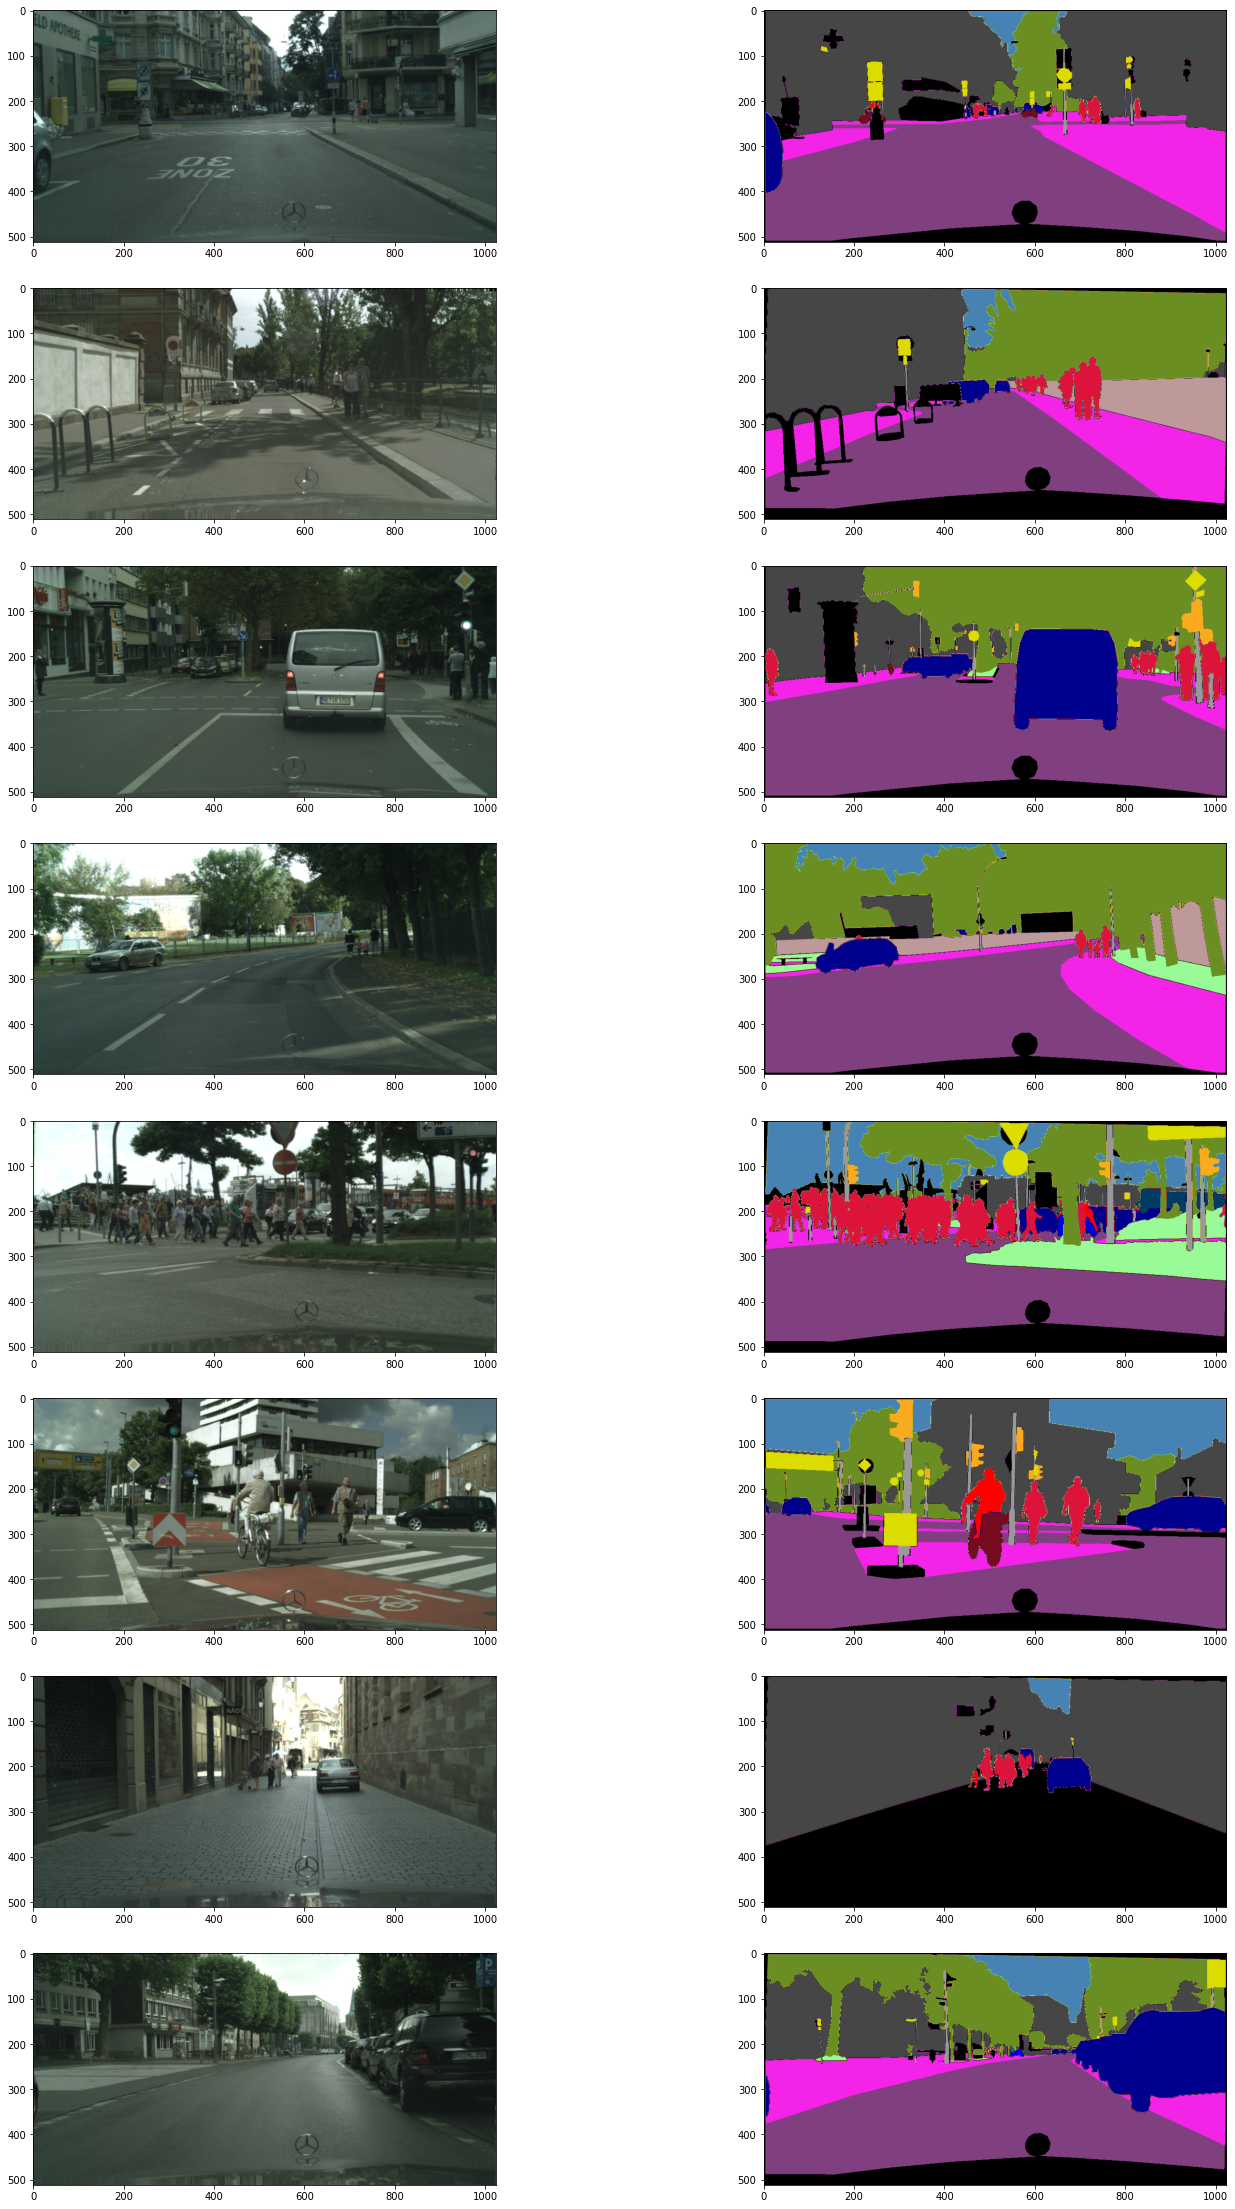

In [35]:
#'''
print (len(train_set))
examples = iter(train_set)
inputs, labels = examples.next()
print (inputs.shape, inputs.dtype, labels.shape, labels.dtype)
color_labels = label2color(labels, color_mapping_after_conversion)

fig,ax=plt.subplots(ncols=2,nrows=BATCH_SIZE,figsize=(24,5*BATCH_SIZE))
for current_batch in range(BATCH_SIZE):    
    ax[current_batch][0].imshow(transforms.ToPILImage()(inputs[current_batch].type(torch.FloatTensor)))
    ax[current_batch][1].imshow(transforms.ToPILImage()(255*color_labels[current_batch].type(torch.FloatTensor)))
#'''

In [35]:
def get_confusion_matrix(label, pred, size, num_class, ignore=-1):
    """
    Calcute the confusion matrix by given label and pred
    """
    label = label.detach()
    pred = pred.detach()
    output = pred.cpu().numpy().transpose(0, 2, 3, 1)
    seg_pred = np.asarray(np.argmax(output, axis=3), dtype=np.uint8)
    seg_gt = np.asarray(
    label.cpu().numpy()[:, :size[-2], :size[-1]], dtype=np.int)

    ignore_index = seg_gt != ignore
    seg_gt = seg_gt[ignore_index]
    seg_pred = seg_pred[ignore_index]

    index = (seg_gt * num_class + seg_pred).astype('int32')
    label_count = np.bincount(index)
    confusion_matrix = np.zeros((num_class, num_class))

    for i_label in range(num_class):
        for i_pred in range(num_class):
            cur_index = i_label * num_class + i_pred
            if cur_index < len(label_count):
                confusion_matrix[i_label,
                                 i_pred] = label_count[cur_index]
    return confusion_matrix

In [36]:
def validate_and_save(data, device):
    model = get_seg_model(HIGH_RESOLUTION_NET, DATASET)
    model.to(device)
    checkpoint = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    data_type = None
    tic = time.time()
    confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))
    with torch.no_grad():
        for batch_no, example in enumerate(tqdm.tqdm(data)):
            X, y, filename = None, None, None
            if (len(example) == 2):
                X, y = example
            elif  (len(example) == 3):
                X, y, filename = example
            y = refine_label_after_loader(y)
            if (data_type == None):
                data_type = checker(filename)
            X, y = X.to(device), y.to(device)
            logits = model(X)
            size = y.size()
            logits = F.upsample(input=logits, size=(size[-2], size[-1]), 
                                     mode='bilinear')
            filename = str(filename)
            pos = filename.rfind('/', 0, len(filename))
            name = filename[pos+1:-18]  
            predictions = torch.nn.functional.softmax(logits, dim=1)
            pred_labels = torch.argmax(predictions, dim=1) 
            pred_labels = pred_labels.float()
            if (data_type == 'Val Set'):
                confusion_matrix += get_confusion_matrix(y, logits, 
                                                     size, NUM_CLASSES, 255)
                path = os.path.join(VAL_PRED_LOCATION, "Prediction_Val")
                if not os.path.exists(path):
                    os.mkdir(path)
                colored_pred = label2color(pred_labels, color_mapping_after_conversion)
                save_as_images(colored_pred, path, name+"_prediction")
            elif (data_type == 'Test Set'):
                path = os.path.join(TEST_PRED_LOCATION, "Prediction_Test")
                if not os.path.exists(path):
                    os.mkdir(path)
                colored_pred = label2color(pred_labels, color_mapping_after_conversion)
                save_as_images(colored_pred, path, name+"_prediction")

    tac = time.time()
    elapsed=tac-tic
    
    if (data_type == 'Val Set'):
        print_msg2(data_type, elapsed)
        time.sleep(1)
        pos = confusion_matrix.sum(1)
        res = confusion_matrix.sum(0)
        tp = np.diag(confusion_matrix)
        IoU_array = (tp / np.maximum(1.0, pos + res - tp))
        IoU_array = np.multiply(IoU_array,100)
        mean_IoU = IoU_array.mean()
        print ("*"* 38)
        print(f'[ID] [   CLASS NAME   ] [Mean IOU %]')
        print ("*"* 38)
        for cls in range(NUM_CLASSES):
            print(f'[{cls:2d}] [{id2class_after_conversion[cls]:16}] [{IoU_array[cls]:3.6f}]')
        print ("*"* 38)
        print (f'          mIOU = {mean_IoU:3.4f}  %          ')
        return IoU_array, mean_IoU
    elif (data_type == 'Test Set'):
        print_msg3(data_type, elapsed)
        return None, None

In [37]:
def validate(data, device):
    model = get_seg_model(HIGH_RESOLUTION_NET, DATASET)
    model.to(device)
    checkpoint = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    data_type = None
    tic = time.time()
    confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))
    with torch.no_grad():
        for batch_no, example in enumerate(tqdm.tqdm(data)):
            X, y, filename = None, None, None
            if (len(example) == 2):
                X, y = example
            elif  (len(example) == 3):
                X, y, filename = example
            y = refine_label_after_loader(y)
            if (data_type == None):
                data_type = checker(filename)
            X, y = X.to(device), y.to(device)
            logits = model(X)
            size = y.size()
            logits = F.upsample(input=logits, size=(size[-2], size[-1]), 
                                     mode='bilinear')
            predictions = torch.nn.functional.softmax(logits, dim=1)
            pred_labels = torch.argmax(predictions, dim=1) 
            pred_labels = pred_labels.float()
            confusion_matrix += get_confusion_matrix(y, logits, 
                                                 size, NUM_CLASSES, 255)
        pos = confusion_matrix.sum(1)
        res = confusion_matrix.sum(0)
        tp = np.diag(confusion_matrix)
        IoU_array = (tp / np.maximum(1.0, pos + res - tp))
        IoU_array = np.multiply(IoU_array,100)
        mean_IoU = IoU_array.mean()
        tac = time.time()
        elapsed=tac-tic
        print_msg1(data_type, elapsed)
        return IoU_array, mean_IoU


In [38]:
def get_seg_model(HIGH_RESOLUTION_NET, DATASET):
    #model = HighResolutionNetv1(model_config=HIGH_RESOLUTION_NET, dataset_config=DATASET)
    model = HighResolutionNet(model_config=HIGH_RESOLUTION_NET, dataset_config=DATASET)
    model.init_weights(MODEL.PRETRAINED)
    return model

In [39]:
model = get_seg_model(HIGH_RESOLUTION_NET, DATASET)

In [40]:
class OhemCrossEntropy(nn.Module): 
    def __init__(self, ignore_label=-1, thres=0.7, 
        min_kept=100000, weight=None): 
        super(OhemCrossEntropy, self).__init__() 
        self.thresh = thres
        self.min_kept = max(1, min_kept)
        self.ignore_label = ignore_label 
        self.criterion = nn.CrossEntropyLoss(weight=weight, 
                                             ignore_index=ignore_label, 
                                             reduction='none') 
    def forward(self, score, target, **kwargs):
        ph, pw = score.size(2), score.size(3)
        h, w = target.size(1), target.size(2)
        if ph != h or pw != w:
            score = F.upsample(input=score, size=(h, w), mode='bilinear')
        pred = F.softmax(score, dim=1)
        pixel_losses = self.criterion(score, target).contiguous().view(-1)
        mask = target.contiguous().view(-1) != self.ignore_label         
        tmp_target = target.clone() 
        tmp_target[tmp_target == self.ignore_label] = 0 
        pred = pred.gather(1, tmp_target.unsqueeze(1)) 
        pred, ind = pred.contiguous().view(-1,)[mask].contiguous().sort()
        min_value = pred[min(self.min_kept, pred.numel() - 1)] 
        threshold = max(min_value, self.thresh) 
        pixel_losses = pixel_losses[mask][ind]
        pixel_losses = pixel_losses[pred < threshold] 
        return pixel_losses.mean()

In [41]:
class CrossEntropy(nn.Module):
    def __init__(self, ignore_label=-1, weight=None):
        super(CrossEntropy, self).__init__()
        self.ignore_label = ignore_label
        self.criterion = nn.CrossEntropyLoss(weight=weight, 
                                             ignore_index=ignore_label)
    def forward(self, score, target):
        ph, pw = score.size(2), score.size(3)
        h, w = target.size(1), target.size(2)
        if ph != h or pw != w:
            score = F.upsample(
                    input=score, size=(h, w), mode='bilinear')
        loss = self.criterion(score, target)
        return loss

In [42]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, 
                      weight_decay=0.0005, nesterov=False)
criterion = CrossEntropy(weight=class_weights, ignore_label=255)

In [43]:
def step_lr_scheduler(base_lr, step_size=10, factor=0.1, 
                      set_new_lr = False, new_lr = 0.01):
    lr = base_lr
    if ((GLOBAL_EPOCH_COUNTER-1)%step_size == 0 and GLOBAL_EPOCH_COUNTER != 1):
        lr = max(lr * factor, 1e-7)
    if (set_new_lr):
        lr = new_lr
    #print ("Inside step function: Global Epoch= ", GLOBAL_EPOCH_COUNTER, " lr= ", lr)
    return lr

In [44]:
def step_lr_assigner(optimizer, lr):
    optimizer.param_groups[0]['lr'] = lr
    return optimizer

In [45]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [46]:
def train_model(data, model, device, criterion, optimizer, 
                step_size = 10, set_new_lr = False, new_lr = 0.01,
                max_iters = MAX_ITER, base_lr=0.01, number_of_epochs = EPOCHS):
    global BEST_mIOU
    global GLOBAL_EPOCH_COUNTER
    lr = base_lr
    model.to(device)
    if os.path.exists(MODEL_PATH):
        print (' ======= Found Existing Model and Loaded ======= ')
        checkpoint = torch.load(MODEL_PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        lr = checkpoint['learning_rate']
        with open(Global_Epoch_Counter_DIR, 'r')as read_obj:
            csv_reader = reader(read_obj)
            for line in csv_reader:
                GLOBAL_EPOCH_COUNTER = int(line[0])
    else:
        print (' =======   Training for the first time   ======= ')
    
    print_param(count_num_param(model))
    time.sleep(5)
    model.train()
    num_of_batches = len(data)
    max_train_iters = num_of_batches*number_of_epochs
    cur_iters = 0
    TRAIN_LOSS = []
    TRAIN_mIOU = []
    TRAIN_LR = []
    TRAIN_MODEL_UPDATE = []
    for epoch in tqdm.tqdm(range(number_of_epochs)):
        GLOBAL_EPOCH_COUNTER += 1
        lr = step_lr_scheduler(lr, step_size = step_size, 
                               set_new_lr = set_new_lr, new_lr = new_lr)
        confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))
        loss_for_current_epoch = 0
        epoch_tic = time.time()
        #print ('*'* len("Iteration [      /      ], Epoch  [     ], Batch [     ], Current Batch Loss:           , Learning Rate:           "))
        utility_time = 0
        for batch_number, example in enumerate(data):
            X, y, filename = None, None, None
            if (len(example) == 2):
                X, y = example
            elif  (len(example) == 3):
                X, y, filename = example
            y = refine_label_after_loader(y)
            X, y = X.to(device), y.to(device)
            logits = model(X)
            #print (X.shape, X.dtype, X.device, y.shape, y.dtype, y.device,  
            #       logits.shape, logits.dtype, logits.device)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            TRAIN_LOSS.append(loss.item())
            utility_tic = time.time()
            size = y.size()
            logits = F.upsample(input=logits, size=(size[-2], size[-1]), 
                                     mode='bilinear')
            confusion_matrix += get_confusion_matrix(y, logits, 
                                                 size, NUM_CLASSES, 255)
            cur_iters = (epoch*num_of_batches)+(batch_number+1)
            optimizer = step_lr_assigner(optimizer, lr)
            cur_lr = get_lr(optimizer)
            TRAIN_LR.append(cur_lr)
            utility_tac = time.time()
            utility_time += utility_tac - utility_tic
            if ((batch_number+1) == 1 or (batch_number+1)%150 == 0):
                print (f'Iteration [{cur_iters:6d}/{max_train_iters:6d}], Epoch  [{(epoch+1):4d}], Batch  [{(batch_number+1):4d}], Current Batch Loss: {loss.item():1.8f}, Learning Rate: {cur_lr:1.8f}')
        #print ('*'* len("Iteration [      /      ], Epoch  [     ], Batch [     ], Current Batch Loss:           , Learning Rate:           "))
        
        loss_for_current_epoch = loss.item()
        pos = confusion_matrix.sum(1)
        res = confusion_matrix.sum(0)
        tp = np.diag(confusion_matrix)
        IoU_array = (tp / np.maximum(1.0, pos + res - tp))
        current_mIOU = 100.0*IoU_array.mean()
        TRAIN_mIOU.append(current_mIOU)
        epoch_tac = time.time()
        epoch_time = epoch_tac - epoch_tic
        actual_training_time = epoch_time - utility_time
        if (current_mIOU > BEST_mIOU):
            BEST_mIOU = current_mIOU
            print (f'**** mIOU updated at epoch #{(epoch+1):2d} ****')
            print (f'** Current mIOU =  {current_mIOU:3.4f}, Best mIOU =  {BEST_mIOU:3.4f} **')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optim_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'mIOU': current_mIOU,
                'learning_rate': lr,
                'training_time': actual_training_time,
                'loss_values': loss_for_current_epoch
            }, MODEL_PATH)
            TRAIN_MODEL_UPDATE.append(1)
        else:
            print (f'** mIOU not updated at epoch #{(epoch+1):2d} **')
            TRAIN_MODEL_UPDATE.append(0)
        print ('*'* len("Epoch  [   /   ], Epoch Loss:           , Training Time:         s"))
        print (f'Epoch  [{(epoch+1):3d}/{number_of_epochs:3d}], Epoch Loss: {loss.item():1.8f}, Training Time: {actual_training_time:4.2f} s')
        print ('*'* len("Epoch  [   /   ], Epoch Loss:           , Training Time:         s"))
        
    with open(TRAIN_LOSS_DIR, 'a') as csvfile:
        for current_loss in TRAIN_LOSS:
            csvfile.write(str(current_loss) + '\n')
    with open(TRAIN_LR_DIR, 'a') as csvfile:
        for current_lr in TRAIN_LR:
            csvfile.write(str(current_lr) + '\n')
    with open(TRAIN_meanIOU_DIR, 'a') as csvfile:
        for current_miou in TRAIN_mIOU:
            csvfile.write(str(current_miou) + '\n')
    with open(TRAIN_MODEL_UPDATE_DIR, 'a') as csvfile:
        for current_model_update in TRAIN_MODEL_UPDATE:
            csvfile.write(str(current_model_update) + '\n')
    if (os.path.exists(Global_Epoch_Counter_DIR)):
        os.remove(Global_Epoch_Counter_DIR)
    with open(Global_Epoch_Counter_DIR, 'a') as csvfile:
        csvfile.write(str(GLOBAL_EPOCH_COUNTER) + '\n')

In [ ]:
######################## Training Phase1 ########################

In [48]:
train_model(train_set, model, device_rtx3090, criterion, optimizer, base_lr=0.01, number_of_epochs = 20)

 =======   Training for the first time   ======= 
                     ######################################                     
                     ## Number of parameters: 65,859,379 ##                     
                     ######################################                     


  0%|          | 0/20 [00:00<?, ?it/s]

*******************************************************************************************************************


/home/sourajit/.local/lib/python3.6/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/sourajit/.local/lib/python3.6/site-packages/torch/nn/functional.py:3325: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Iteration [     1/  7440], Epoch  [   1], Batch  [   1], Current Batch Loss: 2.93901873, Learning Rate: 0.01000000
Iteration [   100/  7440], Epoch  [   1], Batch  [ 100], Current Batch Loss: 1.02518654, Learning Rate: 0.01000000
Iteration [   200/  7440], Epoch  [   1], Batch  [ 200], Current Batch Loss: 0.84199405, Learning Rate: 0.01000000
Iteration [   300/  7440], Epoch  [   1], Batch  [ 300], Current Batch Loss: 1.22628546, Learning Rate: 0.01000000
*******************************************************************************************************************
***************** mIOU updated *****************
***************** at epoch # 1, *****************
*********** Current mIOU =  17.0587, ***********
*********** Best mIOU =  17.0587, ***********
***************** mIOU updated *****************


  5%|▌         | 1/20 [19:40<6:13:52, 1180.67s/it]

******************************************************************
Epoch  [  1/ 20], Epoch Loss: 0.74470699, Training Time: 1030.65 s
******************************************************************
*******************************************************************************************************************
Iteration [   373/  7440], Epoch  [   2], Batch  [   1], Current Batch Loss: 0.77329999, Learning Rate: 0.01000000
Iteration [   472/  7440], Epoch  [   2], Batch  [ 100], Current Batch Loss: 0.82902253, Learning Rate: 0.01000000
Iteration [   572/  7440], Epoch  [   2], Batch  [ 200], Current Batch Loss: 0.81426919, Learning Rate: 0.01000000
Iteration [   672/  7440], Epoch  [   2], Batch  [ 300], Current Batch Loss: 0.95654279, Learning Rate: 0.01000000
*******************************************************************************************************************
***************** mIOU updated *****************
***************** at epoch # 2, *****************
********

 10%|█         | 2/20 [39:33<5:56:24, 1188.02s/it]

******************************************************************
Epoch  [  2/ 20], Epoch Loss: 0.60621041, Training Time: 1032.26 s
******************************************************************
*******************************************************************************************************************
Iteration [   745/  7440], Epoch  [   3], Batch  [   1], Current Batch Loss: 0.60214114, Learning Rate: 0.01000000
Iteration [   844/  7440], Epoch  [   3], Batch  [ 100], Current Batch Loss: 0.70553601, Learning Rate: 0.01000000
Iteration [   944/  7440], Epoch  [   3], Batch  [ 200], Current Batch Loss: 0.65245128, Learning Rate: 0.01000000
Iteration [  1044/  7440], Epoch  [   3], Batch  [ 300], Current Batch Loss: 0.59520066, Learning Rate: 0.01000000
*******************************************************************************************************************
***************** mIOU updated *****************
***************** at epoch # 3, *****************
********

 15%|█▌        | 3/20 [59:25<5:37:07, 1189.85s/it]

******************************************************************
Epoch  [  3/ 20], Epoch Loss: 0.62036717, Training Time: 1035.10 s
******************************************************************
*******************************************************************************************************************
Iteration [  1117/  7440], Epoch  [   4], Batch  [   1], Current Batch Loss: 0.57147586, Learning Rate: 0.01000000
Iteration [  1216/  7440], Epoch  [   4], Batch  [ 100], Current Batch Loss: 0.64219612, Learning Rate: 0.01000000
Iteration [  1316/  7440], Epoch  [   4], Batch  [ 200], Current Batch Loss: 0.48887342, Learning Rate: 0.01000000
Iteration [  1416/  7440], Epoch  [   4], Batch  [ 300], Current Batch Loss: 0.43689305, Learning Rate: 0.01000000
*******************************************************************************************************************
***************** mIOU updated *****************
***************** at epoch # 4, *****************
********

 20%|██        | 4/20 [1:22:01<5:34:47, 1255.48s/it]

******************************************************************
Epoch  [  4/ 20], Epoch Loss: 0.58509266, Training Time: 1032.75 s
******************************************************************
*******************************************************************************************************************
Iteration [  1489/  7440], Epoch  [   5], Batch  [   1], Current Batch Loss: 0.59358090, Learning Rate: 0.01000000
Iteration [  1588/  7440], Epoch  [   5], Batch  [ 100], Current Batch Loss: 0.46008143, Learning Rate: 0.01000000
Iteration [  1688/  7440], Epoch  [   5], Batch  [ 200], Current Batch Loss: 0.45006585, Learning Rate: 0.01000000
Iteration [  1788/  7440], Epoch  [   5], Batch  [ 300], Current Batch Loss: 0.47784668, Learning Rate: 0.01000000
*******************************************************************************************************************
***************** mIOU updated *****************
***************** at epoch # 5, *****************
********

 25%|██▌       | 5/20 [1:43:45<5:18:11, 1272.74s/it]

******************************************************************
Epoch  [  5/ 20], Epoch Loss: 0.52324814, Training Time: 1033.80 s
******************************************************************
*******************************************************************************************************************
Iteration [  1861/  7440], Epoch  [   6], Batch  [   1], Current Batch Loss: 0.47237015, Learning Rate: 0.01000000
Iteration [  1960/  7440], Epoch  [   6], Batch  [ 100], Current Batch Loss: 0.59748614, Learning Rate: 0.01000000
Iteration [  2060/  7440], Epoch  [   6], Batch  [ 200], Current Batch Loss: 0.40255028, Learning Rate: 0.01000000
Iteration [  2160/  7440], Epoch  [   6], Batch  [ 300], Current Batch Loss: 0.44760418, Learning Rate: 0.01000000
*******************************************************************************************************************
***************** mIOU updated *****************
***************** at epoch # 6, *****************
********

 30%|███       | 6/20 [2:05:01<4:57:13, 1273.81s/it]

******************************************************************
Epoch  [  6/ 20], Epoch Loss: 0.35671109, Training Time: 1031.89 s
******************************************************************
*******************************************************************************************************************
Iteration [  2233/  7440], Epoch  [   7], Batch  [   1], Current Batch Loss: 0.40791816, Learning Rate: 0.01000000
Iteration [  2332/  7440], Epoch  [   7], Batch  [ 100], Current Batch Loss: 0.51079923, Learning Rate: 0.01000000
Iteration [  2432/  7440], Epoch  [   7], Batch  [ 200], Current Batch Loss: 0.54667062, Learning Rate: 0.01000000
Iteration [  2532/  7440], Epoch  [   7], Batch  [ 300], Current Batch Loss: 0.38327494, Learning Rate: 0.01000000
*******************************************************************************************************************
***************** mIOU updated *****************
***************** at epoch # 7, *****************
********

 35%|███▌      | 7/20 [2:25:16<4:31:51, 1254.75s/it]

******************************************************************
Epoch  [  7/ 20], Epoch Loss: 0.49859357, Training Time: 1032.64 s
******************************************************************
*******************************************************************************************************************
Iteration [  2605/  7440], Epoch  [   8], Batch  [   1], Current Batch Loss: 0.45534500, Learning Rate: 0.01000000
Iteration [  2704/  7440], Epoch  [   8], Batch  [ 100], Current Batch Loss: 0.41038740, Learning Rate: 0.01000000
Iteration [  2804/  7440], Epoch  [   8], Batch  [ 200], Current Batch Loss: 0.41574612, Learning Rate: 0.01000000
Iteration [  2904/  7440], Epoch  [   8], Batch  [ 300], Current Batch Loss: 0.49995008, Learning Rate: 0.01000000
*******************************************************************************************************************
***************** mIOU updated *****************
***************** at epoch # 8, *****************
********

 40%|████      | 8/20 [2:45:59<4:10:09, 1250.80s/it]

******************************************************************
Epoch  [  8/ 20], Epoch Loss: 0.37058118, Training Time: 1032.42 s
******************************************************************
*******************************************************************************************************************
Iteration [  2977/  7440], Epoch  [   9], Batch  [   1], Current Batch Loss: 0.59452856, Learning Rate: 0.01000000
Iteration [  3076/  7440], Epoch  [   9], Batch  [ 100], Current Batch Loss: 0.49405944, Learning Rate: 0.01000000
Iteration [  3176/  7440], Epoch  [   9], Batch  [ 200], Current Batch Loss: 0.42083338, Learning Rate: 0.01000000
Iteration [  3276/  7440], Epoch  [   9], Batch  [ 300], Current Batch Loss: 0.27252185, Learning Rate: 0.01000000
*******************************************************************************************************************
***************** mIOU updated *****************
***************** at epoch # 9, *****************
********

 45%|████▌     | 9/20 [3:06:03<3:46:39, 1236.35s/it]

******************************************************************
Epoch  [  9/ 20], Epoch Loss: 0.35871053, Training Time: 1032.27 s
******************************************************************
*******************************************************************************************************************
Iteration [  3349/  7440], Epoch  [  10], Batch  [   1], Current Batch Loss: 0.35698876, Learning Rate: 0.01000000
Iteration [  3448/  7440], Epoch  [  10], Batch  [ 100], Current Batch Loss: 0.36133823, Learning Rate: 0.00000010
Iteration [  3548/  7440], Epoch  [  10], Batch  [ 200], Current Batch Loss: 0.37055817, Learning Rate: 0.00000010
Iteration [  3648/  7440], Epoch  [  10], Batch  [ 300], Current Batch Loss: 0.34454781, Learning Rate: 0.00000010
*******************************************************************************************************************
***************** mIOU updated *****************
***************** at epoch #10, *****************
********

 50%|█████     | 10/20 [3:25:47<3:23:21, 1220.18s/it]

******************************************************************
Epoch  [ 10/ 20], Epoch Loss: 0.35607710, Training Time: 1032.56 s
******************************************************************
*******************************************************************************************************************
Iteration [  3721/  7440], Epoch  [  11], Batch  [   1], Current Batch Loss: 0.38810712, Learning Rate: 0.00000010
Iteration [  3820/  7440], Epoch  [  11], Batch  [ 100], Current Batch Loss: 0.29126054, Learning Rate: 0.00000010
Iteration [  3920/  7440], Epoch  [  11], Batch  [ 200], Current Batch Loss: 0.28389901, Learning Rate: 0.00000010
Iteration [  4020/  7440], Epoch  [  11], Batch  [ 300], Current Batch Loss: 0.35570279, Learning Rate: 0.00000010
*******************************************************************************************************************
***************** mIOU updated *****************
***************** at epoch #11, *****************
********

 55%|█████▌    | 11/20 [3:48:02<3:08:18, 1255.39s/it]

******************************************************************
Epoch  [ 11/ 20], Epoch Loss: 0.29163164, Training Time: 1032.72 s
******************************************************************
*******************************************************************************************************************
Iteration [  4093/  7440], Epoch  [  12], Batch  [   1], Current Batch Loss: 0.35385540, Learning Rate: 0.00000010
Iteration [  4192/  7440], Epoch  [  12], Batch  [ 100], Current Batch Loss: 0.32732645, Learning Rate: 0.00000010
Iteration [  4292/  7440], Epoch  [  12], Batch  [ 200], Current Batch Loss: 0.41878724, Learning Rate: 0.00000010
Iteration [  4392/  7440], Epoch  [  12], Batch  [ 300], Current Batch Loss: 0.36695194, Learning Rate: 0.00000010


 60%|██████    | 12/20 [4:07:40<2:44:14, 1231.79s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [ 12/ 20], Epoch Loss: 0.33192292, Training Time: 1032.89 s
******************************************************************
*******************************************************************************************************************
Iteration [  4465/  7440], Epoch  [  13], Batch  [   1], Current Batch Loss: 0.38848364, Learning Rate: 0.00000010
Iteration [  4564/  7440], Epoch  [  13], Batch  [ 100], Current Batch Loss: 0.31655335, Learning Rate: 0.00000010
Iteration [  4664/  7440], Epoch  [  13], Batch  [ 200], Current Batch Loss: 0.53322577, Learning Rate: 0.00000010
Iteration [  4764/  7440], Epoch  [  13], Batch  [ 300], Current Batch Loss: 0.39319769, Learning Rate: 0.00000010


 65%|██████▌   | 13/20 [4:27:19<2:21:50, 1215.80s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [ 13/ 20], Epoch Loss: 0.29414698, Training Time: 1032.90 s
******************************************************************
*******************************************************************************************************************
Iteration [  4837/  7440], Epoch  [  14], Batch  [   1], Current Batch Loss: 0.56448889, Learning Rate: 0.00000010
Iteration [  4936/  7440], Epoch  [  14], Batch  [ 100], Current Batch Loss: 0.31083465, Learning Rate: 0.00000010
Iteration [  5036/  7440], Epoch  [  14], Batch  [ 200], Current Batch Loss: 0.41116408, Learning Rate: 0.00000010
Iteration [  5136/  7440], Epoch  [  14], Batch  [ 300], Current Batch Loss: 0.34427831, Learning Rate: 0.00000010
***********************************************************************************************************

 70%|███████   | 14/20 [4:46:58<2:00:27, 1204.61s/it]

******************************************************************
Epoch  [ 14/ 20], Epoch Loss: 0.30907676, Training Time: 1033.49 s
******************************************************************
*******************************************************************************************************************
Iteration [  5209/  7440], Epoch  [  15], Batch  [   1], Current Batch Loss: 0.34252346, Learning Rate: 0.00000010
Iteration [  5308/  7440], Epoch  [  15], Batch  [ 100], Current Batch Loss: 0.33664927, Learning Rate: 0.00000010
Iteration [  5408/  7440], Epoch  [  15], Batch  [ 200], Current Batch Loss: 0.42516506, Learning Rate: 0.00000010
Iteration [  5508/  7440], Epoch  [  15], Batch  [ 300], Current Batch Loss: 0.39659762, Learning Rate: 0.00000010


 75%|███████▌  | 15/20 [5:06:35<1:39:41, 1196.38s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [ 15/ 20], Epoch Loss: 0.43969703, Training Time: 1032.87 s
******************************************************************
*******************************************************************************************************************
Iteration [  5581/  7440], Epoch  [  16], Batch  [   1], Current Batch Loss: 0.42815101, Learning Rate: 0.00000010
Iteration [  5680/  7440], Epoch  [  16], Batch  [ 100], Current Batch Loss: 0.31375080, Learning Rate: 0.00000010
Iteration [  5780/  7440], Epoch  [  16], Batch  [ 200], Current Batch Loss: 0.35382399, Learning Rate: 0.00000010
Iteration [  5880/  7440], Epoch  [  16], Batch  [ 300], Current Batch Loss: 0.39262152, Learning Rate: 0.00000010


 80%|████████  | 16/20 [5:26:14<1:19:23, 1190.95s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [ 16/ 20], Epoch Loss: 0.34995067, Training Time: 1033.15 s
******************************************************************
*******************************************************************************************************************
Iteration [  5953/  7440], Epoch  [  17], Batch  [   1], Current Batch Loss: 0.46360961, Learning Rate: 0.00000010
Iteration [  6052/  7440], Epoch  [  17], Batch  [ 100], Current Batch Loss: 0.36882728, Learning Rate: 0.00000010
Iteration [  6152/  7440], Epoch  [  17], Batch  [ 200], Current Batch Loss: 0.33374783, Learning Rate: 0.00000010
Iteration [  6252/  7440], Epoch  [  17], Batch  [ 300], Current Batch Loss: 0.36300799, Learning Rate: 0.00000010


 85%|████████▌ | 17/20 [5:45:52<59:21, 1187.20s/it]  

*******************************************************************************************************************
******************************************************************
Epoch  [ 17/ 20], Epoch Loss: 0.35256979, Training Time: 1033.46 s
******************************************************************
*******************************************************************************************************************
Iteration [  6325/  7440], Epoch  [  18], Batch  [   1], Current Batch Loss: 0.40597433, Learning Rate: 0.00000010
Iteration [  6424/  7440], Epoch  [  18], Batch  [ 100], Current Batch Loss: 0.39857405, Learning Rate: 0.00000010
Iteration [  6524/  7440], Epoch  [  18], Batch  [ 200], Current Batch Loss: 0.38360357, Learning Rate: 0.00000010
Iteration [  6624/  7440], Epoch  [  18], Batch  [ 300], Current Batch Loss: 0.41668966, Learning Rate: 0.00000010


 90%|█████████ | 18/20 [6:05:31<39:29, 1184.82s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [ 18/ 20], Epoch Loss: 0.30416667, Training Time: 1034.73 s
******************************************************************
*******************************************************************************************************************
Iteration [  6697/  7440], Epoch  [  19], Batch  [   1], Current Batch Loss: 0.33912063, Learning Rate: 0.00000010
Iteration [  6796/  7440], Epoch  [  19], Batch  [ 100], Current Batch Loss: 0.31359512, Learning Rate: 0.00000010
Iteration [  6896/  7440], Epoch  [  19], Batch  [ 200], Current Batch Loss: 0.43858054, Learning Rate: 0.00000010
Iteration [  6996/  7440], Epoch  [  19], Batch  [ 300], Current Batch Loss: 0.45912459, Learning Rate: 0.00000010


 95%|█████████▌| 19/20 [6:25:14<19:44, 1184.05s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [ 19/ 20], Epoch Loss: 0.35241461, Training Time: 1035.92 s
******************************************************************
*******************************************************************************************************************
Iteration [  7069/  7440], Epoch  [  20], Batch  [   1], Current Batch Loss: 0.47970396, Learning Rate: 0.00000010
Iteration [  7168/  7440], Epoch  [  20], Batch  [ 100], Current Batch Loss: 0.34572691, Learning Rate: 0.00000010
Iteration [  7268/  7440], Epoch  [  20], Batch  [ 200], Current Batch Loss: 0.40996951, Learning Rate: 0.00000010
Iteration [  7368/  7440], Epoch  [  20], Batch  [ 300], Current Batch Loss: 0.34864601, Learning Rate: 0.00000010


100%|██████████| 20/20 [6:44:55<00:00, 1214.79s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [ 20/ 20], Epoch Loss: 0.48851109, Training Time: 1036.20 s
******************************************************************


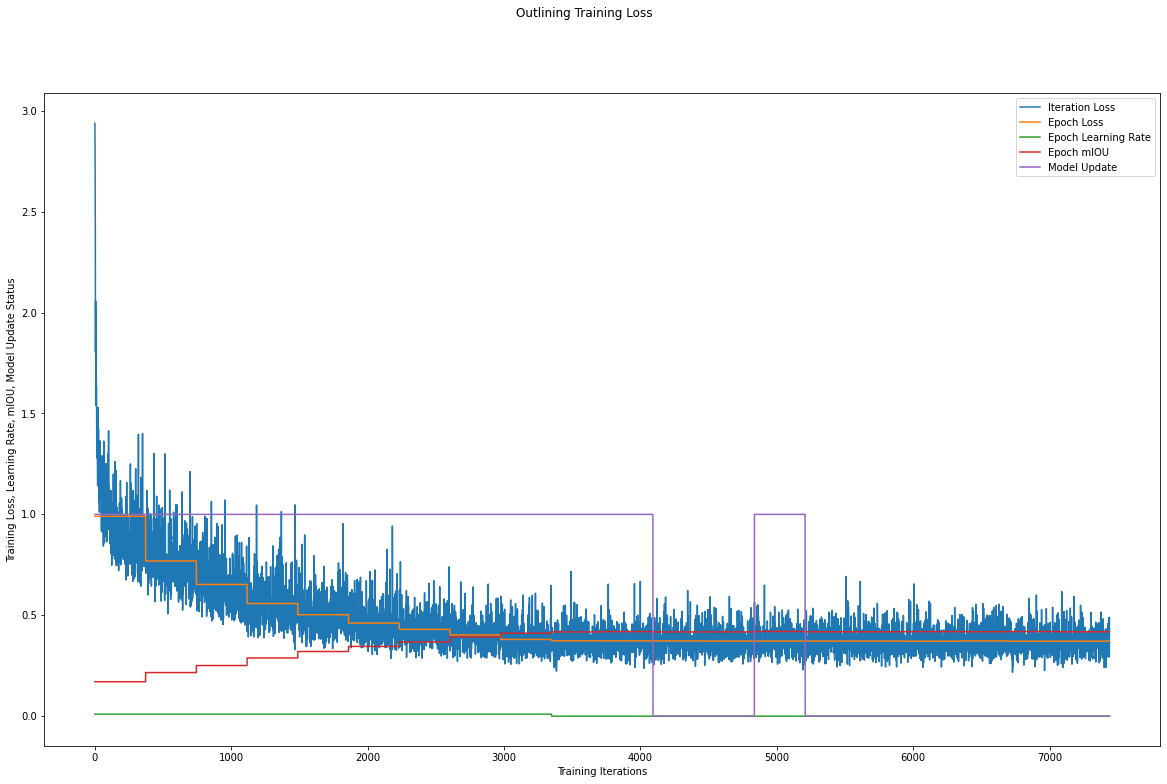

In [49]:
plot_training_performance()

In [51]:
train_model(train_set, model, device_rtx3090, criterion, optimizer, base_lr=0.01, number_of_epochs = 15)

 ======= Found Existing Model and Loaded ======= 
                     ######################################                     
                     ## Number of parameters: 65,859,379 ##                     
                     ######################################                     


  0%|          | 0/15 [00:00<?, ?it/s]

*******************************************************************************************************************
Iteration [     1/  5580], Epoch  [   1], Batch  [   1], Current Batch Loss: 0.32244095, Learning Rate: 0.00000010
Iteration [   100/  5580], Epoch  [   1], Batch  [ 100], Current Batch Loss: 0.37441486, Learning Rate: 0.00000010
Iteration [   200/  5580], Epoch  [   1], Batch  [ 200], Current Batch Loss: 0.33700228, Learning Rate: 0.00000010
Iteration [   300/  5580], Epoch  [   1], Batch  [ 300], Current Batch Loss: 0.25578985, Learning Rate: 0.00000010


  7%|▋         | 1/15 [21:45<5:04:42, 1305.86s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [  1/ 15], Epoch Loss: 0.34751609, Training Time: 1032.81 s
******************************************************************
*******************************************************************************************************************
Iteration [   373/  5580], Epoch  [   2], Batch  [   1], Current Batch Loss: 0.35070324, Learning Rate: 0.00000010
Iteration [   472/  5580], Epoch  [   2], Batch  [ 100], Current Batch Loss: 0.34726217, Learning Rate: 0.00000010
Iteration [   572/  5580], Epoch  [   2], Batch  [ 200], Current Batch Loss: 0.29743770, Learning Rate: 0.00000010
Iteration [   672/  5580], Epoch  [   2], Batch  [ 300], Current Batch Loss: 0.38232598, Learning Rate: 0.00000010


 13%|█▎        | 2/15 [41:19<4:26:05, 1228.08s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [  2/ 15], Epoch Loss: 0.36666134, Training Time: 1032.81 s
******************************************************************
*******************************************************************************************************************
Iteration [   745/  5580], Epoch  [   3], Batch  [   1], Current Batch Loss: 0.33459762, Learning Rate: 0.00000010
Iteration [   844/  5580], Epoch  [   3], Batch  [ 100], Current Batch Loss: 0.29401124, Learning Rate: 0.00000010
Iteration [   944/  5580], Epoch  [   3], Batch  [ 200], Current Batch Loss: 0.36415419, Learning Rate: 0.00000010
Iteration [  1044/  5580], Epoch  [   3], Batch  [ 300], Current Batch Loss: 0.38733593, Learning Rate: 0.00000010


 20%|██        | 3/15 [1:00:56<4:00:55, 1204.66s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [  3/ 15], Epoch Loss: 0.27453136, Training Time: 1032.60 s
******************************************************************
*******************************************************************************************************************
Iteration [  1117/  5580], Epoch  [   4], Batch  [   1], Current Batch Loss: 0.43214190, Learning Rate: 0.00000010
Iteration [  1216/  5580], Epoch  [   4], Batch  [ 100], Current Batch Loss: 0.38493410, Learning Rate: 0.00000010
Iteration [  1316/  5580], Epoch  [   4], Batch  [ 200], Current Batch Loss: 0.36106750, Learning Rate: 0.00000010
Iteration [  1416/  5580], Epoch  [   4], Batch  [ 300], Current Batch Loss: 0.48018733, Learning Rate: 0.00000010


 27%|██▋       | 4/15 [1:20:33<3:38:51, 1193.75s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [  4/ 15], Epoch Loss: 0.36388621, Training Time: 1032.44 s
******************************************************************
*******************************************************************************************************************
Iteration [  1489/  5580], Epoch  [   5], Batch  [   1], Current Batch Loss: 0.37737074, Learning Rate: 0.00000010
Iteration [  1588/  5580], Epoch  [   5], Batch  [ 100], Current Batch Loss: 0.33503568, Learning Rate: 0.00000010
Iteration [  1688/  5580], Epoch  [   5], Batch  [ 200], Current Batch Loss: 0.36429927, Learning Rate: 0.00000010
Iteration [  1788/  5580], Epoch  [   5], Batch  [ 300], Current Batch Loss: 0.36050519, Learning Rate: 0.00000010


 33%|███▎      | 5/15 [1:40:12<3:18:06, 1188.66s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [  5/ 15], Epoch Loss: 0.47963664, Training Time: 1032.35 s
******************************************************************
*******************************************************************************************************************
Iteration [  1861/  5580], Epoch  [   6], Batch  [   1], Current Batch Loss: 0.37420902, Learning Rate: 0.00000010
Iteration [  1960/  5580], Epoch  [   6], Batch  [ 100], Current Batch Loss: 0.45850772, Learning Rate: 0.00000010
Iteration [  2060/  5580], Epoch  [   6], Batch  [ 200], Current Batch Loss: 0.30523911, Learning Rate: 0.00000010
Iteration [  2160/  5580], Epoch  [   6], Batch  [ 300], Current Batch Loss: 0.40932515, Learning Rate: 0.00000010


 40%|████      | 6/15 [1:59:50<2:57:44, 1184.95s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [  6/ 15], Epoch Loss: 0.25682995, Training Time: 1032.53 s
******************************************************************
*******************************************************************************************************************
Iteration [  2233/  5580], Epoch  [   7], Batch  [   1], Current Batch Loss: 0.36531040, Learning Rate: 0.00000010
Iteration [  2332/  5580], Epoch  [   7], Batch  [ 100], Current Batch Loss: 0.39282483, Learning Rate: 0.00000010
Iteration [  2432/  5580], Epoch  [   7], Batch  [ 200], Current Batch Loss: 0.42360410, Learning Rate: 0.00000010
Iteration [  2532/  5580], Epoch  [   7], Batch  [ 300], Current Batch Loss: 0.37196600, Learning Rate: 0.00000010


 47%|████▋     | 7/15 [2:19:32<2:37:50, 1183.78s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [  7/ 15], Epoch Loss: 0.39852285, Training Time: 1032.57 s
******************************************************************
*******************************************************************************************************************
Iteration [  2605/  5580], Epoch  [   8], Batch  [   1], Current Batch Loss: 0.30453593, Learning Rate: 0.00000010
Iteration [  2704/  5580], Epoch  [   8], Batch  [ 100], Current Batch Loss: 0.42301199, Learning Rate: 0.00000010
Iteration [  2804/  5580], Epoch  [   8], Batch  [ 200], Current Batch Loss: 0.47438067, Learning Rate: 0.00000010
Iteration [  2904/  5580], Epoch  [   8], Batch  [ 300], Current Batch Loss: 0.29972059, Learning Rate: 0.00000010


 53%|█████▎    | 8/15 [2:39:10<2:17:54, 1182.02s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [  8/ 15], Epoch Loss: 0.34523189, Training Time: 1032.35 s
******************************************************************
*******************************************************************************************************************
Iteration [  2977/  5580], Epoch  [   9], Batch  [   1], Current Batch Loss: 0.42617097, Learning Rate: 0.00000010
Iteration [  3076/  5580], Epoch  [   9], Batch  [ 100], Current Batch Loss: 0.33299977, Learning Rate: 0.00000010
Iteration [  3176/  5580], Epoch  [   9], Batch  [ 200], Current Batch Loss: 0.37515226, Learning Rate: 0.00000010
Iteration [  3276/  5580], Epoch  [   9], Batch  [ 300], Current Batch Loss: 0.27248186, Learning Rate: 0.00000010


 60%|██████    | 9/15 [2:58:49<1:58:06, 1181.03s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [  9/ 15], Epoch Loss: 0.40333936, Training Time: 1032.40 s
******************************************************************
*******************************************************************************************************************
Iteration [  3349/  5580], Epoch  [  10], Batch  [   1], Current Batch Loss: 0.40641305, Learning Rate: 0.00000010
Iteration [  3448/  5580], Epoch  [  10], Batch  [ 100], Current Batch Loss: 0.30863556, Learning Rate: 0.00000010
Iteration [  3548/  5580], Epoch  [  10], Batch  [ 200], Current Batch Loss: 0.32696691, Learning Rate: 0.00000010
Iteration [  3648/  5580], Epoch  [  10], Batch  [ 300], Current Batch Loss: 0.63434780, Learning Rate: 0.00000010


 67%|██████▋   | 10/15 [3:18:25<1:38:18, 1179.69s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [ 10/ 15], Epoch Loss: 0.30956519, Training Time: 1032.37 s
******************************************************************
*******************************************************************************************************************
Iteration [  3721/  5580], Epoch  [  11], Batch  [   1], Current Batch Loss: 0.39389014, Learning Rate: 0.00000010
Iteration [  3820/  5580], Epoch  [  11], Batch  [ 100], Current Batch Loss: 0.42756280, Learning Rate: 0.00000010
Iteration [  3920/  5580], Epoch  [  11], Batch  [ 200], Current Batch Loss: 0.35004410, Learning Rate: 0.00000010
Iteration [  4020/  5580], Epoch  [  11], Batch  [ 300], Current Batch Loss: 0.43182784, Learning Rate: 0.00000010


 73%|███████▎  | 11/15 [3:38:00<1:18:32, 1178.10s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [ 11/ 15], Epoch Loss: 0.44627145, Training Time: 1031.92 s
******************************************************************
*******************************************************************************************************************
Iteration [  4093/  5580], Epoch  [  12], Batch  [   1], Current Batch Loss: 0.33200824, Learning Rate: 0.00000010
Iteration [  4192/  5580], Epoch  [  12], Batch  [ 100], Current Batch Loss: 0.43698391, Learning Rate: 0.00000010
Iteration [  4292/  5580], Epoch  [  12], Batch  [ 200], Current Batch Loss: 0.37224421, Learning Rate: 0.00000010
Iteration [  4392/  5580], Epoch  [  12], Batch  [ 300], Current Batch Loss: 0.34348091, Learning Rate: 0.00000010
***********************************************************************************************************

 80%|████████  | 12/15 [3:57:43<58:59, 1179.73s/it]  

******************************************************************
Epoch  [ 12/ 15], Epoch Loss: 0.32115892, Training Time: 1032.75 s
******************************************************************
*******************************************************************************************************************
Iteration [  4465/  5580], Epoch  [  13], Batch  [   1], Current Batch Loss: 0.33573192, Learning Rate: 0.00000010
Iteration [  4564/  5580], Epoch  [  13], Batch  [ 100], Current Batch Loss: 0.40480652, Learning Rate: 0.00000010
Iteration [  4664/  5580], Epoch  [  13], Batch  [ 200], Current Batch Loss: 0.29865956, Learning Rate: 0.00000010
Iteration [  4764/  5580], Epoch  [  13], Batch  [ 300], Current Batch Loss: 0.29038909, Learning Rate: 0.00000010


 87%|████████▋ | 13/15 [4:17:17<39:15, 1177.94s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [ 13/ 15], Epoch Loss: 0.47582373, Training Time: 1031.69 s
******************************************************************
*******************************************************************************************************************
Iteration [  4837/  5580], Epoch  [  14], Batch  [   1], Current Batch Loss: 0.38002858, Learning Rate: 0.00000010
Iteration [  4936/  5580], Epoch  [  14], Batch  [ 100], Current Batch Loss: 0.35437283, Learning Rate: 0.00000010
Iteration [  5036/  5580], Epoch  [  14], Batch  [ 200], Current Batch Loss: 0.34551561, Learning Rate: 0.00000010
Iteration [  5136/  5580], Epoch  [  14], Batch  [ 300], Current Batch Loss: 0.27238834, Learning Rate: 0.00000010


 93%|█████████▎| 14/15 [4:36:54<19:37, 1177.76s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [ 14/ 15], Epoch Loss: 0.36643684, Training Time: 1032.17 s
******************************************************************
*******************************************************************************************************************
Iteration [  5209/  5580], Epoch  [  15], Batch  [   1], Current Batch Loss: 0.34928134, Learning Rate: 0.00000010
Iteration [  5308/  5580], Epoch  [  15], Batch  [ 100], Current Batch Loss: 0.32999218, Learning Rate: 0.00000010
Iteration [  5408/  5580], Epoch  [  15], Batch  [ 200], Current Batch Loss: 0.34647760, Learning Rate: 0.00000010
Iteration [  5508/  5580], Epoch  [  15], Batch  [ 300], Current Batch Loss: 0.47863039, Learning Rate: 0.00000010


100%|██████████| 15/15 [4:56:31<00:00, 1186.10s/it]

*******************************************************************************************************************
******************************************************************
Epoch  [ 15/ 15], Epoch Loss: 0.32060561, Training Time: 1032.59 s
******************************************************************


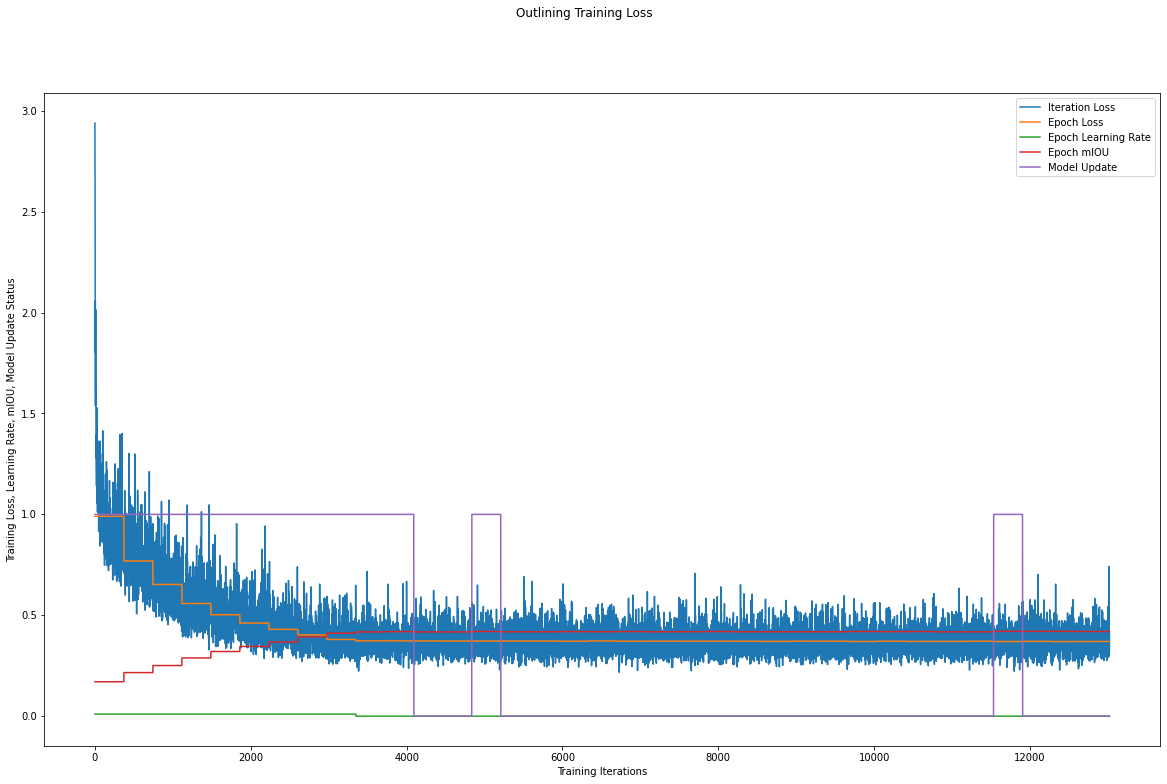

In [52]:
plot_training_performance()

In [53]:
mean_iou_list_val, mean_iou_val = validate_and_save(val_set, device_rtx3070)

100%|██████████| 500/500 [04:38<00:00,  1.79it/s]


     >>>  Predictions saved & IOU evaluated on Val Set in 278.56393 seconds     
**************************************
[ID] [   CLASS NAME   ] [Mean IOU %]
**************************************
[ 0] [road            ] [87.051952]
[ 1] [sidewalk        ] [45.368777]
[ 2] [building        ] [59.603967]
[ 3] [wall            ] [4.452323]
[ 4] [fence           ] [6.797503]
[ 5] [pole            ] [26.180927]
[ 6] [traffic light   ] [1.012790]
[ 7] [traffic sign    ] [18.727193]
[ 8] [vegetation      ] [72.014740]
[ 9] [terrain         ] [26.345777]
[10] [sky             ] [32.909352]
[11] [preson          ] [19.651934]
[12] [rider           ] [0.000000]
[13] [car             ] [54.567229]
[14] [truck           ] [0.023172]
[15] [bus             ] [0.538004]
[16] [train           ] [1.721369]
[17] [motorcycle      ] [3.030889]
[18] [bicycle         ] [20.001899]
**************************************
          mIOU = 25.2631  %          


In [ ]:
######################## Training Phase2 ########################

In [47]:
train_model(train_set, model, device_rtx3090, criterion, optimizer,
            set_new_lr = True, new_lr = 0.01, number_of_epochs = 25)

 ======= Found Existing Model and Loaded ======= 
                     ######################################                     
                     ## Number of parameters: 65,859,379 ##                     
                     ######################################                     


  0%|          | 0/25 [00:00<?, ?it/s]/home/sourajit/.local/lib/python3.6/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/sourajit/.local/lib/python3.6/site-packages/torch/nn/functional.py:3325: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Iteration [     1/  9300], Epoch  [   1], Batch  [   1], Current Batch Loss: 0.33868241, Learning Rate: 0.01000000
Iteration [   150/  9300], Epoch  [   1], Batch  [ 150], Current Batch Loss: 0.39293826, Learning Rate: 0.01000000
Iteration [   300/  9300], Epoch  [   1], Batch  [ 300], Current Batch Loss: 0.27277851, Learning Rate: 0.01000000
**** mIOU updated at epoch # 1 ****
** Current mIOU =  42.4816, Best mIOU =  42.4816 **


  4%|▍         | 1/25 [20:37<8:14:51, 1237.14s/it]

******************************************************************
Epoch  [  1/ 25], Epoch Loss: 0.36568487, Training Time: 1030.66 s
******************************************************************
Iteration [   373/  9300], Epoch  [   2], Batch  [   1], Current Batch Loss: 0.35337365, Learning Rate: 0.01000000
Iteration [   522/  9300], Epoch  [   2], Batch  [ 150], Current Batch Loss: 0.33865711, Learning Rate: 0.01000000
Iteration [   672/  9300], Epoch  [   2], Batch  [ 300], Current Batch Loss: 0.38615856, Learning Rate: 0.01000000
**** mIOU updated at epoch # 2 ****
** Current mIOU =  44.8212, Best mIOU =  44.8212 **


  8%|▊         | 2/25 [40:11<7:40:01, 1200.05s/it]

******************************************************************
Epoch  [  2/ 25], Epoch Loss: 0.35376331, Training Time: 1033.09 s
******************************************************************
Iteration [   745/  9300], Epoch  [   3], Batch  [   1], Current Batch Loss: 0.36578441, Learning Rate: 0.01000000
Iteration [   894/  9300], Epoch  [   3], Batch  [ 150], Current Batch Loss: 0.34034643, Learning Rate: 0.01000000
Iteration [  1044/  9300], Epoch  [   3], Batch  [ 300], Current Batch Loss: 0.35091355, Learning Rate: 0.01000000
**** mIOU updated at epoch # 3 ****
** Current mIOU =  46.7554, Best mIOU =  46.7554 **


 12%|█▏        | 3/25 [59:44<7:15:31, 1187.78s/it]

******************************************************************
Epoch  [  3/ 25], Epoch Loss: 0.25745529, Training Time: 1031.14 s
******************************************************************
Iteration [  1117/  9300], Epoch  [   4], Batch  [   1], Current Batch Loss: 0.29059952, Learning Rate: 0.01000000
Iteration [  1266/  9300], Epoch  [   4], Batch  [ 150], Current Batch Loss: 0.27201140, Learning Rate: 0.01000000
Iteration [  1416/  9300], Epoch  [   4], Batch  [ 300], Current Batch Loss: 0.39517406, Learning Rate: 0.01000000
**** mIOU updated at epoch # 4 ****
** Current mIOU =  48.4513, Best mIOU =  48.4513 **


 16%|█▌        | 4/25 [1:19:29<6:55:22, 1186.78s/it]

******************************************************************
Epoch  [  4/ 25], Epoch Loss: 0.28095302, Training Time: 1032.19 s
******************************************************************
Iteration [  1489/  9300], Epoch  [   5], Batch  [   1], Current Batch Loss: 0.34816763, Learning Rate: 0.01000000
Iteration [  1638/  9300], Epoch  [   5], Batch  [ 150], Current Batch Loss: 0.33073202, Learning Rate: 0.01000000
Iteration [  1788/  9300], Epoch  [   5], Batch  [ 300], Current Batch Loss: 0.31938562, Learning Rate: 0.01000000
**** mIOU updated at epoch # 5 ****
** Current mIOU =  49.7234, Best mIOU =  49.7234 **


 20%|██        | 5/25 [1:39:10<6:34:52, 1184.61s/it]

******************************************************************
Epoch  [  5/ 25], Epoch Loss: 0.35098106, Training Time: 1033.82 s
******************************************************************
Iteration [  1861/  9300], Epoch  [   6], Batch  [   1], Current Batch Loss: 0.25255638, Learning Rate: 0.01000000
Iteration [  2010/  9300], Epoch  [   6], Batch  [ 150], Current Batch Loss: 0.26013443, Learning Rate: 0.01000000
Iteration [  2160/  9300], Epoch  [   6], Batch  [ 300], Current Batch Loss: 0.28508109, Learning Rate: 0.01000000
**** mIOU updated at epoch # 6 ****
** Current mIOU =  50.9881, Best mIOU =  50.9881 **


 24%|██▍       | 6/25 [1:58:46<6:14:12, 1181.68s/it]

******************************************************************
Epoch  [  6/ 25], Epoch Loss: 0.26386359, Training Time: 1034.46 s
******************************************************************
Iteration [  2233/  9300], Epoch  [   7], Batch  [   1], Current Batch Loss: 0.28225413, Learning Rate: 0.01000000
Iteration [  2382/  9300], Epoch  [   7], Batch  [ 150], Current Batch Loss: 0.32492086, Learning Rate: 0.01000000
Iteration [  2532/  9300], Epoch  [   7], Batch  [ 300], Current Batch Loss: 0.26209834, Learning Rate: 0.01000000
**** mIOU updated at epoch # 7 ****
** Current mIOU =  52.4248, Best mIOU =  52.4248 **


 28%|██▊       | 7/25 [2:18:23<5:54:01, 1180.06s/it]

******************************************************************
Epoch  [  7/ 25], Epoch Loss: 0.30169827, Training Time: 1034.03 s
******************************************************************
Iteration [  2605/  9300], Epoch  [   8], Batch  [   1], Current Batch Loss: 0.30048257, Learning Rate: 0.01000000
Iteration [  2754/  9300], Epoch  [   8], Batch  [ 150], Current Batch Loss: 0.35386500, Learning Rate: 0.01000000
Iteration [  2904/  9300], Epoch  [   8], Batch  [ 300], Current Batch Loss: 0.31013131, Learning Rate: 0.01000000
**** mIOU updated at epoch # 8 ****
** Current mIOU =  54.7283, Best mIOU =  54.7283 **


 32%|███▏      | 8/25 [2:37:55<5:33:40, 1177.65s/it]

******************************************************************
Epoch  [  8/ 25], Epoch Loss: 0.31556550, Training Time: 1032.29 s
******************************************************************
Iteration [  2977/  9300], Epoch  [   9], Batch  [   1], Current Batch Loss: 0.23896441, Learning Rate: 0.01000000
Iteration [  3126/  9300], Epoch  [   9], Batch  [ 150], Current Batch Loss: 0.31222710, Learning Rate: 0.01000000
Iteration [  3276/  9300], Epoch  [   9], Batch  [ 300], Current Batch Loss: 0.36781278, Learning Rate: 0.01000000
**** mIOU updated at epoch # 9 ****
** Current mIOU =  56.3127, Best mIOU =  56.3127 **


 36%|███▌      | 9/25 [2:57:30<5:13:50, 1176.90s/it]

******************************************************************
Epoch  [  9/ 25], Epoch Loss: 0.25816718, Training Time: 1033.96 s
******************************************************************
Iteration [  3349/  9300], Epoch  [  10], Batch  [   1], Current Batch Loss: 0.37915236, Learning Rate: 0.01000000
Iteration [  3498/  9300], Epoch  [  10], Batch  [ 150], Current Batch Loss: 0.23056033, Learning Rate: 0.01000000
Iteration [  3648/  9300], Epoch  [  10], Batch  [ 300], Current Batch Loss: 0.34971479, Learning Rate: 0.01000000
**** mIOU updated at epoch #10 ****
** Current mIOU =  57.3278, Best mIOU =  57.3278 **


 40%|████      | 10/25 [3:17:05<4:54:03, 1176.26s/it]

******************************************************************
Epoch  [ 10/ 25], Epoch Loss: 0.25419337, Training Time: 1034.20 s
******************************************************************
Iteration [  3721/  9300], Epoch  [  11], Batch  [   1], Current Batch Loss: 0.23633917, Learning Rate: 0.01000000
Iteration [  3870/  9300], Epoch  [  11], Batch  [ 150], Current Batch Loss: 0.17004617, Learning Rate: 0.01000000
Iteration [  4020/  9300], Epoch  [  11], Batch  [ 300], Current Batch Loss: 0.25199440, Learning Rate: 0.01000000
**** mIOU updated at epoch #11 ****
** Current mIOU =  59.2871, Best mIOU =  59.2871 **


 44%|████▍     | 11/25 [3:36:42<4:34:29, 1176.36s/it]

******************************************************************
Epoch  [ 11/ 25], Epoch Loss: 0.23396827, Training Time: 1034.37 s
******************************************************************
Iteration [  4093/  9300], Epoch  [  12], Batch  [   1], Current Batch Loss: 0.26074463, Learning Rate: 0.01000000
Iteration [  4242/  9300], Epoch  [  12], Batch  [ 150], Current Batch Loss: 0.24234928, Learning Rate: 0.01000000
Iteration [  4392/  9300], Epoch  [  12], Batch  [ 300], Current Batch Loss: 0.22438972, Learning Rate: 0.01000000


 48%|████▊     | 12/25 [3:56:19<4:14:57, 1176.73s/it]

** mIOU updated not at epoch #12 **
******************************************************************
Epoch  [ 12/ 25], Epoch Loss: 0.32359472, Training Time: 1035.00 s
******************************************************************
Iteration [  4465/  9300], Epoch  [  13], Batch  [   1], Current Batch Loss: 0.20458531, Learning Rate: 0.01000000
Iteration [  4614/  9300], Epoch  [  13], Batch  [ 150], Current Batch Loss: 0.22780523, Learning Rate: 0.01000000
Iteration [  4764/  9300], Epoch  [  13], Batch  [ 300], Current Batch Loss: 0.22500029, Learning Rate: 0.01000000
**** mIOU updated at epoch #13 ****
** Current mIOU =  62.1754, Best mIOU =  62.1754 **


 52%|█████▏    | 13/25 [4:15:58<3:55:25, 1177.16s/it]

******************************************************************
Epoch  [ 13/ 25], Epoch Loss: 0.24382105, Training Time: 1032.77 s
******************************************************************
Iteration [  4837/  9300], Epoch  [  14], Batch  [   1], Current Batch Loss: 0.22554776, Learning Rate: 0.01000000
Iteration [  4986/  9300], Epoch  [  14], Batch  [ 150], Current Batch Loss: 0.21108706, Learning Rate: 0.01000000
Iteration [  5136/  9300], Epoch  [  14], Batch  [ 300], Current Batch Loss: 0.22010966, Learning Rate: 0.01000000
**** mIOU updated at epoch #14 ****
** Current mIOU =  62.3385, Best mIOU =  62.3385 **


 56%|█████▌    | 14/25 [4:35:30<3:35:34, 1175.82s/it]

******************************************************************
Epoch  [ 14/ 25], Epoch Loss: 0.30452889, Training Time: 1031.75 s
******************************************************************
Iteration [  5209/  9300], Epoch  [  15], Batch  [   1], Current Batch Loss: 0.20440619, Learning Rate: 0.01000000
Iteration [  5358/  9300], Epoch  [  15], Batch  [ 150], Current Batch Loss: 0.21819375, Learning Rate: 0.01000000
Iteration [  5508/  9300], Epoch  [  15], Batch  [ 300], Current Batch Loss: 0.22071174, Learning Rate: 0.01000000
**** mIOU updated at epoch #15 ****
** Current mIOU =  64.8534, Best mIOU =  64.8534 **


 60%|██████    | 15/25 [4:55:03<3:15:49, 1174.99s/it]

******************************************************************
Epoch  [ 15/ 25], Epoch Loss: 0.19214654, Training Time: 1031.71 s
******************************************************************
Iteration [  5581/  9300], Epoch  [  16], Batch  [   1], Current Batch Loss: 0.19264218, Learning Rate: 0.01000000
Iteration [  5730/  9300], Epoch  [  16], Batch  [ 150], Current Batch Loss: 0.18731214, Learning Rate: 0.01000000
Iteration [  5880/  9300], Epoch  [  16], Batch  [ 300], Current Batch Loss: 0.21282552, Learning Rate: 0.01000000
**** mIOU updated at epoch #16 ****
** Current mIOU =  64.9295, Best mIOU =  64.9295 **


 64%|██████▍   | 16/25 [5:14:36<2:56:07, 1174.20s/it]

******************************************************************
Epoch  [ 16/ 25], Epoch Loss: 0.21380308, Training Time: 1031.55 s
******************************************************************
Iteration [  5953/  9300], Epoch  [  17], Batch  [   1], Current Batch Loss: 0.31078860, Learning Rate: 0.01000000
Iteration [  6102/  9300], Epoch  [  17], Batch  [ 150], Current Batch Loss: 0.19518746, Learning Rate: 0.01000000
Iteration [  6252/  9300], Epoch  [  17], Batch  [ 300], Current Batch Loss: 0.17729591, Learning Rate: 0.01000000


 68%|██████▊   | 17/25 [5:34:07<2:36:27, 1173.44s/it]

** mIOU updated not at epoch #17 **
******************************************************************
Epoch  [ 17/ 25], Epoch Loss: 0.18332088, Training Time: 1031.64 s
******************************************************************
Iteration [  6325/  9300], Epoch  [  18], Batch  [   1], Current Batch Loss: 0.23156554, Learning Rate: 0.01000000
Iteration [  6474/  9300], Epoch  [  18], Batch  [ 150], Current Batch Loss: 0.20810838, Learning Rate: 0.01000000
Iteration [  6624/  9300], Epoch  [  18], Batch  [ 300], Current Batch Loss: 0.20570357, Learning Rate: 0.01000000
**** mIOU updated at epoch #18 ****
** Current mIOU =  67.4379, Best mIOU =  67.4379 **


 72%|███████▏  | 18/25 [5:53:42<2:16:55, 1173.69s/it]

******************************************************************
Epoch  [ 18/ 25], Epoch Loss: 0.18835612, Training Time: 1031.92 s
******************************************************************
Iteration [  6697/  9300], Epoch  [  19], Batch  [   1], Current Batch Loss: 0.20652746, Learning Rate: 0.01000000
Iteration [  6846/  9300], Epoch  [  19], Batch  [ 150], Current Batch Loss: 0.17244934, Learning Rate: 0.01000000
Iteration [  6996/  9300], Epoch  [  19], Batch  [ 300], Current Batch Loss: 0.19586396, Learning Rate: 0.01000000
**** mIOU updated at epoch #19 ****
** Current mIOU =  69.2015, Best mIOU =  69.2015 **


 76%|███████▌  | 19/25 [6:13:15<1:57:21, 1173.65s/it]

******************************************************************
Epoch  [ 19/ 25], Epoch Loss: 0.16810034, Training Time: 1031.81 s
******************************************************************
Iteration [  7069/  9300], Epoch  [  20], Batch  [   1], Current Batch Loss: 0.23256077, Learning Rate: 0.01000000
Iteration [  7218/  9300], Epoch  [  20], Batch  [ 150], Current Batch Loss: 0.17224881, Learning Rate: 0.01000000
Iteration [  7368/  9300], Epoch  [  20], Batch  [ 300], Current Batch Loss: 0.16310175, Learning Rate: 0.01000000
**** mIOU updated at epoch #20 ****
** Current mIOU =  71.1923, Best mIOU =  71.1923 **


 80%|████████  | 20/25 [6:32:48<1:37:47, 1173.42s/it]

******************************************************************
Epoch  [ 20/ 25], Epoch Loss: 0.16840473, Training Time: 1032.10 s
******************************************************************
Iteration [  7441/  9300], Epoch  [  21], Batch  [   1], Current Batch Loss: 0.17991933, Learning Rate: 0.01000000
Iteration [  7590/  9300], Epoch  [  21], Batch  [ 150], Current Batch Loss: 0.18120164, Learning Rate: 0.01000000
Iteration [  7740/  9300], Epoch  [  21], Batch  [ 300], Current Batch Loss: 0.19158459, Learning Rate: 0.01000000


 84%|████████▍ | 21/25 [6:52:21<1:18:13, 1173.30s/it]

** mIOU updated not at epoch #21 **
******************************************************************
Epoch  [ 21/ 25], Epoch Loss: 0.19314641, Training Time: 1032.01 s
******************************************************************
Iteration [  7813/  9300], Epoch  [  22], Batch  [   1], Current Batch Loss: 0.19615385, Learning Rate: 0.01000000
Iteration [  7962/  9300], Epoch  [  22], Batch  [ 150], Current Batch Loss: 0.15325321, Learning Rate: 0.01000000
Iteration [  8112/  9300], Epoch  [  22], Batch  [ 300], Current Batch Loss: 0.18980776, Learning Rate: 0.01000000


 88%|████████▊ | 22/25 [7:11:54<58:39, 1173.14s/it]  

** mIOU updated not at epoch #22 **
******************************************************************
Epoch  [ 22/ 25], Epoch Loss: 0.19981036, Training Time: 1032.10 s
******************************************************************
Iteration [  8185/  9300], Epoch  [  23], Batch  [   1], Current Batch Loss: 0.15500182, Learning Rate: 0.01000000
Iteration [  8334/  9300], Epoch  [  23], Batch  [ 150], Current Batch Loss: 0.21526229, Learning Rate: 0.01000000
Iteration [  8484/  9300], Epoch  [  23], Batch  [ 300], Current Batch Loss: 0.17380646, Learning Rate: 0.01000000


 92%|█████████▏| 23/25 [7:31:27<39:05, 1173.00s/it]

** mIOU updated not at epoch #23 **
******************************************************************
Epoch  [ 23/ 25], Epoch Loss: 0.14796609, Training Time: 1032.23 s
******************************************************************
Iteration [  8557/  9300], Epoch  [  24], Batch  [   1], Current Batch Loss: 0.16567570, Learning Rate: 0.01000000
Iteration [  8706/  9300], Epoch  [  24], Batch  [ 150], Current Batch Loss: 0.18844666, Learning Rate: 0.01000000
Iteration [  8856/  9300], Epoch  [  24], Batch  [ 300], Current Batch Loss: 0.15593913, Learning Rate: 0.01000000
**** mIOU updated at epoch #24 ****
** Current mIOU =  72.1592, Best mIOU =  72.1592 **


 96%|█████████▌| 24/25 [7:51:00<19:33, 1173.23s/it]

******************************************************************
Epoch  [ 24/ 25], Epoch Loss: 0.16862896, Training Time: 1031.94 s
******************************************************************
Iteration [  8929/  9300], Epoch  [  25], Batch  [   1], Current Batch Loss: 0.17395332, Learning Rate: 0.01000000
Iteration [  9078/  9300], Epoch  [  25], Batch  [ 150], Current Batch Loss: 0.16629225, Learning Rate: 0.01000000
Iteration [  9228/  9300], Epoch  [  25], Batch  [ 300], Current Batch Loss: 0.13914280, Learning Rate: 0.01000000
**** mIOU updated at epoch #25 ****
** Current mIOU =  74.0513, Best mIOU =  74.0513 **


100%|██████████| 25/25 [8:10:34<00:00, 1177.38s/it]

******************************************************************
Epoch  [ 25/ 25], Epoch Loss: 0.10913604, Training Time: 1032.49 s
******************************************************************


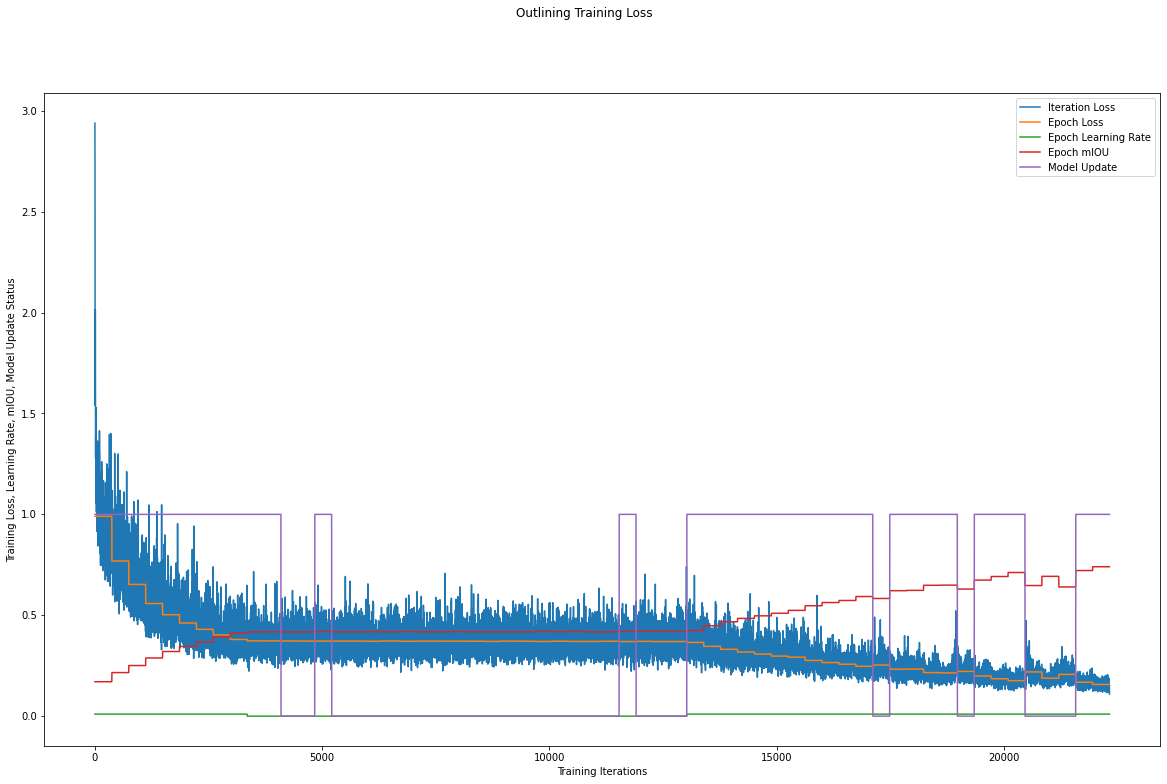

In [48]:
plot_training_performance()

In [49]:
train_model(train_set, model, device_rtx3090, criterion, optimizer,
            set_new_lr = True, new_lr = 0.01, number_of_epochs = 15)

 ======= Found Existing Model and Loaded ======= 
                     ######################################                     
                     ## Number of parameters: 65,859,379 ##                     
                     ######################################                     


  0%|          | 0/15 [00:00<?, ?it/s]

Iteration [     1/  5580], Epoch  [   1], Batch  [   1], Current Batch Loss: 0.11916953, Learning Rate: 0.01000000
Iteration [   150/  5580], Epoch  [   1], Batch  [ 150], Current Batch Loss: 0.17873047, Learning Rate: 0.01000000
Iteration [   300/  5580], Epoch  [   1], Batch  [ 300], Current Batch Loss: 0.14636536, Learning Rate: 0.01000000
**** mIOU updated at epoch # 1 ****
** Current mIOU =  74.6979, Best mIOU =  74.6979 **


  7%|▋         | 1/15 [19:34<4:34:08, 1174.86s/it]

******************************************************************
Epoch  [  1/ 15], Epoch Loss: 0.15337944, Training Time: 1033.25 s
******************************************************************
Iteration [   373/  5580], Epoch  [   2], Batch  [   1], Current Batch Loss: 0.14960730, Learning Rate: 0.01000000
Iteration [   522/  5580], Epoch  [   2], Batch  [ 150], Current Batch Loss: 0.15873089, Learning Rate: 0.01000000
Iteration [   672/  5580], Epoch  [   2], Batch  [ 300], Current Batch Loss: 0.15922052, Learning Rate: 0.01000000
**** mIOU updated at epoch # 2 ****
** Current mIOU =  75.0150, Best mIOU =  75.0150 **


 13%|█▎        | 2/15 [39:08<4:14:23, 1174.10s/it]

******************************************************************
Epoch  [  2/ 15], Epoch Loss: 0.16573377, Training Time: 1032.13 s
******************************************************************
Iteration [   745/  5580], Epoch  [   3], Batch  [   1], Current Batch Loss: 0.13885821, Learning Rate: 0.01000000
Iteration [   894/  5580], Epoch  [   3], Batch  [ 150], Current Batch Loss: 0.17026369, Learning Rate: 0.01000000
Iteration [  1044/  5580], Epoch  [   3], Batch  [ 300], Current Batch Loss: 0.16031779, Learning Rate: 0.01000000


 20%|██        | 3/15 [58:41<3:54:45, 1173.79s/it]

** mIOU updated not at epoch # 3 **
******************************************************************
Epoch  [  3/ 15], Epoch Loss: 0.17017455, Training Time: 1031.93 s
******************************************************************
Iteration [  1117/  5580], Epoch  [   4], Batch  [   1], Current Batch Loss: 0.18885660, Learning Rate: 0.01000000
Iteration [  1266/  5580], Epoch  [   4], Batch  [ 150], Current Batch Loss: 0.28522933, Learning Rate: 0.01000000
Iteration [  1416/  5580], Epoch  [   4], Batch  [ 300], Current Batch Loss: 0.26023087, Learning Rate: 0.01000000


 27%|██▋       | 4/15 [1:18:15<3:35:09, 1173.63s/it]

** mIOU updated not at epoch # 4 **
******************************************************************
Epoch  [  4/ 15], Epoch Loss: 0.21513027, Training Time: 1031.83 s
******************************************************************
Iteration [  1489/  5580], Epoch  [   5], Batch  [   1], Current Batch Loss: 0.16786994, Learning Rate: 0.01000000
Iteration [  1638/  5580], Epoch  [   5], Batch  [ 150], Current Batch Loss: 0.19525127, Learning Rate: 0.01000000
Iteration [  1788/  5580], Epoch  [   5], Batch  [ 300], Current Batch Loss: 0.17325324, Learning Rate: 0.01000000


 33%|███▎      | 5/15 [1:37:49<3:15:37, 1173.75s/it]

** mIOU updated not at epoch # 5 **
******************************************************************
Epoch  [  5/ 15], Epoch Loss: 0.16471905, Training Time: 1033.12 s
******************************************************************
Iteration [  1861/  5580], Epoch  [   6], Batch  [   1], Current Batch Loss: 0.13216408, Learning Rate: 0.01000000
Iteration [  2010/  5580], Epoch  [   6], Batch  [ 150], Current Batch Loss: 0.15593433, Learning Rate: 0.01000000
Iteration [  2160/  5580], Epoch  [   6], Batch  [ 300], Current Batch Loss: 0.13483874, Learning Rate: 0.01000000
**** mIOU updated at epoch # 6 ****
** Current mIOU =  75.7055, Best mIOU =  75.7055 **


 40%|████      | 6/15 [1:57:23<2:56:06, 1174.03s/it]

******************************************************************
Epoch  [  6/ 15], Epoch Loss: 0.16103400, Training Time: 1032.40 s
******************************************************************
Iteration [  2233/  5580], Epoch  [   7], Batch  [   1], Current Batch Loss: 0.13135812, Learning Rate: 0.01000000
Iteration [  2382/  5580], Epoch  [   7], Batch  [ 150], Current Batch Loss: 0.13545766, Learning Rate: 0.01000000
Iteration [  2532/  5580], Epoch  [   7], Batch  [ 300], Current Batch Loss: 0.15733838, Learning Rate: 0.01000000
**** mIOU updated at epoch # 7 ****
** Current mIOU =  76.7098, Best mIOU =  76.7098 **


 47%|████▋     | 7/15 [2:16:59<2:36:36, 1174.52s/it]

******************************************************************
Epoch  [  7/ 15], Epoch Loss: 0.14509182, Training Time: 1032.60 s
******************************************************************
Iteration [  2605/  5580], Epoch  [   8], Batch  [   1], Current Batch Loss: 0.11288745, Learning Rate: 0.01000000
Iteration [  2754/  5580], Epoch  [   8], Batch  [ 150], Current Batch Loss: 0.16722073, Learning Rate: 0.01000000
Iteration [  2904/  5580], Epoch  [   8], Batch  [ 300], Current Batch Loss: 0.14380424, Learning Rate: 0.01000000
**** mIOU updated at epoch # 8 ****
** Current mIOU =  77.4204, Best mIOU =  77.4204 **


 53%|█████▎    | 8/15 [2:36:35<2:17:05, 1175.12s/it]

******************************************************************
Epoch  [  8/ 15], Epoch Loss: 0.13590188, Training Time: 1033.72 s
******************************************************************
Iteration [  2977/  5580], Epoch  [   9], Batch  [   1], Current Batch Loss: 0.13173518, Learning Rate: 0.01000000
Iteration [  3126/  5580], Epoch  [   9], Batch  [ 150], Current Batch Loss: 0.14059195, Learning Rate: 0.01000000
Iteration [  3276/  5580], Epoch  [   9], Batch  [ 300], Current Batch Loss: 0.13032600, Learning Rate: 0.01000000
**** mIOU updated at epoch # 9 ****
** Current mIOU =  77.4856, Best mIOU =  77.4856 **


 60%|██████    | 9/15 [2:56:10<1:57:29, 1174.92s/it]

******************************************************************
Epoch  [  9/ 15], Epoch Loss: 0.17377655, Training Time: 1032.20 s
******************************************************************
Iteration [  3349/  5580], Epoch  [  10], Batch  [   1], Current Batch Loss: 0.12823333, Learning Rate: 0.01000000
Iteration [  3498/  5580], Epoch  [  10], Batch  [ 150], Current Batch Loss: 0.23906703, Learning Rate: 0.01000000
Iteration [  3648/  5580], Epoch  [  10], Batch  [ 300], Current Batch Loss: 0.23938669, Learning Rate: 0.01000000


 67%|██████▋   | 10/15 [3:15:43<1:37:51, 1174.33s/it]

** mIOU updated not at epoch #10 **
******************************************************************
Epoch  [ 10/ 15], Epoch Loss: 0.26128843, Training Time: 1031.54 s
******************************************************************
Iteration [  3721/  5580], Epoch  [  11], Batch  [   1], Current Batch Loss: 0.16766429, Learning Rate: 0.01000000
Iteration [  3870/  5580], Epoch  [  11], Batch  [ 150], Current Batch Loss: 0.19583428, Learning Rate: 0.01000000
Iteration [  4020/  5580], Epoch  [  11], Batch  [ 300], Current Batch Loss: 0.17157142, Learning Rate: 0.01000000


 73%|███████▎  | 11/15 [3:35:15<1:18:15, 1173.79s/it]

** mIOU updated not at epoch #11 **
******************************************************************
Epoch  [ 11/ 15], Epoch Loss: 0.14304025, Training Time: 1031.72 s
******************************************************************
Iteration [  4093/  5580], Epoch  [  12], Batch  [   1], Current Batch Loss: 0.15018515, Learning Rate: 0.01000000
Iteration [  4242/  5580], Epoch  [  12], Batch  [ 150], Current Batch Loss: 0.13275766, Learning Rate: 0.01000000
Iteration [  4392/  5580], Epoch  [  12], Batch  [ 300], Current Batch Loss: 0.13196701, Learning Rate: 0.01000000


 80%|████████  | 12/15 [3:54:48<58:40, 1173.56s/it]  

** mIOU updated not at epoch #12 **
******************************************************************
Epoch  [ 12/ 15], Epoch Loss: 0.12398242, Training Time: 1031.96 s
******************************************************************
Iteration [  4465/  5580], Epoch  [  13], Batch  [   1], Current Batch Loss: 0.10371170, Learning Rate: 0.01000000
Iteration [  4614/  5580], Epoch  [  13], Batch  [ 150], Current Batch Loss: 0.15462086, Learning Rate: 0.01000000
Iteration [  4764/  5580], Epoch  [  13], Batch  [ 300], Current Batch Loss: 0.11696718, Learning Rate: 0.01000000
**** mIOU updated at epoch #13 ****
** Current mIOU =  78.2768, Best mIOU =  78.2768 **


 87%|████████▋ | 13/15 [4:14:25<39:09, 1174.54s/it]

******************************************************************
Epoch  [ 13/ 15], Epoch Loss: 0.13080189, Training Time: 1033.51 s
******************************************************************
Iteration [  4837/  5580], Epoch  [  14], Batch  [   1], Current Batch Loss: 0.10653286, Learning Rate: 0.01000000
Iteration [  4986/  5580], Epoch  [  14], Batch  [ 150], Current Batch Loss: 0.13034832, Learning Rate: 0.01000000
Iteration [  5136/  5580], Epoch  [  14], Batch  [ 300], Current Batch Loss: 0.13090315, Learning Rate: 0.01000000
**** mIOU updated at epoch #14 ****
** Current mIOU =  78.9155, Best mIOU =  78.9155 **


 93%|█████████▎| 14/15 [4:34:03<19:35, 1175.71s/it]

******************************************************************
Epoch  [ 14/ 15], Epoch Loss: 0.11457001, Training Time: 1034.18 s
******************************************************************
Iteration [  5209/  5580], Epoch  [  15], Batch  [   1], Current Batch Loss: 0.10394579, Learning Rate: 0.01000000
Iteration [  5358/  5580], Epoch  [  15], Batch  [ 150], Current Batch Loss: 0.11834989, Learning Rate: 0.01000000
Iteration [  5508/  5580], Epoch  [  15], Batch  [ 300], Current Batch Loss: 0.11856490, Learning Rate: 0.01000000
**** mIOU updated at epoch #15 ****
** Current mIOU =  79.2111, Best mIOU =  79.2111 **


100%|██████████| 15/15 [4:53:42<00:00, 1174.84s/it]

******************************************************************
Epoch  [ 15/ 15], Epoch Loss: 0.11849821, Training Time: 1034.51 s
******************************************************************


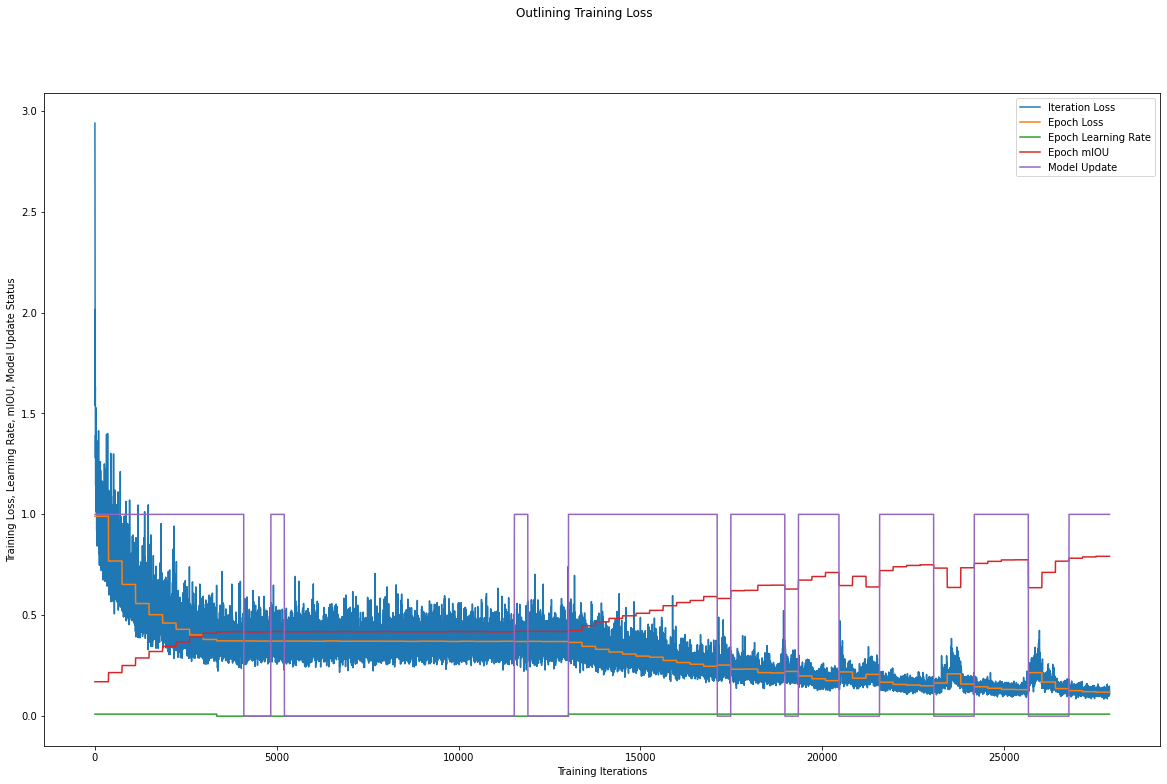

In [50]:
plot_training_performance()

In [51]:
train_model(train_set, model, device_rtx3090, criterion, optimizer,
            set_new_lr = True, new_lr = 0.01, number_of_epochs = 5)

 ======= Found Existing Model and Loaded ======= 
                     ######################################                     
                     ## Number of parameters: 65,859,379 ##                     
                     ######################################                     


  0%|          | 0/5 [00:00<?, ?it/s]

Iteration [     1/  1860], Epoch  [   1], Batch  [   1], Current Batch Loss: 0.12078790, Learning Rate: 0.01000000
Iteration [   150/  1860], Epoch  [   1], Batch  [ 150], Current Batch Loss: 0.11982633, Learning Rate: 0.01000000
Iteration [   300/  1860], Epoch  [   1], Batch  [ 300], Current Batch Loss: 0.11897154, Learning Rate: 0.01000000
**** mIOU updated at epoch # 1 ****
** Current mIOU =  79.4508, Best mIOU =  79.4508 **


 20%|██        | 1/5 [19:39<1:18:39, 1179.77s/it]

******************************************************************
Epoch  [  1/  5], Epoch Loss: 0.11731956, Training Time: 1034.69 s
******************************************************************
Iteration [   373/  1860], Epoch  [   2], Batch  [   1], Current Batch Loss: 0.11203087, Learning Rate: 0.01000000
Iteration [   522/  1860], Epoch  [   2], Batch  [ 150], Current Batch Loss: 0.12291704, Learning Rate: 0.01000000
Iteration [   672/  1860], Epoch  [   2], Batch  [ 300], Current Batch Loss: 0.09011628, Learning Rate: 0.01000000
**** mIOU updated at epoch # 2 ****
** Current mIOU =  79.5133, Best mIOU =  79.5133 **


 40%|████      | 2/5 [39:16<58:53, 1177.96s/it]  

******************************************************************
Epoch  [  2/  5], Epoch Loss: 0.11741586, Training Time: 1034.10 s
******************************************************************
Iteration [   745/  1860], Epoch  [   3], Batch  [   1], Current Batch Loss: 0.13207836, Learning Rate: 0.01000000
Iteration [   894/  1860], Epoch  [   3], Batch  [ 150], Current Batch Loss: 0.12110566, Learning Rate: 0.01000000
Iteration [  1044/  1860], Epoch  [   3], Batch  [ 300], Current Batch Loss: 0.12643203, Learning Rate: 0.01000000


 60%|██████    | 3/5 [58:51<39:13, 1176.75s/it]

** mIOU updated not at epoch # 3 **
******************************************************************
Epoch  [  3/  5], Epoch Loss: 0.10830835, Training Time: 1034.04 s
******************************************************************
Iteration [  1117/  1860], Epoch  [   4], Batch  [   1], Current Batch Loss: 0.12150776, Learning Rate: 0.01000000
Iteration [  1266/  1860], Epoch  [   4], Batch  [ 150], Current Batch Loss: 0.11288253, Learning Rate: 0.01000000
Iteration [  1416/  1860], Epoch  [   4], Batch  [ 300], Current Batch Loss: 0.11035153, Learning Rate: 0.01000000


 80%|████████  | 4/5 [1:18:27<19:36, 1176.23s/it]

** mIOU updated not at epoch # 4 **
******************************************************************
Epoch  [  4/  5], Epoch Loss: 0.10594600, Training Time: 1033.76 s
******************************************************************
Iteration [  1489/  1860], Epoch  [   5], Batch  [   1], Current Batch Loss: 0.14312856, Learning Rate: 0.01000000
Iteration [  1638/  1860], Epoch  [   5], Batch  [ 150], Current Batch Loss: 0.11965320, Learning Rate: 0.01000000
Iteration [  1788/  1860], Epoch  [   5], Batch  [ 300], Current Batch Loss: 0.11049149, Learning Rate: 0.01000000


100%|██████████| 5/5 [1:38:00<00:00, 1176.15s/it]

** mIOU updated not at epoch # 5 **
******************************************************************
Epoch  [  5/  5], Epoch Loss: 0.21635558, Training Time: 1032.42 s
******************************************************************


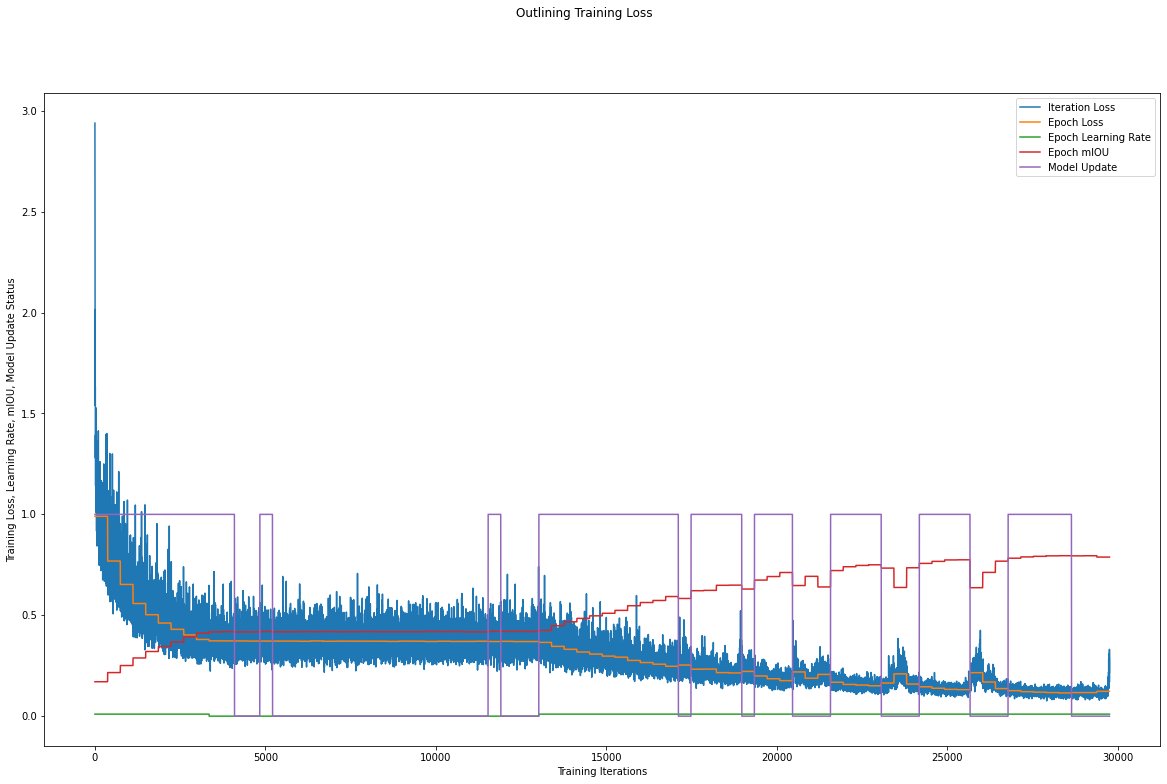

In [52]:
plot_training_performance()

In [53]:
mean_iou_list_val, mean_iou_val = validate_and_save(val_set, device_rtx3070)

100%|██████████| 500/500 [04:44<00:00,  1.75it/s]


     >>>  Predictions saved & IOU evaluated on Val Set in 284.97576 seconds     
**************************************
[ID] [   CLASS NAME   ] [Mean IOU %]
**************************************
[ 0] [road            ] [89.017927]
[ 1] [sidewalk        ] [57.646184]
[ 2] [building        ] [73.898031]
[ 3] [wall            ] [13.879950]
[ 4] [fence           ] [17.804522]
[ 5] [pole            ] [45.046215]
[ 6] [traffic light   ] [8.374925]
[ 7] [traffic sign    ] [42.425650]
[ 8] [vegetation      ] [86.302310]
[ 9] [terrain         ] [40.769798]
[10] [sky             ] [78.197159]
[11] [preson          ] [54.867468]
[12] [rider           ] [18.895431]
[13] [car             ] [75.989231]
[14] [truck           ] [4.999609]
[15] [bus             ] [15.373220]
[16] [train           ] [15.081618]
[17] [motorcycle      ] [19.574477]
[18] [bicycle         ] [54.364331]
**************************************
          mIOU = 42.7636  %          


In [ ]:
######################## Training Phase3 ########################

In [47]:
train_model(train_set, model, device_rtx3090, criterion, optimizer,
            step_size = 20, number_of_epochs = 100)

 ======= Found Existing Model and Loaded ======= 
                     ######################################                     
                     ## Number of parameters: 65,859,379 ##                     
                     ######################################                     


  0%|          | 0/100 [00:00<?, ?it/s]/home/sourajit/.local/lib/python3.6/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/sourajit/.local/lib/python3.6/site-packages/torch/nn/functional.py:3325: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Iteration [     1/ 37200], Epoch  [   1], Batch  [   1], Current Batch Loss: 0.09975746, Learning Rate: 0.00100000
Iteration [   150/ 37200], Epoch  [   1], Batch  [ 150], Current Batch Loss: 0.10127557, Learning Rate: 0.00100000
Iteration [   300/ 37200], Epoch  [   1], Batch  [ 300], Current Batch Loss: 0.10138770, Learning Rate: 0.00100000
**** mIOU updated at epoch # 1 ****
** Current mIOU =  80.6006, Best mIOU =  80.6006 **


  1%|          | 1/100 [19:55<32:52:03, 1195.18s/it]

******************************************************************
Epoch  [  1/100], Epoch Loss: 0.10208632, Training Time: 1031.12 s
******************************************************************
Iteration [   373/ 37200], Epoch  [   2], Batch  [   1], Current Batch Loss: 0.09991705, Learning Rate: 0.00100000
Iteration [   522/ 37200], Epoch  [   2], Batch  [ 150], Current Batch Loss: 0.11796188, Learning Rate: 0.00100000
Iteration [   672/ 37200], Epoch  [   2], Batch  [ 300], Current Batch Loss: 0.10586680, Learning Rate: 0.00100000
**** mIOU updated at epoch # 2 ****
** Current mIOU =  81.0161, Best mIOU =  81.0161 **


  2%|▏         | 2/100 [39:43<32:25:18, 1191.00s/it]

******************************************************************
Epoch  [  2/100], Epoch Loss: 0.10724416, Training Time: 1032.78 s
******************************************************************
Iteration [   745/ 37200], Epoch  [   3], Batch  [   1], Current Batch Loss: 0.08283103, Learning Rate: 0.00100000
Iteration [   894/ 37200], Epoch  [   3], Batch  [ 150], Current Batch Loss: 0.11402065, Learning Rate: 0.00100000
Iteration [  1044/ 37200], Epoch  [   3], Batch  [ 300], Current Batch Loss: 0.09166612, Learning Rate: 0.00100000
**** mIOU updated at epoch # 3 ****
** Current mIOU =  81.2020, Best mIOU =  81.2020 **


  3%|▎         | 3/100 [59:31<32:03:33, 1189.83s/it]

******************************************************************
Epoch  [  3/100], Epoch Loss: 0.08903576, Training Time: 1033.00 s
******************************************************************
Iteration [  1117/ 37200], Epoch  [   4], Batch  [   1], Current Batch Loss: 0.11280815, Learning Rate: 0.00100000
Iteration [  1266/ 37200], Epoch  [   4], Batch  [ 150], Current Batch Loss: 0.12418520, Learning Rate: 0.00100000
Iteration [  1416/ 37200], Epoch  [   4], Batch  [ 300], Current Batch Loss: 0.10984384, Learning Rate: 0.00100000
**** mIOU updated at epoch # 4 ****
** Current mIOU =  81.3101, Best mIOU =  81.3101 **


  4%|▍         | 4/100 [1:19:18<31:41:30, 1188.44s/it]

******************************************************************
Epoch  [  4/100], Epoch Loss: 0.09519584, Training Time: 1032.85 s
******************************************************************
Iteration [  1489/ 37200], Epoch  [   5], Batch  [   1], Current Batch Loss: 0.10511409, Learning Rate: 0.00100000
Iteration [  1638/ 37200], Epoch  [   5], Batch  [ 150], Current Batch Loss: 0.09067729, Learning Rate: 0.00100000
Iteration [  1788/ 37200], Epoch  [   5], Batch  [ 300], Current Batch Loss: 0.11216253, Learning Rate: 0.00100000
**** mIOU updated at epoch # 5 ****
** Current mIOU =  81.4070, Best mIOU =  81.4070 **


  5%|▌         | 5/100 [1:39:04<31:20:33, 1187.72s/it]

******************************************************************
Epoch  [  5/100], Epoch Loss: 0.10130215, Training Time: 1032.94 s
******************************************************************
Iteration [  1861/ 37200], Epoch  [   6], Batch  [   1], Current Batch Loss: 0.12259090, Learning Rate: 0.00100000
Iteration [  2010/ 37200], Epoch  [   6], Batch  [ 150], Current Batch Loss: 0.08121644, Learning Rate: 0.00100000
Iteration [  2160/ 37200], Epoch  [   6], Batch  [ 300], Current Batch Loss: 0.08623677, Learning Rate: 0.00100000
**** mIOU updated at epoch # 6 ****
** Current mIOU =  81.5012, Best mIOU =  81.5012 **


  6%|▌         | 6/100 [1:58:49<30:59:34, 1186.96s/it]

******************************************************************
Epoch  [  6/100], Epoch Loss: 0.09171297, Training Time: 1032.75 s
******************************************************************
Iteration [  2233/ 37200], Epoch  [   7], Batch  [   1], Current Batch Loss: 0.10757522, Learning Rate: 0.00100000
Iteration [  2382/ 37200], Epoch  [   7], Batch  [ 150], Current Batch Loss: 0.11128339, Learning Rate: 0.00100000
Iteration [  2532/ 37200], Epoch  [   7], Batch  [ 300], Current Batch Loss: 0.10773174, Learning Rate: 0.00100000
**** mIOU updated at epoch # 7 ****
** Current mIOU =  81.5606, Best mIOU =  81.5606 **


  7%|▋         | 7/100 [2:18:34<30:38:47, 1186.32s/it]

******************************************************************
Epoch  [  7/100], Epoch Loss: 0.10856295, Training Time: 1032.68 s
******************************************************************
Iteration [  2605/ 37200], Epoch  [   8], Batch  [   1], Current Batch Loss: 0.10947127, Learning Rate: 0.00100000
Iteration [  2754/ 37200], Epoch  [   8], Batch  [ 150], Current Batch Loss: 0.09166268, Learning Rate: 0.00100000
Iteration [  2904/ 37200], Epoch  [   8], Batch  [ 300], Current Batch Loss: 0.09587286, Learning Rate: 0.00100000
**** mIOU updated at epoch # 8 ****
** Current mIOU =  81.6358, Best mIOU =  81.6358 **


  8%|▊         | 8/100 [2:38:21<30:19:21, 1186.54s/it]

******************************************************************
Epoch  [  8/100], Epoch Loss: 0.11237714, Training Time: 1033.02 s
******************************************************************
Iteration [  2977/ 37200], Epoch  [   9], Batch  [   1], Current Batch Loss: 0.11191741, Learning Rate: 0.00100000
Iteration [  3126/ 37200], Epoch  [   9], Batch  [ 150], Current Batch Loss: 0.12365063, Learning Rate: 0.00100000
Iteration [  3276/ 37200], Epoch  [   9], Batch  [ 300], Current Batch Loss: 0.09396264, Learning Rate: 0.00100000
**** mIOU updated at epoch # 9 ****
** Current mIOU =  81.6745, Best mIOU =  81.6745 **


  9%|▉         | 9/100 [2:58:06<29:58:47, 1186.02s/it]

******************************************************************
Epoch  [  9/100], Epoch Loss: 0.08957484, Training Time: 1032.55 s
******************************************************************
Iteration [  3349/ 37200], Epoch  [  10], Batch  [   1], Current Batch Loss: 0.08892932, Learning Rate: 0.00100000
Iteration [  3498/ 37200], Epoch  [  10], Batch  [ 150], Current Batch Loss: 0.10091690, Learning Rate: 0.00100000
Iteration [  3648/ 37200], Epoch  [  10], Batch  [ 300], Current Batch Loss: 0.08575771, Learning Rate: 0.00100000
**** mIOU updated at epoch #10 ****
** Current mIOU =  81.7227, Best mIOU =  81.7227 **


 10%|█         | 10/100 [3:17:53<29:39:25, 1186.28s/it]

******************************************************************
Epoch  [ 10/100], Epoch Loss: 0.10728933, Training Time: 1032.77 s
******************************************************************
Iteration [  3721/ 37200], Epoch  [  11], Batch  [   1], Current Batch Loss: 0.08415327, Learning Rate: 0.00100000
Iteration [  3870/ 37200], Epoch  [  11], Batch  [ 150], Current Batch Loss: 0.12067508, Learning Rate: 0.00100000
Iteration [  4020/ 37200], Epoch  [  11], Batch  [ 300], Current Batch Loss: 0.11541530, Learning Rate: 0.00100000
**** mIOU updated at epoch #11 ****
** Current mIOU =  81.7888, Best mIOU =  81.7888 **


 11%|█         | 11/100 [3:37:37<29:18:29, 1185.50s/it]

******************************************************************
Epoch  [ 11/100], Epoch Loss: 0.07748695, Training Time: 1032.67 s
******************************************************************
Iteration [  4093/ 37200], Epoch  [  12], Batch  [   1], Current Batch Loss: 0.11083676, Learning Rate: 0.00100000
Iteration [  4242/ 37200], Epoch  [  12], Batch  [ 150], Current Batch Loss: 0.11045748, Learning Rate: 0.00100000
Iteration [  4392/ 37200], Epoch  [  12], Batch  [ 300], Current Batch Loss: 0.09904463, Learning Rate: 0.00100000
**** mIOU updated at epoch #12 ****
** Current mIOU =  81.8146, Best mIOU =  81.8146 **


 12%|█▏        | 12/100 [3:57:21<28:57:53, 1184.93s/it]

******************************************************************
Epoch  [ 12/100], Epoch Loss: 0.10826089, Training Time: 1032.67 s
******************************************************************
Iteration [  4465/ 37200], Epoch  [  13], Batch  [   1], Current Batch Loss: 0.08506214, Learning Rate: 0.00100000
Iteration [  4614/ 37200], Epoch  [  13], Batch  [ 150], Current Batch Loss: 0.10247428, Learning Rate: 0.00100000
Iteration [  4764/ 37200], Epoch  [  13], Batch  [ 300], Current Batch Loss: 0.10818891, Learning Rate: 0.00100000
**** mIOU updated at epoch #13 ****
** Current mIOU =  81.8763, Best mIOU =  81.8763 **


 13%|█▎        | 13/100 [4:17:07<28:38:52, 1185.43s/it]

******************************************************************
Epoch  [ 13/100], Epoch Loss: 0.11259907, Training Time: 1033.08 s
******************************************************************
Iteration [  4837/ 37200], Epoch  [  14], Batch  [   1], Current Batch Loss: 0.08114795, Learning Rate: 0.00100000
Iteration [  4986/ 37200], Epoch  [  14], Batch  [ 150], Current Batch Loss: 0.08652584, Learning Rate: 0.00100000
Iteration [  5136/ 37200], Epoch  [  14], Batch  [ 300], Current Batch Loss: 0.10590595, Learning Rate: 0.00100000
**** mIOU updated at epoch #14 ****
** Current mIOU =  81.8925, Best mIOU =  81.8925 **


 14%|█▍        | 14/100 [4:36:54<28:19:37, 1185.78s/it]

******************************************************************
Epoch  [ 14/100], Epoch Loss: 0.11024143, Training Time: 1033.34 s
******************************************************************
Iteration [  5209/ 37200], Epoch  [  15], Batch  [   1], Current Batch Loss: 0.10788094, Learning Rate: 0.00100000
Iteration [  5358/ 37200], Epoch  [  15], Batch  [ 150], Current Batch Loss: 0.08778880, Learning Rate: 0.00100000
Iteration [  5508/ 37200], Epoch  [  15], Batch  [ 300], Current Batch Loss: 0.10395900, Learning Rate: 0.00100000
**** mIOU updated at epoch #15 ****
** Current mIOU =  81.9353, Best mIOU =  81.9353 **


 15%|█▌        | 15/100 [4:56:47<28:02:56, 1187.96s/it]

******************************************************************
Epoch  [ 15/100], Epoch Loss: 0.12216468, Training Time: 1033.54 s
******************************************************************
Iteration [  5581/ 37200], Epoch  [  16], Batch  [   1], Current Batch Loss: 0.11938377, Learning Rate: 0.00100000
Iteration [  5730/ 37200], Epoch  [  16], Batch  [ 150], Current Batch Loss: 0.08840398, Learning Rate: 0.00100000
Iteration [  5880/ 37200], Epoch  [  16], Batch  [ 300], Current Batch Loss: 0.10025339, Learning Rate: 0.00100000
**** mIOU updated at epoch #16 ****
** Current mIOU =  81.9686, Best mIOU =  81.9686 **


 16%|█▌        | 16/100 [5:16:35<27:43:27, 1188.18s/it]

******************************************************************
Epoch  [ 16/100], Epoch Loss: 0.09586965, Training Time: 1033.67 s
******************************************************************
Iteration [  5953/ 37200], Epoch  [  17], Batch  [   1], Current Batch Loss: 0.09344589, Learning Rate: 0.00100000
Iteration [  6102/ 37200], Epoch  [  17], Batch  [ 150], Current Batch Loss: 0.12098517, Learning Rate: 0.00100000
Iteration [  6252/ 37200], Epoch  [  17], Batch  [ 300], Current Batch Loss: 0.07925764, Learning Rate: 0.00100000
**** mIOU updated at epoch #17 ****
** Current mIOU =  82.0223, Best mIOU =  82.0223 **


 17%|█▋        | 17/100 [5:36:22<27:22:49, 1187.58s/it]

******************************************************************
Epoch  [ 17/100], Epoch Loss: 0.08786844, Training Time: 1033.68 s
******************************************************************
Iteration [  6325/ 37200], Epoch  [  18], Batch  [   1], Current Batch Loss: 0.07688247, Learning Rate: 0.00100000
Iteration [  6474/ 37200], Epoch  [  18], Batch  [ 150], Current Batch Loss: 0.08587358, Learning Rate: 0.00100000
Iteration [  6624/ 37200], Epoch  [  18], Batch  [ 300], Current Batch Loss: 0.09834223, Learning Rate: 0.00100000
**** mIOU updated at epoch #18 ****
** Current mIOU =  82.0407, Best mIOU =  82.0407 **


 18%|█▊        | 18/100 [5:56:14<27:05:08, 1189.13s/it]

******************************************************************
Epoch  [ 18/100], Epoch Loss: 0.08675865, Training Time: 1033.89 s
******************************************************************
Iteration [  6697/ 37200], Epoch  [  19], Batch  [   1], Current Batch Loss: 0.09385534, Learning Rate: 0.00100000
Iteration [  6846/ 37200], Epoch  [  19], Batch  [ 150], Current Batch Loss: 0.09172659, Learning Rate: 0.00100000
Iteration [  6996/ 37200], Epoch  [  19], Batch  [ 300], Current Batch Loss: 0.09809653, Learning Rate: 0.00100000
**** mIOU updated at epoch #19 ****
** Current mIOU =  82.1123, Best mIOU =  82.1123 **


 19%|█▉        | 19/100 [6:16:05<26:45:56, 1189.59s/it]

******************************************************************
Epoch  [ 19/100], Epoch Loss: 0.09965852, Training Time: 1034.26 s
******************************************************************
Iteration [  7069/ 37200], Epoch  [  20], Batch  [   1], Current Batch Loss: 0.07563790, Learning Rate: 0.00100000
Iteration [  7218/ 37200], Epoch  [  20], Batch  [ 150], Current Batch Loss: 0.10328849, Learning Rate: 0.00100000
Iteration [  7368/ 37200], Epoch  [  20], Batch  [ 300], Current Batch Loss: 0.09430724, Learning Rate: 0.00100000
**** mIOU updated at epoch #20 ****
** Current mIOU =  82.1290, Best mIOU =  82.1290 **


 20%|██        | 20/100 [6:35:55<26:26:23, 1189.80s/it]

******************************************************************
Epoch  [ 20/100], Epoch Loss: 0.11049357, Training Time: 1034.33 s
******************************************************************
Iteration [  7441/ 37200], Epoch  [  21], Batch  [   1], Current Batch Loss: 0.09712935, Learning Rate: 0.00010000
Iteration [  7590/ 37200], Epoch  [  21], Batch  [ 150], Current Batch Loss: 0.06453502, Learning Rate: 0.00010000
Iteration [  7740/ 37200], Epoch  [  21], Batch  [ 300], Current Batch Loss: 0.07705827, Learning Rate: 0.00010000
**** mIOU updated at epoch #21 ****
** Current mIOU =  82.2261, Best mIOU =  82.2261 **


 21%|██        | 21/100 [6:55:42<26:05:17, 1188.83s/it]

******************************************************************
Epoch  [ 21/100], Epoch Loss: 0.08464649, Training Time: 1033.68 s
******************************************************************
Iteration [  7813/ 37200], Epoch  [  22], Batch  [   1], Current Batch Loss: 0.08687551, Learning Rate: 0.00010000
Iteration [  7962/ 37200], Epoch  [  22], Batch  [ 150], Current Batch Loss: 0.09320498, Learning Rate: 0.00010000
Iteration [  8112/ 37200], Epoch  [  22], Batch  [ 300], Current Batch Loss: 0.08295872, Learning Rate: 0.00010000
**** mIOU updated at epoch #22 ****
** Current mIOU =  82.2361, Best mIOU =  82.2361 **


 22%|██▏       | 22/100 [7:15:26<25:43:28, 1187.29s/it]

******************************************************************
Epoch  [ 22/100], Epoch Loss: 0.08483185, Training Time: 1032.50 s
******************************************************************
Iteration [  8185/ 37200], Epoch  [  23], Batch  [   1], Current Batch Loss: 0.08846879, Learning Rate: 0.00010000
Iteration [  8334/ 37200], Epoch  [  23], Batch  [ 150], Current Batch Loss: 0.09078360, Learning Rate: 0.00010000
Iteration [  8484/ 37200], Epoch  [  23], Batch  [ 300], Current Batch Loss: 0.08087451, Learning Rate: 0.00010000
**** mIOU updated at epoch #23 ****
** Current mIOU =  82.2400, Best mIOU =  82.2400 **


 23%|██▎       | 23/100 [7:35:10<25:22:39, 1186.49s/it]

******************************************************************
Epoch  [ 23/100], Epoch Loss: 0.09989066, Training Time: 1033.23 s
******************************************************************
Iteration [  8557/ 37200], Epoch  [  24], Batch  [   1], Current Batch Loss: 0.09726197, Learning Rate: 0.00010000
Iteration [  8706/ 37200], Epoch  [  24], Batch  [ 150], Current Batch Loss: 0.09348791, Learning Rate: 0.00010000
Iteration [  8856/ 37200], Epoch  [  24], Batch  [ 300], Current Batch Loss: 0.09201388, Learning Rate: 0.00010000
**** mIOU updated at epoch #24 ****
** Current mIOU =  82.2538, Best mIOU =  82.2538 **


 24%|██▍       | 24/100 [7:54:59<25:03:56, 1187.32s/it]

******************************************************************
Epoch  [ 24/100], Epoch Loss: 0.08866955, Training Time: 1033.28 s
******************************************************************
Iteration [  8929/ 37200], Epoch  [  25], Batch  [   1], Current Batch Loss: 0.09424819, Learning Rate: 0.00010000
Iteration [  9078/ 37200], Epoch  [  25], Batch  [ 150], Current Batch Loss: 0.07560389, Learning Rate: 0.00010000
Iteration [  9228/ 37200], Epoch  [  25], Batch  [ 300], Current Batch Loss: 0.09226132, Learning Rate: 0.00010000
**** mIOU updated at epoch #25 ****
** Current mIOU =  82.2672, Best mIOU =  82.2672 **


 25%|██▌       | 25/100 [8:14:59<24:48:47, 1191.03s/it]

******************************************************************
Epoch  [ 25/100], Epoch Loss: 0.09037246, Training Time: 1033.20 s
******************************************************************
Iteration [  9301/ 37200], Epoch  [  26], Batch  [   1], Current Batch Loss: 0.09988867, Learning Rate: 0.00010000
Iteration [  9450/ 37200], Epoch  [  26], Batch  [ 150], Current Batch Loss: 0.09376322, Learning Rate: 0.00010000
Iteration [  9600/ 37200], Epoch  [  26], Batch  [ 300], Current Batch Loss: 0.09618114, Learning Rate: 0.00010000


 26%|██▌       | 26/100 [8:35:37<24:46:20, 1205.14s/it]

** mIOU not updated at epoch #26 **
******************************************************************
Epoch  [ 26/100], Epoch Loss: 0.08544153, Training Time: 1034.46 s
******************************************************************
Iteration [  9673/ 37200], Epoch  [  27], Batch  [   1], Current Batch Loss: 0.10547072, Learning Rate: 0.00010000
Iteration [  9822/ 37200], Epoch  [  27], Batch  [ 150], Current Batch Loss: 0.11227114, Learning Rate: 0.00010000
Iteration [  9972/ 37200], Epoch  [  27], Batch  [ 300], Current Batch Loss: 0.10049765, Learning Rate: 0.00010000
**** mIOU updated at epoch #27 ****
** Current mIOU =  82.2761, Best mIOU =  82.2761 **


 27%|██▋       | 27/100 [8:55:22<24:18:46, 1198.99s/it]

******************************************************************
Epoch  [ 27/100], Epoch Loss: 0.09943730, Training Time: 1033.80 s
******************************************************************
Iteration [ 10045/ 37200], Epoch  [  28], Batch  [   1], Current Batch Loss: 0.10553067, Learning Rate: 0.00010000
Iteration [ 10194/ 37200], Epoch  [  28], Batch  [ 150], Current Batch Loss: 0.08841383, Learning Rate: 0.00010000
Iteration [ 10344/ 37200], Epoch  [  28], Batch  [ 300], Current Batch Loss: 0.08570211, Learning Rate: 0.00010000
**** mIOU updated at epoch #28 ****
** Current mIOU =  82.2813, Best mIOU =  82.2813 **


 28%|██▊       | 28/100 [9:15:14<23:56:30, 1197.09s/it]

******************************************************************
Epoch  [ 28/100], Epoch Loss: 0.09256360, Training Time: 1033.00 s
******************************************************************
Iteration [ 10417/ 37200], Epoch  [  29], Batch  [   1], Current Batch Loss: 0.07411771, Learning Rate: 0.00010000
Iteration [ 10566/ 37200], Epoch  [  29], Batch  [ 150], Current Batch Loss: 0.08526582, Learning Rate: 0.00010000
Iteration [ 10716/ 37200], Epoch  [  29], Batch  [ 300], Current Batch Loss: 0.07173477, Learning Rate: 0.00010000
**** mIOU updated at epoch #29 ****
** Current mIOU =  82.2879, Best mIOU =  82.2879 **


 29%|██▉       | 29/100 [9:35:08<23:35:11, 1195.93s/it]

******************************************************************
Epoch  [ 29/100], Epoch Loss: 0.09898624, Training Time: 1033.65 s
******************************************************************
Iteration [ 10789/ 37200], Epoch  [  30], Batch  [   1], Current Batch Loss: 0.07811400, Learning Rate: 0.00010000
Iteration [ 10938/ 37200], Epoch  [  30], Batch  [ 150], Current Batch Loss: 0.07808563, Learning Rate: 0.00010000
Iteration [ 11088/ 37200], Epoch  [  30], Batch  [ 300], Current Batch Loss: 0.09679535, Learning Rate: 0.00010000
**** mIOU updated at epoch #30 ****
** Current mIOU =  82.2993, Best mIOU =  82.2993 **


 30%|███       | 30/100 [9:54:53<23:11:36, 1192.80s/it]

******************************************************************
Epoch  [ 30/100], Epoch Loss: 0.09033909, Training Time: 1033.45 s
******************************************************************
Iteration [ 11161/ 37200], Epoch  [  31], Batch  [   1], Current Batch Loss: 0.08935496, Learning Rate: 0.00010000
Iteration [ 11310/ 37200], Epoch  [  31], Batch  [ 150], Current Batch Loss: 0.07488158, Learning Rate: 0.00010000
Iteration [ 11460/ 37200], Epoch  [  31], Batch  [ 300], Current Batch Loss: 0.10268301, Learning Rate: 0.00010000


 31%|███       | 31/100 [10:15:06<22:58:34, 1198.76s/it]

** mIOU not updated at epoch #31 **
******************************************************************
Epoch  [ 31/100], Epoch Loss: 0.09963107, Training Time: 1034.02 s
******************************************************************
Iteration [ 11533/ 37200], Epoch  [  32], Batch  [   1], Current Batch Loss: 0.10388097, Learning Rate: 0.00010000
Iteration [ 11682/ 37200], Epoch  [  32], Batch  [ 150], Current Batch Loss: 0.08839959, Learning Rate: 0.00010000
Iteration [ 11832/ 37200], Epoch  [  32], Batch  [ 300], Current Batch Loss: 0.09358261, Learning Rate: 0.00010000
**** mIOU updated at epoch #32 ****
** Current mIOU =  82.3048, Best mIOU =  82.3048 **


 32%|███▏      | 32/100 [10:34:46<22:32:11, 1193.11s/it]

******************************************************************
Epoch  [ 32/100], Epoch Loss: 0.08831297, Training Time: 1033.52 s
******************************************************************
Iteration [ 11905/ 37200], Epoch  [  33], Batch  [   1], Current Batch Loss: 0.08709130, Learning Rate: 0.00010000
Iteration [ 12054/ 37200], Epoch  [  33], Batch  [ 150], Current Batch Loss: 0.10897415, Learning Rate: 0.00010000
Iteration [ 12204/ 37200], Epoch  [  33], Batch  [ 300], Current Batch Loss: 0.10405317, Learning Rate: 0.00010000
**** mIOU updated at epoch #33 ****
** Current mIOU =  82.3071, Best mIOU =  82.3071 **


 33%|███▎      | 33/100 [10:54:26<22:08:04, 1189.32s/it]

******************************************************************
Epoch  [ 33/100], Epoch Loss: 0.09199983, Training Time: 1033.34 s
******************************************************************
Iteration [ 12277/ 37200], Epoch  [  34], Batch  [   1], Current Batch Loss: 0.09588753, Learning Rate: 0.00010000
Iteration [ 12426/ 37200], Epoch  [  34], Batch  [ 150], Current Batch Loss: 0.08864486, Learning Rate: 0.00010000
Iteration [ 12576/ 37200], Epoch  [  34], Batch  [ 300], Current Batch Loss: 0.10873108, Learning Rate: 0.00010000


 34%|███▍      | 34/100 [11:19:17<23:27:40, 1279.71s/it]

** mIOU not updated at epoch #34 **
******************************************************************
Epoch  [ 34/100], Epoch Loss: 0.09786421, Training Time: 1034.26 s
******************************************************************
Iteration [ 12649/ 37200], Epoch  [  35], Batch  [   1], Current Batch Loss: 0.10419755, Learning Rate: 0.00010000
Iteration [ 12798/ 37200], Epoch  [  35], Batch  [ 150], Current Batch Loss: 0.10760809, Learning Rate: 0.00010000
Iteration [ 12948/ 37200], Epoch  [  35], Batch  [ 300], Current Batch Loss: 0.09122156, Learning Rate: 0.00010000


 35%|███▌      | 35/100 [11:41:16<23:19:07, 1291.51s/it]

** mIOU not updated at epoch #35 **
******************************************************************
Epoch  [ 35/100], Epoch Loss: 0.09157248, Training Time: 1033.97 s
******************************************************************
Iteration [ 13021/ 37200], Epoch  [  36], Batch  [   1], Current Batch Loss: 0.10541320, Learning Rate: 0.00010000
Iteration [ 13170/ 37200], Epoch  [  36], Batch  [ 150], Current Batch Loss: 0.11374748, Learning Rate: 0.00010000
Iteration [ 13320/ 37200], Epoch  [  36], Batch  [ 300], Current Batch Loss: 0.09957616, Learning Rate: 0.00010000
**** mIOU updated at epoch #36 ****
** Current mIOU =  82.3130, Best mIOU =  82.3130 **


 36%|███▌      | 36/100 [12:03:19<23:07:41, 1300.96s/it]

******************************************************************
Epoch  [ 36/100], Epoch Loss: 0.08570541, Training Time: 1033.91 s
******************************************************************
Iteration [ 13393/ 37200], Epoch  [  37], Batch  [   1], Current Batch Loss: 0.09700521, Learning Rate: 0.00010000
Iteration [ 13542/ 37200], Epoch  [  37], Batch  [ 150], Current Batch Loss: 0.07745250, Learning Rate: 0.00010000
Iteration [ 13692/ 37200], Epoch  [  37], Batch  [ 300], Current Batch Loss: 0.09621483, Learning Rate: 0.00010000
**** mIOU updated at epoch #37 ****
** Current mIOU =  82.3281, Best mIOU =  82.3281 **


 37%|███▋      | 37/100 [12:23:05<22:09:47, 1266.46s/it]

******************************************************************
Epoch  [ 37/100], Epoch Loss: 0.13801691, Training Time: 1033.02 s
******************************************************************
Iteration [ 13765/ 37200], Epoch  [  38], Batch  [   1], Current Batch Loss: 0.08374397, Learning Rate: 0.00010000
Iteration [ 13914/ 37200], Epoch  [  38], Batch  [ 150], Current Batch Loss: 0.08463606, Learning Rate: 0.00010000
Iteration [ 14064/ 37200], Epoch  [  38], Batch  [ 300], Current Batch Loss: 0.10398244, Learning Rate: 0.00010000


 38%|███▊      | 38/100 [12:42:50<21:23:20, 1241.94s/it]

** mIOU not updated at epoch #38 **
******************************************************************
Epoch  [ 38/100], Epoch Loss: 0.08088592, Training Time: 1033.02 s
******************************************************************
Iteration [ 14137/ 37200], Epoch  [  39], Batch  [   1], Current Batch Loss: 0.10179822, Learning Rate: 0.00010000
Iteration [ 14286/ 37200], Epoch  [  39], Batch  [ 150], Current Batch Loss: 0.08409537, Learning Rate: 0.00010000
Iteration [ 14436/ 37200], Epoch  [  39], Batch  [ 300], Current Batch Loss: 0.08945861, Learning Rate: 0.00010000


 39%|███▉      | 39/100 [13:02:32<20:44:25, 1224.02s/it]

** mIOU not updated at epoch #39 **
******************************************************************
Epoch  [ 39/100], Epoch Loss: 0.09940676, Training Time: 1033.01 s
******************************************************************
Iteration [ 14509/ 37200], Epoch  [  40], Batch  [   1], Current Batch Loss: 0.09642414, Learning Rate: 0.00010000
Iteration [ 14658/ 37200], Epoch  [  40], Batch  [ 150], Current Batch Loss: 0.10735256, Learning Rate: 0.00010000
Iteration [ 14808/ 37200], Epoch  [  40], Batch  [ 300], Current Batch Loss: 0.10384707, Learning Rate: 0.00010000
**** mIOU updated at epoch #40 ****
** Current mIOU =  82.3328, Best mIOU =  82.3328 **


 40%|████      | 40/100 [13:22:14<20:11:34, 1211.57s/it]

******************************************************************
Epoch  [ 40/100], Epoch Loss: 0.09773993, Training Time: 1033.09 s
******************************************************************
Iteration [ 14881/ 37200], Epoch  [  41], Batch  [   1], Current Batch Loss: 0.10811254, Learning Rate: 0.00001000
Iteration [ 15030/ 37200], Epoch  [  41], Batch  [ 150], Current Batch Loss: 0.09939092, Learning Rate: 0.00001000
Iteration [ 15180/ 37200], Epoch  [  41], Batch  [ 300], Current Batch Loss: 0.10019426, Learning Rate: 0.00001000
**** mIOU updated at epoch #41 ****
** Current mIOU =  82.3348, Best mIOU =  82.3348 **


 41%|████      | 41/100 [13:42:06<19:45:33, 1205.65s/it]

******************************************************************
Epoch  [ 41/100], Epoch Loss: 0.09363697, Training Time: 1032.89 s
******************************************************************
Iteration [ 15253/ 37200], Epoch  [  42], Batch  [   1], Current Batch Loss: 0.10582069, Learning Rate: 0.00001000
Iteration [ 15402/ 37200], Epoch  [  42], Batch  [ 150], Current Batch Loss: 0.10386357, Learning Rate: 0.00001000
Iteration [ 15552/ 37200], Epoch  [  42], Batch  [ 300], Current Batch Loss: 0.08659033, Learning Rate: 0.00001000
**** mIOU updated at epoch #42 ****
** Current mIOU =  82.3392, Best mIOU =  82.3392 **


 42%|████▏     | 42/100 [14:02:55<19:37:55, 1218.54s/it]

******************************************************************
Epoch  [ 42/100], Epoch Loss: 0.09500999, Training Time: 1032.97 s
******************************************************************
Iteration [ 15625/ 37200], Epoch  [  43], Batch  [   1], Current Batch Loss: 0.12070382, Learning Rate: 0.00001000
Iteration [ 15774/ 37200], Epoch  [  43], Batch  [ 150], Current Batch Loss: 0.09983823, Learning Rate: 0.00001000
Iteration [ 15924/ 37200], Epoch  [  43], Batch  [ 300], Current Batch Loss: 0.06984140, Learning Rate: 0.00001000


 43%|████▎     | 43/100 [14:22:49<19:10:42, 1211.26s/it]

** mIOU not updated at epoch #43 **
******************************************************************
Epoch  [ 43/100], Epoch Loss: 0.10977121, Training Time: 1034.23 s
******************************************************************
Iteration [ 15997/ 37200], Epoch  [  44], Batch  [   1], Current Batch Loss: 0.09167556, Learning Rate: 0.00001000
Iteration [ 16146/ 37200], Epoch  [  44], Batch  [ 150], Current Batch Loss: 0.09671377, Learning Rate: 0.00001000
Iteration [ 16296/ 37200], Epoch  [  44], Batch  [ 300], Current Batch Loss: 0.09708516, Learning Rate: 0.00001000
**** mIOU updated at epoch #44 ****
** Current mIOU =  82.3429, Best mIOU =  82.3429 **


 44%|████▍     | 44/100 [14:44:55<19:22:41, 1245.75s/it]

******************************************************************
Epoch  [ 44/100], Epoch Loss: 0.09204890, Training Time: 1034.03 s
******************************************************************
Iteration [ 16369/ 37200], Epoch  [  45], Batch  [   1], Current Batch Loss: 0.09701907, Learning Rate: 0.00001000
Iteration [ 16518/ 37200], Epoch  [  45], Batch  [ 150], Current Batch Loss: 0.09791440, Learning Rate: 0.00001000
Iteration [ 16668/ 37200], Epoch  [  45], Batch  [ 300], Current Batch Loss: 0.09888528, Learning Rate: 0.00001000
**** mIOU updated at epoch #45 ****
** Current mIOU =  82.3456, Best mIOU =  82.3456 **


 45%|████▌     | 45/100 [15:05:45<19:02:59, 1246.89s/it]

******************************************************************
Epoch  [ 45/100], Epoch Loss: 0.10307912, Training Time: 1036.23 s
******************************************************************
Iteration [ 16741/ 37200], Epoch  [  46], Batch  [   1], Current Batch Loss: 0.09734284, Learning Rate: 0.00001000
Iteration [ 16890/ 37200], Epoch  [  46], Batch  [ 150], Current Batch Loss: 0.08869362, Learning Rate: 0.00001000
Iteration [ 17040/ 37200], Epoch  [  46], Batch  [ 300], Current Batch Loss: 0.09916154, Learning Rate: 0.00001000
**** mIOU updated at epoch #46 ****
** Current mIOU =  82.3482, Best mIOU =  82.3482 **


 46%|████▌     | 46/100 [15:26:28<18:41:06, 1245.68s/it]

******************************************************************
Epoch  [ 46/100], Epoch Loss: 0.08965695, Training Time: 1034.02 s
******************************************************************
Iteration [ 17113/ 37200], Epoch  [  47], Batch  [   1], Current Batch Loss: 0.10134036, Learning Rate: 0.00001000
Iteration [ 17262/ 37200], Epoch  [  47], Batch  [ 150], Current Batch Loss: 0.07661046, Learning Rate: 0.00001000
Iteration [ 17412/ 37200], Epoch  [  47], Batch  [ 300], Current Batch Loss: 0.09394291, Learning Rate: 0.00001000


 47%|████▋     | 47/100 [15:47:21<18:22:22, 1247.97s/it]

** mIOU not updated at epoch #47 **
******************************************************************
Epoch  [ 47/100], Epoch Loss: 0.09334135, Training Time: 1035.08 s
******************************************************************
Iteration [ 17485/ 37200], Epoch  [  48], Batch  [   1], Current Batch Loss: 0.10838278, Learning Rate: 0.00001000
Iteration [ 17634/ 37200], Epoch  [  48], Batch  [ 150], Current Batch Loss: 0.08490414, Learning Rate: 0.00001000
Iteration [ 17784/ 37200], Epoch  [  48], Batch  [ 300], Current Batch Loss: 0.08536908, Learning Rate: 0.00001000


 48%|████▊     | 48/100 [16:07:06<17:45:10, 1229.05s/it]

** mIOU not updated at epoch #48 **
******************************************************************
Epoch  [ 48/100], Epoch Loss: 0.10004473, Training Time: 1033.76 s
******************************************************************
Iteration [ 17857/ 37200], Epoch  [  49], Batch  [   1], Current Batch Loss: 0.09716123, Learning Rate: 0.00001000
Iteration [ 18006/ 37200], Epoch  [  49], Batch  [ 150], Current Batch Loss: 0.11700473, Learning Rate: 0.00001000
Iteration [ 18156/ 37200], Epoch  [  49], Batch  [ 300], Current Batch Loss: 0.11569041, Learning Rate: 0.00001000


 49%|████▉     | 49/100 [16:26:54<17:14:15, 1216.78s/it]

** mIOU not updated at epoch #49 **
******************************************************************
Epoch  [ 49/100], Epoch Loss: 0.10419904, Training Time: 1036.53 s
******************************************************************
Iteration [ 18229/ 37200], Epoch  [  50], Batch  [   1], Current Batch Loss: 0.09162756, Learning Rate: 0.00001000
Iteration [ 18378/ 37200], Epoch  [  50], Batch  [ 150], Current Batch Loss: 0.10010388, Learning Rate: 0.00001000
Iteration [ 18528/ 37200], Epoch  [  50], Batch  [ 300], Current Batch Loss: 0.08050314, Learning Rate: 0.00001000


 50%|█████     | 50/100 [16:48:48<17:18:19, 1245.99s/it]

** mIOU not updated at epoch #50 **
******************************************************************
Epoch  [ 50/100], Epoch Loss: 0.09445057, Training Time: 1037.71 s
******************************************************************
Iteration [ 18601/ 37200], Epoch  [  51], Batch  [   1], Current Batch Loss: 0.08110582, Learning Rate: 0.00001000
Iteration [ 18750/ 37200], Epoch  [  51], Batch  [ 150], Current Batch Loss: 0.10526696, Learning Rate: 0.00001000
Iteration [ 18900/ 37200], Epoch  [  51], Batch  [ 300], Current Batch Loss: 0.09475677, Learning Rate: 0.00001000
**** mIOU updated at epoch #51 ****
** Current mIOU =  82.3496, Best mIOU =  82.3496 **


 51%|█████     | 51/100 [17:10:48<17:15:40, 1268.16s/it]

******************************************************************
Epoch  [ 51/100], Epoch Loss: 0.10066325, Training Time: 1038.48 s
******************************************************************
Iteration [ 18973/ 37200], Epoch  [  52], Batch  [   1], Current Batch Loss: 0.09575596, Learning Rate: 0.00001000
Iteration [ 19122/ 37200], Epoch  [  52], Batch  [ 150], Current Batch Loss: 0.08199250, Learning Rate: 0.00001000
Iteration [ 19272/ 37200], Epoch  [  52], Batch  [ 300], Current Batch Loss: 0.10068844, Learning Rate: 0.00001000
**** mIOU updated at epoch #52 ****
** Current mIOU =  82.3496, Best mIOU =  82.3496 **


 52%|█████▏    | 52/100 [17:32:26<17:01:42, 1277.13s/it]

******************************************************************
Epoch  [ 52/100], Epoch Loss: 0.08650444, Training Time: 1037.33 s
******************************************************************
Iteration [ 19345/ 37200], Epoch  [  53], Batch  [   1], Current Batch Loss: 0.08976103, Learning Rate: 0.00001000
Iteration [ 19494/ 37200], Epoch  [  53], Batch  [ 150], Current Batch Loss: 0.09934133, Learning Rate: 0.00001000
Iteration [ 19644/ 37200], Epoch  [  53], Batch  [ 300], Current Batch Loss: 0.08203778, Learning Rate: 0.00001000


 53%|█████▎    | 53/100 [17:54:18<16:48:37, 1287.61s/it]

** mIOU not updated at epoch #53 **
******************************************************************
Epoch  [ 53/100], Epoch Loss: 0.08918992, Training Time: 1038.06 s
******************************************************************
Iteration [ 19717/ 37200], Epoch  [  54], Batch  [   1], Current Batch Loss: 0.09355967, Learning Rate: 0.00001000
Iteration [ 19866/ 37200], Epoch  [  54], Batch  [ 150], Current Batch Loss: 0.10596737, Learning Rate: 0.00001000
Iteration [ 20016/ 37200], Epoch  [  54], Batch  [ 300], Current Batch Loss: 0.09371965, Learning Rate: 0.00001000


 54%|█████▍    | 54/100 [18:14:25<16:08:27, 1263.21s/it]

** mIOU not updated at epoch #54 **
******************************************************************
Epoch  [ 54/100], Epoch Loss: 0.09000411, Training Time: 1037.58 s
******************************************************************
Iteration [ 20089/ 37200], Epoch  [  55], Batch  [   1], Current Batch Loss: 0.08481734, Learning Rate: 0.00001000
Iteration [ 20238/ 37200], Epoch  [  55], Batch  [ 150], Current Batch Loss: 0.08729227, Learning Rate: 0.00001000
Iteration [ 20388/ 37200], Epoch  [  55], Batch  [ 300], Current Batch Loss: 0.09416612, Learning Rate: 0.00001000


 55%|█████▌    | 55/100 [18:34:18<15:31:48, 1242.42s/it]

** mIOU not updated at epoch #55 **
******************************************************************
Epoch  [ 55/100], Epoch Loss: 0.11148952, Training Time: 1037.65 s
******************************************************************
Iteration [ 20461/ 37200], Epoch  [  56], Batch  [   1], Current Batch Loss: 0.10794392, Learning Rate: 0.00001000
Iteration [ 20610/ 37200], Epoch  [  56], Batch  [ 150], Current Batch Loss: 0.09280077, Learning Rate: 0.00001000
Iteration [ 20760/ 37200], Epoch  [  56], Batch  [ 300], Current Batch Loss: 0.07824021, Learning Rate: 0.00001000


 56%|█████▌    | 56/100 [18:54:07<14:59:10, 1226.14s/it]

** mIOU not updated at epoch #56 **
******************************************************************
Epoch  [ 56/100], Epoch Loss: 0.10742804, Training Time: 1037.33 s
******************************************************************
Iteration [ 20833/ 37200], Epoch  [  57], Batch  [   1], Current Batch Loss: 0.09599997, Learning Rate: 0.00001000
Iteration [ 20982/ 37200], Epoch  [  57], Batch  [ 150], Current Batch Loss: 0.07921237, Learning Rate: 0.00001000
Iteration [ 21132/ 37200], Epoch  [  57], Batch  [ 300], Current Batch Loss: 0.10837153, Learning Rate: 0.00001000


 57%|█████▋    | 57/100 [19:13:52<14:29:58, 1213.92s/it]

** mIOU not updated at epoch #57 **
******************************************************************
Epoch  [ 57/100], Epoch Loss: 0.07540902, Training Time: 1035.76 s
******************************************************************
Iteration [ 21205/ 37200], Epoch  [  58], Batch  [   1], Current Batch Loss: 0.09907812, Learning Rate: 0.00001000
Iteration [ 21354/ 37200], Epoch  [  58], Batch  [ 150], Current Batch Loss: 0.09023131, Learning Rate: 0.00001000
Iteration [ 21504/ 37200], Epoch  [  58], Batch  [ 300], Current Batch Loss: 0.10448959, Learning Rate: 0.00001000


 58%|█████▊    | 58/100 [19:33:37<14:03:44, 1205.35s/it]

** mIOU not updated at epoch #58 **
******************************************************************
Epoch  [ 58/100], Epoch Loss: 0.09527659, Training Time: 1036.23 s
******************************************************************
Iteration [ 21577/ 37200], Epoch  [  59], Batch  [   1], Current Batch Loss: 0.08181554, Learning Rate: 0.00001000
Iteration [ 21726/ 37200], Epoch  [  59], Batch  [ 150], Current Batch Loss: 0.08281152, Learning Rate: 0.00001000
Iteration [ 21876/ 37200], Epoch  [  59], Batch  [ 300], Current Batch Loss: 0.10632941, Learning Rate: 0.00001000
**** mIOU updated at epoch #59 ****
** Current mIOU =  82.3532, Best mIOU =  82.3532 **


 59%|█████▉    | 59/100 [19:53:25<13:39:57, 1199.94s/it]

******************************************************************
Epoch  [ 59/100], Epoch Loss: 0.10390636, Training Time: 1036.83 s
******************************************************************
Iteration [ 21949/ 37200], Epoch  [  60], Batch  [   1], Current Batch Loss: 0.08390872, Learning Rate: 0.00001000
Iteration [ 22098/ 37200], Epoch  [  60], Batch  [ 150], Current Batch Loss: 0.07549122, Learning Rate: 0.00001000
Iteration [ 22248/ 37200], Epoch  [  60], Batch  [ 300], Current Batch Loss: 0.08498340, Learning Rate: 0.00001000


 60%|██████    | 60/100 [20:13:10<13:17:03, 1195.58s/it]

** mIOU not updated at epoch #60 **
******************************************************************
Epoch  [ 60/100], Epoch Loss: 0.10760904, Training Time: 1036.82 s
******************************************************************
Iteration [ 22321/ 37200], Epoch  [  61], Batch  [   1], Current Batch Loss: 0.08096990, Learning Rate: 0.00000100
Iteration [ 22470/ 37200], Epoch  [  61], Batch  [ 150], Current Batch Loss: 0.10497843, Learning Rate: 0.00000100
Iteration [ 22620/ 37200], Epoch  [  61], Batch  [ 300], Current Batch Loss: 0.08987882, Learning Rate: 0.00000100


 61%|██████    | 61/100 [20:32:55<12:55:06, 1192.48s/it]

** mIOU not updated at epoch #61 **
******************************************************************
Epoch  [ 61/100], Epoch Loss: 0.10403739, Training Time: 1037.01 s
******************************************************************
Iteration [ 22693/ 37200], Epoch  [  62], Batch  [   1], Current Batch Loss: 0.09939892, Learning Rate: 0.00000100
Iteration [ 22842/ 37200], Epoch  [  62], Batch  [ 150], Current Batch Loss: 0.07605431, Learning Rate: 0.00000100
Iteration [ 22992/ 37200], Epoch  [  62], Batch  [ 300], Current Batch Loss: 0.09129772, Learning Rate: 0.00000100
**** mIOU updated at epoch #62 ****
** Current mIOU =  82.3652, Best mIOU =  82.3652 **


 62%|██████▏   | 62/100 [20:52:42<12:34:04, 1190.64s/it]

******************************************************************
Epoch  [ 62/100], Epoch Loss: 0.07803884, Training Time: 1036.69 s
******************************************************************
Iteration [ 23065/ 37200], Epoch  [  63], Batch  [   1], Current Batch Loss: 0.08825744, Learning Rate: 0.00000100
Iteration [ 23214/ 37200], Epoch  [  63], Batch  [ 150], Current Batch Loss: 0.09104803, Learning Rate: 0.00000100
Iteration [ 23364/ 37200], Epoch  [  63], Batch  [ 300], Current Batch Loss: 0.08919617, Learning Rate: 0.00000100


 63%|██████▎   | 63/100 [21:13:51<12:28:43, 1214.15s/it]

** mIOU not updated at epoch #63 **
******************************************************************
Epoch  [ 63/100], Epoch Loss: 0.10003357, Training Time: 1036.50 s
******************************************************************
Iteration [ 23437/ 37200], Epoch  [  64], Batch  [   1], Current Batch Loss: 0.09047969, Learning Rate: 0.00000100
Iteration [ 23586/ 37200], Epoch  [  64], Batch  [ 150], Current Batch Loss: 0.09728399, Learning Rate: 0.00000100
Iteration [ 23736/ 37200], Epoch  [  64], Batch  [ 300], Current Batch Loss: 0.09000649, Learning Rate: 0.00000100


 64%|██████▍   | 64/100 [21:35:34<12:24:30, 1240.84s/it]

** mIOU not updated at epoch #64 **
******************************************************************
Epoch  [ 64/100], Epoch Loss: 0.08073785, Training Time: 1036.01 s
******************************************************************
Iteration [ 23809/ 37200], Epoch  [  65], Batch  [   1], Current Batch Loss: 0.08452203, Learning Rate: 0.00000100
Iteration [ 23958/ 37200], Epoch  [  65], Batch  [ 150], Current Batch Loss: 0.12025274, Learning Rate: 0.00000100
Iteration [ 24108/ 37200], Epoch  [  65], Batch  [ 300], Current Batch Loss: 0.09929555, Learning Rate: 0.00000100


 65%|██████▌   | 65/100 [21:55:42<11:58:07, 1231.07s/it]

** mIOU not updated at epoch #65 **
******************************************************************
Epoch  [ 65/100], Epoch Loss: 0.09899714, Training Time: 1035.94 s
******************************************************************
Iteration [ 24181/ 37200], Epoch  [  66], Batch  [   1], Current Batch Loss: 0.08952724, Learning Rate: 0.00000100
Iteration [ 24330/ 37200], Epoch  [  66], Batch  [ 150], Current Batch Loss: 0.11207207, Learning Rate: 0.00000100
Iteration [ 24480/ 37200], Epoch  [  66], Batch  [ 300], Current Batch Loss: 0.09220190, Learning Rate: 0.00000100


 66%|██████▌   | 66/100 [22:15:48<11:33:24, 1223.66s/it]

** mIOU not updated at epoch #66 **
******************************************************************
Epoch  [ 66/100], Epoch Loss: 0.12245629, Training Time: 1035.82 s
******************************************************************
Iteration [ 24553/ 37200], Epoch  [  67], Batch  [   1], Current Batch Loss: 0.09311553, Learning Rate: 0.00000100
Iteration [ 24702/ 37200], Epoch  [  67], Batch  [ 150], Current Batch Loss: 0.09855194, Learning Rate: 0.00000100
Iteration [ 24852/ 37200], Epoch  [  67], Batch  [ 300], Current Batch Loss: 0.07783349, Learning Rate: 0.00000100


 67%|██████▋   | 67/100 [22:36:33<11:16:23, 1229.82s/it]

** mIOU not updated at epoch #67 **
******************************************************************
Epoch  [ 67/100], Epoch Loss: 0.10232009, Training Time: 1035.58 s
******************************************************************
Iteration [ 24925/ 37200], Epoch  [  68], Batch  [   1], Current Batch Loss: 0.08588463, Learning Rate: 0.00000100
Iteration [ 25074/ 37200], Epoch  [  68], Batch  [ 150], Current Batch Loss: 0.09302141, Learning Rate: 0.00000100
Iteration [ 25224/ 37200], Epoch  [  68], Batch  [ 300], Current Batch Loss: 0.09454874, Learning Rate: 0.00000100


 68%|██████▊   | 68/100 [22:57:10<10:57:07, 1232.12s/it]

** mIOU not updated at epoch #68 **
******************************************************************
Epoch  [ 68/100], Epoch Loss: 0.09930235, Training Time: 1035.90 s
******************************************************************
Iteration [ 25297/ 37200], Epoch  [  69], Batch  [   1], Current Batch Loss: 0.09827460, Learning Rate: 0.00000100
Iteration [ 25446/ 37200], Epoch  [  69], Batch  [ 150], Current Batch Loss: 0.09440583, Learning Rate: 0.00000100
Iteration [ 25596/ 37200], Epoch  [  69], Batch  [ 300], Current Batch Loss: 0.09229147, Learning Rate: 0.00000100


 69%|██████▉   | 69/100 [23:17:27<10:34:10, 1227.44s/it]

** mIOU not updated at epoch #69 **
******************************************************************
Epoch  [ 69/100], Epoch Loss: 0.10103644, Training Time: 1035.67 s
******************************************************************
Iteration [ 25669/ 37200], Epoch  [  70], Batch  [   1], Current Batch Loss: 0.07355952, Learning Rate: 0.00000100
Iteration [ 25818/ 37200], Epoch  [  70], Batch  [ 150], Current Batch Loss: 0.09488004, Learning Rate: 0.00000100
Iteration [ 25968/ 37200], Epoch  [  70], Batch  [ 300], Current Batch Loss: 0.09216817, Learning Rate: 0.00000100


 70%|███████   | 70/100 [23:37:50<10:13:11, 1226.37s/it]

** mIOU not updated at epoch #70 **
******************************************************************
Epoch  [ 70/100], Epoch Loss: 0.07748441, Training Time: 1035.81 s
******************************************************************
Iteration [ 26041/ 37200], Epoch  [  71], Batch  [   1], Current Batch Loss: 0.09647553, Learning Rate: 0.00000100
Iteration [ 26190/ 37200], Epoch  [  71], Batch  [ 150], Current Batch Loss: 0.09953791, Learning Rate: 0.00000100
Iteration [ 26340/ 37200], Epoch  [  71], Batch  [ 300], Current Batch Loss: 0.08978200, Learning Rate: 0.00000100


 71%|███████   | 71/100 [23:58:08<9:51:24, 1223.59s/it] 

** mIOU not updated at epoch #71 **
******************************************************************
Epoch  [ 71/100], Epoch Loss: 0.09798078, Training Time: 1036.11 s
******************************************************************
Iteration [ 26413/ 37200], Epoch  [  72], Batch  [   1], Current Batch Loss: 0.09402180, Learning Rate: 0.00000100
Iteration [ 26562/ 37200], Epoch  [  72], Batch  [ 150], Current Batch Loss: 0.09217016, Learning Rate: 0.00000100
Iteration [ 26712/ 37200], Epoch  [  72], Batch  [ 300], Current Batch Loss: 0.08219872, Learning Rate: 0.00000100


 72%|███████▏  | 72/100 [24:18:15<9:28:43, 1218.68s/it]

** mIOU not updated at epoch #72 **
******************************************************************
Epoch  [ 72/100], Epoch Loss: 0.09704647, Training Time: 1035.81 s
******************************************************************
Iteration [ 26785/ 37200], Epoch  [  73], Batch  [   1], Current Batch Loss: 0.08347641, Learning Rate: 0.00000100
Iteration [ 26934/ 37200], Epoch  [  73], Batch  [ 150], Current Batch Loss: 0.12267686, Learning Rate: 0.00000100
Iteration [ 27084/ 37200], Epoch  [  73], Batch  [ 300], Current Batch Loss: 0.08782601, Learning Rate: 0.00000100


 73%|███████▎  | 73/100 [24:38:12<9:05:26, 1212.11s/it]

** mIOU not updated at epoch #73 **
******************************************************************
Epoch  [ 73/100], Epoch Loss: 0.10847423, Training Time: 1035.75 s
******************************************************************
Iteration [ 27157/ 37200], Epoch  [  74], Batch  [   1], Current Batch Loss: 0.09202538, Learning Rate: 0.00000100
Iteration [ 27306/ 37200], Epoch  [  74], Batch  [ 150], Current Batch Loss: 0.09508356, Learning Rate: 0.00000100
Iteration [ 27456/ 37200], Epoch  [  74], Batch  [ 300], Current Batch Loss: 0.10572822, Learning Rate: 0.00000100


 74%|███████▍  | 74/100 [24:57:56<8:41:40, 1203.86s/it]

** mIOU not updated at epoch #74 **
******************************************************************
Epoch  [ 74/100], Epoch Loss: 0.11038625, Training Time: 1035.62 s
******************************************************************
Iteration [ 27529/ 37200], Epoch  [  75], Batch  [   1], Current Batch Loss: 0.08907735, Learning Rate: 0.00000100
Iteration [ 27678/ 37200], Epoch  [  75], Batch  [ 150], Current Batch Loss: 0.10690108, Learning Rate: 0.00000100
Iteration [ 27828/ 37200], Epoch  [  75], Batch  [ 300], Current Batch Loss: 0.10618211, Learning Rate: 0.00000100


 75%|███████▌  | 75/100 [25:17:41<8:19:10, 1198.01s/it]

** mIOU not updated at epoch #75 **
******************************************************************
Epoch  [ 75/100], Epoch Loss: 0.09587120, Training Time: 1035.50 s
******************************************************************
Iteration [ 27901/ 37200], Epoch  [  76], Batch  [   1], Current Batch Loss: 0.11376797, Learning Rate: 0.00000100
Iteration [ 28050/ 37200], Epoch  [  76], Batch  [ 150], Current Batch Loss: 0.07678029, Learning Rate: 0.00000100
Iteration [ 28200/ 37200], Epoch  [  76], Batch  [ 300], Current Batch Loss: 0.07841422, Learning Rate: 0.00000100


 76%|███████▌  | 76/100 [25:37:25<7:57:31, 1193.83s/it]

** mIOU not updated at epoch #76 **
******************************************************************
Epoch  [ 76/100], Epoch Loss: 0.09379796, Training Time: 1035.37 s
******************************************************************
Iteration [ 28273/ 37200], Epoch  [  77], Batch  [   1], Current Batch Loss: 0.09680802, Learning Rate: 0.00000100
Iteration [ 28422/ 37200], Epoch  [  77], Batch  [ 150], Current Batch Loss: 0.07055458, Learning Rate: 0.00000100
Iteration [ 28572/ 37200], Epoch  [  77], Batch  [ 300], Current Batch Loss: 0.08657302, Learning Rate: 0.00000100


 77%|███████▋  | 77/100 [25:57:09<7:36:30, 1190.88s/it]

** mIOU not updated at epoch #77 **
******************************************************************
Epoch  [ 77/100], Epoch Loss: 0.11630113, Training Time: 1035.46 s
******************************************************************
Iteration [ 28645/ 37200], Epoch  [  78], Batch  [   1], Current Batch Loss: 0.08391052, Learning Rate: 0.00000100
Iteration [ 28794/ 37200], Epoch  [  78], Batch  [ 150], Current Batch Loss: 0.07754416, Learning Rate: 0.00000100
Iteration [ 28944/ 37200], Epoch  [  78], Batch  [ 300], Current Batch Loss: 0.08621923, Learning Rate: 0.00000100


 78%|███████▊  | 78/100 [26:16:53<7:15:53, 1188.81s/it]

** mIOU not updated at epoch #78 **
******************************************************************
Epoch  [ 78/100], Epoch Loss: 0.09577201, Training Time: 1035.23 s
******************************************************************
Iteration [ 29017/ 37200], Epoch  [  79], Batch  [   1], Current Batch Loss: 0.10603598, Learning Rate: 0.00000100
Iteration [ 29166/ 37200], Epoch  [  79], Batch  [ 150], Current Batch Loss: 0.10837413, Learning Rate: 0.00000100
Iteration [ 29316/ 37200], Epoch  [  79], Batch  [ 300], Current Batch Loss: 0.11578564, Learning Rate: 0.00000100


 79%|███████▉  | 79/100 [26:36:37<6:55:34, 1187.37s/it]

** mIOU not updated at epoch #79 **
******************************************************************
Epoch  [ 79/100], Epoch Loss: 0.08686432, Training Time: 1035.36 s
******************************************************************
Iteration [ 29389/ 37200], Epoch  [  80], Batch  [   1], Current Batch Loss: 0.08763851, Learning Rate: 0.00000100
Iteration [ 29538/ 37200], Epoch  [  80], Batch  [ 150], Current Batch Loss: 0.08095050, Learning Rate: 0.00000100
Iteration [ 29688/ 37200], Epoch  [  80], Batch  [ 300], Current Batch Loss: 0.10219038, Learning Rate: 0.00000100


 80%|████████  | 80/100 [26:56:20<6:35:25, 1186.28s/it]

** mIOU not updated at epoch #80 **
******************************************************************
Epoch  [ 80/100], Epoch Loss: 0.08992340, Training Time: 1035.15 s
******************************************************************
Iteration [ 29761/ 37200], Epoch  [  81], Batch  [   1], Current Batch Loss: 0.07876164, Learning Rate: 0.00000010
Iteration [ 29910/ 37200], Epoch  [  81], Batch  [ 150], Current Batch Loss: 0.10362479, Learning Rate: 0.00000010
Iteration [ 30060/ 37200], Epoch  [  81], Batch  [ 300], Current Batch Loss: 0.09573778, Learning Rate: 0.00000010


 81%|████████  | 81/100 [27:16:05<6:15:28, 1185.73s/it]

** mIOU not updated at epoch #81 **
******************************************************************
Epoch  [ 81/100], Epoch Loss: 0.09901469, Training Time: 1035.35 s
******************************************************************
Iteration [ 30133/ 37200], Epoch  [  82], Batch  [   1], Current Batch Loss: 0.09796770, Learning Rate: 0.00000010
Iteration [ 30282/ 37200], Epoch  [  82], Batch  [ 150], Current Batch Loss: 0.07226179, Learning Rate: 0.00000010
Iteration [ 30432/ 37200], Epoch  [  82], Batch  [ 300], Current Batch Loss: 0.10808634, Learning Rate: 0.00000010


 82%|████████▏ | 82/100 [27:35:47<5:55:21, 1184.52s/it]

** mIOU not updated at epoch #82 **
******************************************************************
Epoch  [ 82/100], Epoch Loss: 0.09111700, Training Time: 1033.16 s
******************************************************************
Iteration [ 30505/ 37200], Epoch  [  83], Batch  [   1], Current Batch Loss: 0.08278143, Learning Rate: 0.00000010
Iteration [ 30654/ 37200], Epoch  [  83], Batch  [ 150], Current Batch Loss: 0.08624778, Learning Rate: 0.00000010
Iteration [ 30804/ 37200], Epoch  [  83], Batch  [ 300], Current Batch Loss: 0.10951117, Learning Rate: 0.00000010


 83%|████████▎ | 83/100 [27:55:46<5:36:55, 1189.16s/it]

** mIOU not updated at epoch #83 **
******************************************************************
Epoch  [ 83/100], Epoch Loss: 0.09380570, Training Time: 1035.95 s
******************************************************************
Iteration [ 30877/ 37200], Epoch  [  84], Batch  [   1], Current Batch Loss: 0.07386819, Learning Rate: 0.00000010
Iteration [ 31026/ 37200], Epoch  [  84], Batch  [ 150], Current Batch Loss: 0.09554896, Learning Rate: 0.00000010
Iteration [ 31176/ 37200], Epoch  [  84], Batch  [ 300], Current Batch Loss: 0.09280126, Learning Rate: 0.00000010


 84%|████████▍ | 84/100 [28:16:04<5:19:23, 1197.70s/it]

** mIOU not updated at epoch #84 **
******************************************************************
Epoch  [ 84/100], Epoch Loss: 0.11154567, Training Time: 1035.64 s
******************************************************************
Iteration [ 31249/ 37200], Epoch  [  85], Batch  [   1], Current Batch Loss: 0.09699012, Learning Rate: 0.00000010
Iteration [ 31398/ 37200], Epoch  [  85], Batch  [ 150], Current Batch Loss: 0.08321773, Learning Rate: 0.00000010
Iteration [ 31548/ 37200], Epoch  [  85], Batch  [ 300], Current Batch Loss: 0.10281999, Learning Rate: 0.00000010


 85%|████████▌ | 85/100 [28:36:11<5:00:07, 1200.50s/it]

** mIOU not updated at epoch #85 **
******************************************************************
Epoch  [ 85/100], Epoch Loss: 0.08129112, Training Time: 1036.74 s
******************************************************************
Iteration [ 31621/ 37200], Epoch  [  86], Batch  [   1], Current Batch Loss: 0.08441498, Learning Rate: 0.00000010
Iteration [ 31770/ 37200], Epoch  [  86], Batch  [ 150], Current Batch Loss: 0.09899106, Learning Rate: 0.00000010
Iteration [ 31920/ 37200], Epoch  [  86], Batch  [ 300], Current Batch Loss: 0.09939437, Learning Rate: 0.00000010


 86%|████████▌ | 86/100 [28:56:25<4:41:04, 1204.61s/it]

** mIOU not updated at epoch #86 **
******************************************************************
Epoch  [ 86/100], Epoch Loss: 0.08785783, Training Time: 1036.38 s
******************************************************************
Iteration [ 31993/ 37200], Epoch  [  87], Batch  [   1], Current Batch Loss: 0.11605971, Learning Rate: 0.00000010
Iteration [ 32142/ 37200], Epoch  [  87], Batch  [ 150], Current Batch Loss: 0.11566736, Learning Rate: 0.00000010
Iteration [ 32292/ 37200], Epoch  [  87], Batch  [ 300], Current Batch Loss: 0.08592886, Learning Rate: 0.00000010


 87%|████████▋ | 87/100 [29:18:01<4:26:53, 1231.80s/it]

** mIOU not updated at epoch #87 **
******************************************************************
Epoch  [ 87/100], Epoch Loss: 0.08179945, Training Time: 1036.08 s
******************************************************************
Iteration [ 32365/ 37200], Epoch  [  88], Batch  [   1], Current Batch Loss: 0.08857125, Learning Rate: 0.00000010
Iteration [ 32514/ 37200], Epoch  [  88], Batch  [ 150], Current Batch Loss: 0.09100632, Learning Rate: 0.00000010
Iteration [ 32664/ 37200], Epoch  [  88], Batch  [ 300], Current Batch Loss: 0.07011957, Learning Rate: 0.00000010


 88%|████████▊ | 88/100 [29:39:34<4:10:02, 1250.17s/it]

** mIOU not updated at epoch #88 **
******************************************************************
Epoch  [ 88/100], Epoch Loss: 0.08162358, Training Time: 1036.13 s
******************************************************************
Iteration [ 32737/ 37200], Epoch  [  89], Batch  [   1], Current Batch Loss: 0.06848426, Learning Rate: 0.00000010
Iteration [ 32886/ 37200], Epoch  [  89], Batch  [ 150], Current Batch Loss: 0.08207282, Learning Rate: 0.00000010
Iteration [ 33036/ 37200], Epoch  [  89], Batch  [ 300], Current Batch Loss: 0.10060182, Learning Rate: 0.00000010


 89%|████████▉ | 89/100 [30:00:12<3:48:32, 1246.58s/it]

** mIOU not updated at epoch #89 **
******************************************************************
Epoch  [ 89/100], Epoch Loss: 0.09981619, Training Time: 1035.53 s
******************************************************************
Iteration [ 33109/ 37200], Epoch  [  90], Batch  [   1], Current Batch Loss: 0.09282761, Learning Rate: 0.00000010
Iteration [ 33258/ 37200], Epoch  [  90], Batch  [ 150], Current Batch Loss: 0.10585816, Learning Rate: 0.00000010
Iteration [ 33408/ 37200], Epoch  [  90], Batch  [ 300], Current Batch Loss: 0.08037632, Learning Rate: 0.00000010


 90%|█████████ | 90/100 [30:20:50<3:27:21, 1244.18s/it]

** mIOU not updated at epoch #90 **
******************************************************************
Epoch  [ 90/100], Epoch Loss: 0.10668086, Training Time: 1035.34 s
******************************************************************
Iteration [ 33481/ 37200], Epoch  [  91], Batch  [   1], Current Batch Loss: 0.09635338, Learning Rate: 0.00000010
Iteration [ 33630/ 37200], Epoch  [  91], Batch  [ 150], Current Batch Loss: 0.09391243, Learning Rate: 0.00000010
Iteration [ 33780/ 37200], Epoch  [  91], Batch  [ 300], Current Batch Loss: 0.09766512, Learning Rate: 0.00000010


 91%|█████████ | 91/100 [30:41:26<3:06:15, 1241.75s/it]

** mIOU not updated at epoch #91 **
******************************************************************
Epoch  [ 91/100], Epoch Loss: 0.08663831, Training Time: 1034.05 s
******************************************************************
Iteration [ 33853/ 37200], Epoch  [  92], Batch  [   1], Current Batch Loss: 0.07446004, Learning Rate: 0.00000010
Iteration [ 34002/ 37200], Epoch  [  92], Batch  [ 150], Current Batch Loss: 0.09183688, Learning Rate: 0.00000010
Iteration [ 34152/ 37200], Epoch  [  92], Batch  [ 300], Current Batch Loss: 0.10248468, Learning Rate: 0.00000010


 92%|█████████▏| 92/100 [31:02:05<2:45:25, 1240.73s/it]

** mIOU not updated at epoch #92 **
******************************************************************
Epoch  [ 92/100], Epoch Loss: 0.09277735, Training Time: 1034.51 s
******************************************************************
Iteration [ 34225/ 37200], Epoch  [  93], Batch  [   1], Current Batch Loss: 0.07788658, Learning Rate: 0.00000010
Iteration [ 34374/ 37200], Epoch  [  93], Batch  [ 150], Current Batch Loss: 0.09253196, Learning Rate: 0.00000010
Iteration [ 34524/ 37200], Epoch  [  93], Batch  [ 300], Current Batch Loss: 0.08653771, Learning Rate: 0.00000010


 93%|█████████▎| 93/100 [31:22:52<2:24:57, 1242.51s/it]

** mIOU not updated at epoch #93 **
******************************************************************
Epoch  [ 93/100], Epoch Loss: 0.07532652, Training Time: 1033.66 s
******************************************************************
Iteration [ 34597/ 37200], Epoch  [  94], Batch  [   1], Current Batch Loss: 0.08357503, Learning Rate: 0.00000010
Iteration [ 34746/ 37200], Epoch  [  94], Batch  [ 150], Current Batch Loss: 0.08569854, Learning Rate: 0.00000010
Iteration [ 34896/ 37200], Epoch  [  94], Batch  [ 300], Current Batch Loss: 0.10658762, Learning Rate: 0.00000010


 94%|█████████▍| 94/100 [31:43:12<2:03:35, 1235.93s/it]

** mIOU not updated at epoch #94 **
******************************************************************
Epoch  [ 94/100], Epoch Loss: 0.07691969, Training Time: 1035.89 s
******************************************************************
Iteration [ 34969/ 37200], Epoch  [  95], Batch  [   1], Current Batch Loss: 0.09508491, Learning Rate: 0.00000010
Iteration [ 35118/ 37200], Epoch  [  95], Batch  [ 150], Current Batch Loss: 0.09765692, Learning Rate: 0.00000010
Iteration [ 35268/ 37200], Epoch  [  95], Batch  [ 300], Current Batch Loss: 0.09622549, Learning Rate: 0.00000010


 95%|█████████▌| 95/100 [32:03:34<1:42:37, 1231.59s/it]

** mIOU not updated at epoch #95 **
******************************************************************
Epoch  [ 95/100], Epoch Loss: 0.10619949, Training Time: 1035.86 s
******************************************************************
Iteration [ 35341/ 37200], Epoch  [  96], Batch  [   1], Current Batch Loss: 0.10563268, Learning Rate: 0.00000010
Iteration [ 35490/ 37200], Epoch  [  96], Batch  [ 150], Current Batch Loss: 0.09071758, Learning Rate: 0.00000010
Iteration [ 35640/ 37200], Epoch  [  96], Batch  [ 300], Current Batch Loss: 0.08537268, Learning Rate: 0.00000010


 96%|█████████▌| 96/100 [32:23:43<1:21:39, 1224.99s/it]

** mIOU not updated at epoch #96 **
******************************************************************
Epoch  [ 96/100], Epoch Loss: 0.10454487, Training Time: 1035.36 s
******************************************************************
Iteration [ 35713/ 37200], Epoch  [  97], Batch  [   1], Current Batch Loss: 0.11026853, Learning Rate: 0.00000010
Iteration [ 35862/ 37200], Epoch  [  97], Batch  [ 150], Current Batch Loss: 0.09655654, Learning Rate: 0.00000010
Iteration [ 36012/ 37200], Epoch  [  97], Batch  [ 300], Current Batch Loss: 0.08606177, Learning Rate: 0.00000010


 97%|█████████▋| 97/100 [32:44:16<1:01:21, 1227.26s/it]

** mIOU not updated at epoch #97 **
******************************************************************
Epoch  [ 97/100], Epoch Loss: 0.07577992, Training Time: 1034.17 s
******************************************************************
Iteration [ 36085/ 37200], Epoch  [  98], Batch  [   1], Current Batch Loss: 0.08604078, Learning Rate: 0.00000010
Iteration [ 36234/ 37200], Epoch  [  98], Batch  [ 150], Current Batch Loss: 0.09141155, Learning Rate: 0.00000010
Iteration [ 36384/ 37200], Epoch  [  98], Batch  [ 300], Current Batch Loss: 0.10309210, Learning Rate: 0.00000010


 98%|█████████▊| 98/100 [33:04:48<40:57, 1228.71s/it]  

** mIOU not updated at epoch #98 **
******************************************************************
Epoch  [ 98/100], Epoch Loss: 0.10288910, Training Time: 1034.96 s
******************************************************************
Iteration [ 36457/ 37200], Epoch  [  99], Batch  [   1], Current Batch Loss: 0.08429879, Learning Rate: 0.00000010
Iteration [ 36606/ 37200], Epoch  [  99], Batch  [ 150], Current Batch Loss: 0.09685387, Learning Rate: 0.00000010
Iteration [ 36756/ 37200], Epoch  [  99], Batch  [ 300], Current Batch Loss: 0.08397570, Learning Rate: 0.00000010


 99%|█████████▉| 99/100 [33:25:00<20:23, 1223.74s/it]

** mIOU not updated at epoch #99 **
******************************************************************
Epoch  [ 99/100], Epoch Loss: 0.09728703, Training Time: 1035.04 s
******************************************************************
Iteration [ 36829/ 37200], Epoch  [ 100], Batch  [   1], Current Batch Loss: 0.09567025, Learning Rate: 0.00000010
Iteration [ 36978/ 37200], Epoch  [ 100], Batch  [ 150], Current Batch Loss: 0.12423830, Learning Rate: 0.00000010
Iteration [ 37128/ 37200], Epoch  [ 100], Batch  [ 300], Current Batch Loss: 0.09115642, Learning Rate: 0.00000010


100%|██████████| 100/100 [33:44:55<00:00, 1214.96s/it]

** mIOU not updated at epoch #100 **
******************************************************************
Epoch  [100/100], Epoch Loss: 0.09502205, Training Time: 1034.69 s
******************************************************************


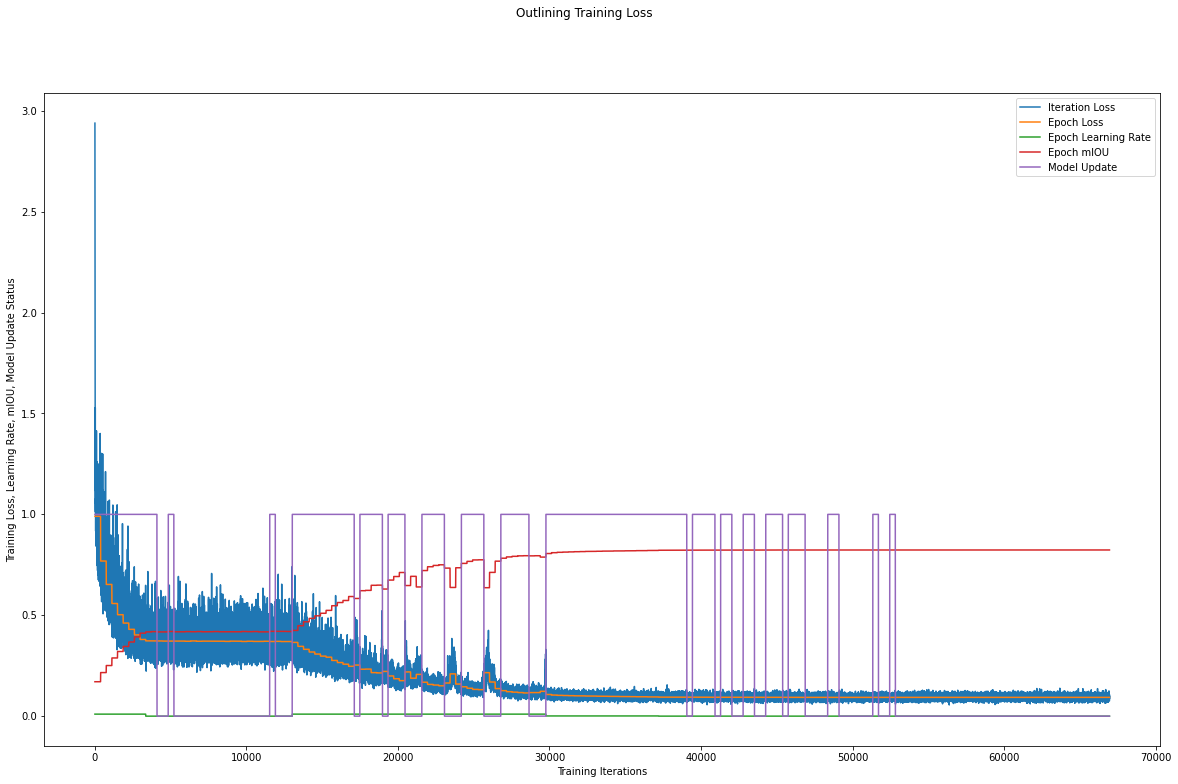

In [48]:
plot_training_performance()

In [49]:
mean_iou_list_val, mean_iou_val = validate_and_save(val_set, device_rtx3070)

100%|██████████| 500/500 [04:53<00:00,  1.70it/s]


     >>>  Predictions saved & IOU evaluated on Val Set in 293.85274 seconds     
**************************************
[ID] [   CLASS NAME   ] [Mean IOU %]
**************************************
[ 0] [road            ] [90.193739]
[ 1] [sidewalk        ] [59.018873]
[ 2] [building        ] [75.049805]
[ 3] [wall            ] [14.368795]
[ 4] [fence           ] [21.287363]
[ 5] [pole            ] [45.261925]
[ 6] [traffic light   ] [12.391436]
[ 7] [traffic sign    ] [41.623495]
[ 8] [vegetation      ] [85.860305]
[ 9] [terrain         ] [38.002052]
[10] [sky             ] [66.579308]
[11] [preson          ] [50.929991]
[12] [rider           ] [14.344239]
[13] [car             ] [76.036563]
[14] [truck           ] [3.512214]
[15] [bus             ] [18.451598]
[16] [train           ] [14.161603]
[17] [motorcycle      ] [18.630349]
[18] [bicycle         ] [52.544957]
**************************************
          mIOU = 42.0131  %          


In [ ]:
mean_iou_list_test, mean_iou_test = validate_and_save(test_set, device_rtx3070)